In [1]:
# Yile Shen
# 3/7/2024
# Advanced Programming: AIML
# Osu playing robot

# Load in relevant libraries, and alias where appropriate
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import cv2
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import ReduceLROnPlateau
import time
import math

from tqdm import tqdm

# couple notes: i chose to switch to pytorch as I was more comfortable with it
# and I needed to customize my model in a lot of ways, and I couldn't
# adequately get tensorflow to work.

# I also already had a really good setup for pytorch and I spent more time
# tuning the gpu usage on tensorflow. Pytorch also saved WAY more memory overall.

# Device will determine whether to run the training on GPU or CPU.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.backends.cudnn.benchmark = True

# print name
print(torch.cuda.get_device_name(device))

# i had a tensorflow version, but I couldn't get some things to work in it
# so I switched to pytorch because I'm more comfortable with it and can do more.

#process images here so I can change resolution whenever
#
# FOLDER_PATH = "C:/Users/Yile0/PycharmProjects/osutime/frames/"
#
# for i in range(14, 5379):
#     img = cv2.imread(FOLDER_PATH + str(i)+".png")
#     img = cv2.resize(img, (160, 120), interpolation=cv2.INTER_AREA)
#     cv2.imwrite(FOLDER_PATH + str(i)+".png", img)
# making a custom image dataset class for pytorch
# originally had a custom dataset maker, but the dataloader is way better
# and formats them better.



NVIDIA GeForce RTX 4070


In [2]:
# compile dataset.
dataset_path = "C:/Users/Yile0/PycharmProjects/osutime/map1_data.csv"
data = pd.read_csv(dataset_path)

print(data.head())
print(data.columns)
# small data for changing, basically just for trialing new changes.
small_data = sklearn.utils.resample(data, n_samples= 1000)

# frame 4 is the latest/ most recent.

#originally these were one piece, changed for the dataloader to function
processed_data = []
processed_labels = []


def process_img(paths):
    # I had another self-made thing here that I decided to replace with premade functions
    images = []
    transform = transforms.Compose([transforms.ToTensor()])
    for path in paths:
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
        # 100 by 75 because slightly better quality
        # over 80 by 60
        img = cv2.resize(img, (120, 68), interpolation=cv2.INTER_AREA)
        img_normalized = cv2.normalize(img, None, 0, 1.0,
                                       cv2.NORM_MINMAX, dtype=cv2.CV_32F)
        images.append(transform(img_normalized))
    out = torch.stack(images)
    # i played with trying to reshape to 120 16, but I came back
    # to this resolution because it was just so much better and faster
    # with regards to my training speed.
    out = out.reshape(len(paths),68,120)
    # played with preloading here and loading later, seems like loading later is better.
    # img = torch.from_numpy(img)
    return out


for index, row in tqdm(data.iterrows()):
    # trying without normalization.
    processed_labels.append([row['x'], row['y']])
    # try to predict just on 1 frame for testing
    processed_data.append(process_img([row['frame 4'],row['frame 3'],row['frame 2'],row['frame 1']]))


X_train, X_test, y_train, y_test = train_test_split(processed_data, processed_labels, test_size=0.2, random_state=39)

          x         y                                            frame 4  \
0  253.3333  256.4445  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
1  253.3333  256.0000  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
2  252.8889  256.0000  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
3  252.8889  256.0000  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
4  252.8889  256.0000  C:/Users/Yile0/PycharmProjects/osutime/frames/...   

                                             frame 3  \
0  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
1  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
2  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
3  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
4  C:/Users/Yile0/PycharmProjects/osutime/frames/...   

                                             frame 2  \
0  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
1  C:/Users/Yile0/PycharmProjects/osutime/frames/...   
2  C:/Users/Yile0/PycharmProjects/osut

8930it [02:19, 63.86it/s]


In [3]:
class ImageDataset(Dataset):
    def __init__(self, images, labels, imageTransform=None, num_workers=0):
        self.imageTransform = imageTransform
        self.num_workers = num_workers
        self.imgs = images
        self.targets = labels

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        image = self.imgs[idx]
        target = self.targets[idx]
        label = torch.Tensor(target)

        return image, label

In [4]:
# Creating a CNN class
# conv neural net combined was bad, this iteration separates them
class ConvNeuralNet(nn.Module):
    #  Determine what layers and their order in CNN object
    def __init__(self, num_classes):
        super(ConvNeuralNet, self).__init__()
        # adjusted the first pooling to be 4 instead.
        # tried second pooling to be 4 too

        self.conv_layer1 = nn.Conv2d(in_channels=4, out_channels=64, kernel_size=4)
        self.max_pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_layer2 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=4)
        self.max_pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv_layer3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=4)
        self.max_pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv_layer4 = nn.Conv2d(in_channels=512, out_channels=64, kernel_size=4)
        self.max_pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        self.relu = nn.LeakyReLU()
        self.sigmoid = nn.Sigmoid()
        self.fc1 = nn.Linear(24192, 128)
        # originally tried relu layers, but wanted something non-linear
        # went back because elu wasn't doing better
        # had 3 layers to begin with, then tried 4, then tried 7
        # I one off tried 13 but it didn't fit.=
        self.fc2 = nn.Linear(128,1)
        self.fc3 = nn.Linear(128, 1)
        self.fc4 = nn.Linear(128, 64)
        self.fc5 = nn.Linear(64, 32)
        self.fc6 = nn.Linear(32, 16)
        self.fc7 = nn.Linear(16, 1)
        # self.relu7 = nn.ReLU()
        # self.fc8 = nn.Linear(75, 1)
        # self.relu8 = nn.ReLU()
        # self.fc9 = nn.Linear(25, 1)
        # self.relu9 = nn.ReLU()
        # self.fc10 = nn.Linear(50, 1)
    # Progresses data across layers
    def forward(self, input):
        out_x = self.conv_layer1(input)
        out_x = self.relu(out_x)
        out_x = self.max_pool1(out_x)
        out_x = self.conv_layer2(out_x)
        out_x = self.relu(out_x)
        out_x = self.max_pool2(out_x)

        # out_x = self.conv_layer3(out_x)
        # out_x = self.relu(out_x)
        # out_x = self.max_pool3(out_x)
        # out_x = self.conv_layer4(out_x)
        # out_x = self.relu(out_x)
        # out_x = self.max_pool4(out_x)

        out_x = out_x.reshape(out_x.size(0), -1)
        
        out_x = self.fc1(out_x)
        out_x = self.sigmoid(out_x)
        out_x = self.fc2(out_x)
        out_x = self.sigmoid(out_x)
        # out_x = self.fc3(out_x)
        # out_x = self.sigmoid(out_x)
        # out_x = self.relu(out_x)
        # out_x = self.relu(out_x)
        # out_x = self.relu(out_x)

        return out_x

In [13]:
# Define relevant variables for the ML task
# tried batch sizes of 32 and 128 as well, but this was best
# 128 had better cuda utilization but didn't boost speed too much.
# decided it was more worth it to have better accuracy because 128 could
# introduce inaccuracies.
# after adding a few new layers 64 wasn't enough to have fast epochs
# so I decided to move to 128.
# accidentally tried batch size of 1, was way too inefficient
batch_size = 80
# originally learning rate was 0.001, but im making it learn longer and slower.
# makes me wonder if my original idea would have worked, but now it's too late to fix it.
# 0.001 basically didn't learn. I trained for somwhere around 500 epochs and loss basiclly didn't change
# from now on, I ran some 20 epoch experiments.
# 0.0001 was learning a lot to start, but loss seems to cycle between 0.10 and 0.13 or so

# 0.00001 had loss settle at around 0.28/0.3, which is maybe due to the lack of time it had to train.
# loss was generally going down even at 50 epochs, can't tell without a longer experiment.
# i'm going to keep it at this and train for 100 and see what happens.
# doesn't seem to improve past loss = 0.11

# running a 400 epoch experiment with learning rate 0.000001
learning_rate = 0.0001
# ran a few experiments on 20 epochs to see if it would learn.
num_epochs = 500
device = "cuda"

In [14]:
dataset = ImageDataset(X_train, y_train)
test = ImageDataset(X_test, y_test)

# added workers to speedup epoch time.
# 3 is the max tolerable it seems.
data_loader = DataLoader(dataset, batch_size=batch_size)
test_loader = DataLoader(test, batch_size=batch_size)


# model = ConvNeuralNet(2, train_data.shape[0])

# Set Loss function with criterion

model_x = ConvNeuralNet(2)
model_x.cuda(device)
# adam is just better, tried other optimizers like sgd though
optimizer_x = torch.optim.Adam(model_x.parameters(), lr=learning_rate)

model_y = ConvNeuralNet(2)
model_y.cuda(device)
# adam is just better, tried other optimizers like sgd though

optimizer_y = torch.optim.Adam(model_y.parameters(), lr=learning_rate)
# MSE loss instead of L1, which is squared loss vs linear loss.
# Huber over both, has the benefits of both.
criterion = nn.MSELoss()
epoch_start = 0


epoch_start = 0
# added code that allows it to train again from a checkpoint
# it lets me train in chunks over time.
checkpoint = torch.load('model.pth')
model_x.load_state_dict(checkpoint['model_x_state_dict'])
optimizer_x.load_state_dict(checkpoint['optimizer_x_state_dict'])
model_y.load_state_dict(checkpoint['model_y_state_dict'])
optimizer_y.load_state_dict(checkpoint['optimizer_y_state_dict'])
epoch_start = checkpoint['epoch']
loss = checkpoint['loss']

# Set optimizer with optimizer

total_step = len(processed_data)

model_x.train()
model_y.train()

losses_x = []
losses_y = []
losses_val_x = []
losses_val_y = []

lr_y = []
lr_x = []

C:\Users\Yile0\AppData\Local\Temp\ipykernel_39052\2514060375.py:33: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('model.pth')


In [15]:
import gc
def main():
    gc.collect()
    torch.cuda.empty_cache()
    for epoch in tqdm(range(epoch_start, num_epochs)):
        start = time.time()
        model_x.train()
        model_y.train()
        # Load in the data in batches using the train_loader object
        for i, (images, labels) in enumerate(data_loader):
            images = images.cuda(device)
            # Move tensors to the configured device
            # images already got loaded on
            # images = images.to(device)
            labels = labels.cuda(device)
            x_labels = labels[:, 0].unsqueeze(1)
            x_labels.requires_grad = True
            x_labels = x_labels.cuda(device)
            y_labels = labels[:, 1].unsqueeze(1)
            y_labels.requires_grad = True
            y_labels = y_labels.cuda(device)
            # Forward pass
            output_x = model_x(images) * 512
            loss_x = criterion(output_x, x_labels)
            output_y = model_y(images) * 384
            loss_y = criterion(output_y, y_labels)
            # Backward and optimize
            optimizer_y.zero_grad()
            optimizer_x.zero_grad()
            # had tried to combined, but now i'm just completely
            # separating the two models.
            loss_x.backward()
            loss_y.backward()
            optimizer_y.step()
            optimizer_x.step()
        # added checkpoint saver
        if (epoch + 1) % 6 == 0:
            torch.save({
                'epoch': epoch,
                'model_x_state_dict': model_x.state_dict(),
                'optimizer_x_state_dict': optimizer_x.state_dict(),
                'model_y_state_dict': model_y.state_dict(),
                'optimizer_y_state_dict': optimizer_y.state_dict(),
                'loss': criterion,
            }, "model.pth")
        model_x.eval()
        model_y.eval()
        for i, (images, labels) in enumerate(test_loader):
            images = images.to(device)
            # Move tensors to the configured device
            # images already got loaded on
            # images = images.to(device)
            labels = labels.to(device)
            x_labels = labels[:, 0].unsqueeze(1)
            y_labels = labels[:, 1].unsqueeze(1)
            # Forward pass
            output_x = model_x(images) * 512
            loss_x_valid = criterion(output_x, x_labels)
            output_y = model_y(images) * 384
            loss_y_valid = criterion(output_y, y_labels)

        print('x val')
        print(x_labels)
        print(output_x)
        print('y val')
        print(y_labels)
        print(output_y)

        # step lr scheduler
        # add so I can graph later
        losses_x.append(loss_x.item())
        losses_y.append(loss_y.item())
        losses_val_x.append(loss_x_valid.item())
        losses_val_y.append(loss_y_valid.item())
        print('validate Loss_X: {:.10f}, validate Loss_y : {:.10f}'.format( loss_x_valid.item(), loss_y_valid.item()))

        end = time.time()
        print('Epoch [{}/{}], Loss1: {:.10f}, Loss2 : {:.4f} Time: {:.10f}'.format(epoch + 1, num_epochs, loss_x.item(), loss_y.item(), end-start))

    torch.save({
                    'epoch': num_epochs,
                    'model_x_state_dict': model_x.state_dict(),
                    'optimizer_x_state_dict': optimizer_x.state_dict(),
                    'model_y_state_dict': model_y.state_dict(),
                    'optimizer_y_state_dict': optimizer_y.state_dict(),
                    'loss': criterion,
                }, "model.pth")


if __name__ == '__main__':
    main()

  0%|          | 1/375 [00:03<20:15,  3.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[124.4919],
        [441.4407],
        [191.1179],
        [322.5008],
        [191.9724],
        [241.7567],
        [217.0931],
        [416.1266],
        [438.5287],
        [ 83.1692],
        [418.2591],
        [425.3578],
        [266.3283],
        [324.6181],
        [125.6270],
        [271.6917],
        [370.9542],
        [190.9488],
        [259.6800],
        [372.3514],
        [448.8377],
        [108.8291],
        [355.287

  1%|          | 2/375 [00:05<16:14,  2.61s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[116.6582],
        [437.8288],
        [196.8680],
        [310.5880],
        [196.9693],
        [240.8830],
        [219.6069],
        [418.5751],
        [437.0003],
        [ 85.3237],
        [418.2541],
        [419.7689],
        [252.3658],
        [321.9268],
        [124.7341],
        [264.2788],
        [353.2054],
        [188.9654],
        [261.1889],
        [370.9028],
        [446.6548],
        [104.4427],
        [348.756

  1%|          | 3/375 [00:07<14:58,  2.41s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.6925],
        [439.5513],
        [203.1131],
        [312.6425],
        [189.1639],
        [239.8880],
        [217.3866],
        [416.9716],
        [429.2469],
        [ 84.2391],
        [417.8015],
        [422.7733],
        [265.3827],
        [320.2818],
        [123.9553],
        [271.4487],
        [360.0563],
        [184.1096],
        [260.2543],
        [371.2252],
        [444.9478],
        [102.9600],
        [356.962

  1%|          | 4/375 [00:09<14:17,  2.31s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[129.1404],
        [440.6522],
        [200.9709],
        [313.6449],
        [201.0887],
        [240.6119],
        [213.2567],
        [419.3825],
        [434.7228],
        [ 89.9330],
        [418.6401],
        [424.0390],
        [255.0551],
        [329.2281],
        [121.2361],
        [273.5106],
        [369.9788],
        [181.8335],
        [260.2938],
        [369.0121],
        [438.3620],
        [ 93.9716],
        [355.337

  1%|▏         | 5/375 [00:11<13:54,  2.26s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.0502],
        [436.4080],
        [195.1881],
        [309.5396],
        [195.5241],
        [240.8604],
        [217.0518],
        [421.8770],
        [434.7089],
        [ 92.8781],
        [419.6198],
        [427.6203],
        [256.8948],
        [321.1346],
        [126.4427],
        [280.3998],
        [371.6502],
        [190.2326],
        [259.9607],
        [367.1253],
        [447.4074],
        [100.5022],
        [356.421

  2%|▏         | 6/375 [00:14<13:40,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[128.5456],
        [437.4689],
        [205.3046],
        [311.2093],
        [191.4617],
        [241.7361],
        [214.4307],
        [414.2223],
        [444.5330],
        [ 89.3503],
        [418.7566],
        [423.5855],
        [268.7805],
        [319.1278],
        [127.3892],
        [269.3250],
        [362.5312],
        [183.3496],
        [261.9275],
        [370.9601],
        [450.2501],
        [ 95.3747],
        [357.503

  2%|▏         | 7/375 [00:16<13:40,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.3115],
        [439.0551],
        [191.9599],
        [316.5017],
        [193.8569],
        [239.7529],
        [212.9602],
        [411.7880],
        [434.1894],
        [ 83.8585],
        [418.1298],
        [420.0657],
        [268.1321],
        [315.3787],
        [122.7520],
        [268.3865],
        [356.7314],
        [182.3777],
        [266.2663],
        [369.0453],
        [442.3299],
        [ 98.1885],
        [356.692

  2%|▏         | 8/375 [00:18<13:27,  2.20s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[125.1777],
        [441.2329],
        [186.4290],
        [316.8840],
        [194.8695],
        [239.1482],
        [214.8717],
        [409.3000],
        [428.0420],
        [ 83.6962],
        [416.9389],
        [418.3658],
        [264.1348],
        [312.2441],
        [118.3984],
        [268.5594],
        [357.7245],
        [187.5028],
        [257.9297],
        [367.8384],
        [441.2050],
        [ 94.6110],
        [363.726

  2%|▏         | 9/375 [00:20<13:17,  2.18s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[130.1702],
        [439.0888],
        [186.8284],
        [321.3948],
        [192.2142],
        [240.0104],
        [212.1658],
        [409.8138],
        [431.7242],
        [ 85.8573],
        [418.0836],
        [423.6997],
        [269.7984],
        [323.5576],
        [127.6957],
        [275.8886],
        [364.2588],
        [179.6212],
        [256.7464],
        [369.2847],
        [442.1443],
        [ 81.1737],
        [359.468

  3%|▎         | 10/375 [00:22<13:20,  2.19s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[135.8804],
        [439.1060],
        [182.8169],
        [319.0324],
        [192.2766],
        [240.3612],
        [217.3420],
        [406.2759],
        [435.7031],
        [ 81.1315],
        [417.0095],
        [423.4591],
        [265.3681],
        [324.9520],
        [126.4284],
        [274.5499],
        [371.4624],
        [182.5881],
        [258.1514],
        [373.2389],
        [442.6244],
        [ 85.1353],
        [357.184

  3%|▎         | 11/375 [00:24<13:15,  2.19s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[116.4711],
        [438.1231],
        [188.2461],
        [321.6711],
        [184.0801],
        [237.6173],
        [213.8526],
        [409.3114],
        [442.8388],
        [ 78.7280],
        [415.3366],
        [417.9568],
        [264.4189],
        [321.1559],
        [115.9273],
        [279.7815],
        [350.6067],
        [183.2290],
        [265.0646],
        [370.4969],
        [438.3629],
        [ 88.1026],
        [352.800

  3%|▎         | 12/375 [00:27<13:08,  2.17s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[113.2197],
        [438.6621],
        [190.7605],
        [323.3139],
        [192.8630],
        [237.7002],
        [208.8822],
        [406.2183],
        [436.8633],
        [ 76.5330],
        [416.0575],
        [419.0308],
        [258.4129],
        [320.0499],
        [113.4066],
        [276.1237],
        [355.3623],
        [178.9257],
        [258.3212],
        [368.3474],
        [443.3773],
        [ 86.2329],
        [348.898

  3%|▎         | 13/375 [00:29<13:22,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[125.6306],
        [437.8233],
        [182.9023],
        [324.3076],
        [195.7840],
        [237.5132],
        [206.6739],
        [415.1849],
        [439.5241],
        [ 79.5227],
        [416.4300],
        [419.6557],
        [259.6188],
        [323.2347],
        [114.9755],
        [279.2531],
        [360.1436],
        [176.2656],
        [255.2733],
        [366.7886],
        [437.2690],
        [ 81.6637],
        [351.246

  4%|▎         | 14/375 [00:31<13:18,  2.21s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[120.3716],
        [436.6997],
        [197.6804],
        [323.1274],
        [187.2674],
        [238.6407],
        [212.9442],
        [417.3205],
        [443.8878],
        [ 79.8580],
        [415.9350],
        [423.5715],
        [273.2758],
        [325.1281],
        [119.7624],
        [278.5946],
        [365.0016],
        [177.3195],
        [251.7390],
        [370.1750],
        [445.5560],
        [ 75.2391],
        [351.102

  4%|▍         | 15/375 [00:33<13:14,  2.21s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[119.4389],
        [441.6624],
        [181.7001],
        [328.7179],
        [187.0717],
        [239.8706],
        [218.4618],
        [415.9481],
        [452.4851],
        [ 80.8888],
        [418.8706],
        [422.5357],
        [263.1552],
        [324.6906],
        [120.4171],
        [282.1900],
        [372.4196],
        [185.0002],
        [258.9052],
        [373.7889],
        [439.1754],
        [ 84.8843],
        [349.120

  4%|▍         | 16/375 [00:36<13:12,  2.21s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[119.4279],
        [439.0978],
        [182.5472],
        [320.2694],
        [196.0379],
        [241.7195],
        [213.5353],
        [414.2543],
        [453.5038],
        [ 78.8488],
        [417.8948],
        [423.2880],
        [272.2564],
        [322.4544],
        [118.0612],
        [283.2514],
        [363.0111],
        [186.4323],
        [255.3439],
        [371.5870],
        [446.0509],
        [ 87.3261],
        [350.288

  5%|▍         | 17/375 [00:38<13:09,  2.21s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[111.2838],
        [437.0790],
        [188.3273],
        [313.1618],
        [188.9885],
        [240.4657],
        [210.7430],
        [411.5923],
        [453.4100],
        [ 79.5721],
        [416.4125],
        [420.2052],
        [258.1520],
        [321.3718],
        [117.3341],
        [278.1463],
        [357.1241],
        [180.4486],
        [259.7610],
        [367.2912],
        [448.8312],
        [ 96.6379],
        [345.414

  5%|▍         | 18/375 [00:40<13:07,  2.20s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[127.7558],
        [434.8238],
        [195.5096],
        [326.0634],
        [192.2196],
        [241.5092],
        [213.0840],
        [414.4760],
        [443.7495],
        [ 77.9593],
        [417.8335],
        [421.7659],
        [278.4207],
        [327.3022],
        [111.5773],
        [281.0620],
        [360.8987],
        [185.0727],
        [260.4650],
        [368.8247],
        [447.3349],
        [ 98.6434],
        [346.918

  5%|▌         | 19/375 [00:42<13:16,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[129.6882],
        [437.7379],
        [194.8963],
        [324.1664],
        [195.2330],
        [245.2097],
        [220.7002],
        [406.5572],
        [443.7141],
        [ 75.4380],
        [419.5469],
        [425.5584],
        [263.4589],
        [322.9549],
        [112.5109],
        [284.4648],
        [367.7273],
        [194.7458],
        [257.8810],
        [369.2942],
        [444.1590],
        [ 77.8026],
        [354.622

  5%|▌         | 20/375 [00:44<13:10,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[135.3311],
        [444.5326],
        [203.6277],
        [321.7864],
        [192.1355],
        [251.0207],
        [221.5629],
        [411.3082],
        [442.1806],
        [ 76.5070],
        [423.8141],
        [426.3446],
        [270.4703],
        [330.9460],
        [113.9060],
        [279.1117],
        [360.9737],
        [192.7023],
        [259.5096],
        [372.3043],
        [453.8139],
        [101.8093],
        [364.586

  6%|▌         | 21/375 [00:47<13:06,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[122.8187],
        [442.8677],
        [194.6173],
        [315.5917],
        [190.7629],
        [247.1739],
        [219.5709],
        [410.6570],
        [449.3342],
        [ 76.1150],
        [420.8257],
        [425.2865],
        [269.8640],
        [325.3125],
        [113.2948],
        [279.2761],
        [368.8037],
        [187.8461],
        [264.6750],
        [372.1639],
        [450.8374],
        [ 92.4557],
        [356.622

  6%|▌         | 22/375 [00:49<13:01,  2.21s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[126.4500],
        [439.0126],
        [194.0376],
        [314.2693],
        [189.3137],
        [240.1959],
        [212.2496],
        [410.8542],
        [435.8148],
        [ 82.9684],
        [419.7668],
        [424.9938],
        [265.6266],
        [327.7134],
        [116.0838],
        [276.1755],
        [364.1360],
        [185.8250],
        [258.8350],
        [370.9820],
        [445.3725],
        [ 97.3292],
        [360.818

  6%|▌         | 23/375 [00:51<12:58,  2.21s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[129.8619],
        [439.1575],
        [190.1635],
        [315.4954],
        [184.4894],
        [242.5572],
        [213.0740],
        [412.8813],
        [435.8341],
        [ 89.5774],
        [420.9285],
        [428.0164],
        [271.3848],
        [333.1617],
        [120.5242],
        [278.0427],
        [362.8044],
        [188.3285],
        [260.6810],
        [371.6310],
        [442.6206],
        [ 91.7276],
        [362.252

  6%|▋         | 24/375 [00:53<12:55,  2.21s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[128.5787],
        [440.3942],
        [196.3550],
        [320.3752],
        [191.1223],
        [241.9474],
        [217.9906],
        [409.1957],
        [444.4642],
        [ 88.3432],
        [423.0744],
        [424.8532],
        [271.4761],
        [332.0721],
        [118.2088],
        [283.0942],
        [365.7619],
        [191.9356],
        [260.8164],
        [371.0529],
        [442.1891],
        [ 91.0328],
        [362.588

  7%|▋         | 25/375 [00:56<13:04,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[129.7435],
        [441.2983],
        [184.9235],
        [327.6327],
        [186.0227],
        [241.0137],
        [220.7292],
        [404.6394],
        [446.5164],
        [ 85.1641],
        [421.9725],
        [425.4420],
        [267.5984],
        [326.7694],
        [124.6919],
        [280.4812],
        [365.8985],
        [193.7823],
        [266.2095],
        [372.3910],
        [451.9037],
        [ 94.2789],
        [358.930

  7%|▋         | 26/375 [00:58<12:57,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[115.4029],
        [440.2880],
        [199.4386],
        [319.5457],
        [185.9306],
        [240.8769],
        [210.7615],
        [408.1623],
        [449.3134],
        [ 83.8274],
        [421.3635],
        [421.5861],
        [262.6357],
        [327.8626],
        [116.1502],
        [277.5121],
        [358.4312],
        [182.7652],
        [263.7679],
        [371.5246],
        [446.6428],
        [100.3543],
        [353.275

  7%|▋         | 27/375 [01:00<12:53,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[103.7233],
        [433.7297],
        [190.3165],
        [320.5048],
        [186.4620],
        [240.2793],
        [205.5935],
        [406.8111],
        [444.1906],
        [ 84.7078],
        [419.0627],
        [422.1151],
        [255.2276],
        [327.0295],
        [118.2669],
        [273.7747],
        [359.8671],
        [177.6263],
        [259.6242],
        [369.5588],
        [447.2278],
        [ 94.7899],
        [356.577

  7%|▋         | 28/375 [01:02<12:49,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[122.1267],
        [436.8954],
        [186.3711],
        [318.6426],
        [182.3221],
        [240.3527],
        [215.9690],
        [403.8781],
        [433.8307],
        [ 86.4766],
        [418.7027],
        [423.7444],
        [273.9518],
        [318.5348],
        [116.5613],
        [272.3784],
        [360.1525],
        [190.5280],
        [257.8531],
        [369.6283],
        [448.7643],
        [ 93.4019],
        [359.939

  8%|▊         | 29/375 [01:04<12:46,  2.21s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[114.8807],
        [439.3811],
        [189.7942],
        [315.0877],
        [176.2607],
        [240.6698],
        [215.7593],
        [402.6543],
        [435.7577],
        [ 83.6194],
        [419.5665],
        [424.3139],
        [274.5706],
        [322.6009],
        [123.4478],
        [271.2981],
        [364.8439],
        [187.9411],
        [255.2047],
        [371.2969],
        [448.4990],
        [ 93.8333],
        [360.178

  8%|▊         | 30/375 [01:07<12:42,  2.21s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[114.0493],
        [438.7448],
        [192.3560],
        [319.7379],
        [184.2832],
        [238.2954],
        [216.1399],
        [405.2909],
        [433.9837],
        [ 76.4398],
        [418.9582],
        [421.5967],
        [266.1215],
        [323.1546],
        [124.5260],
        [271.5829],
        [359.9203],
        [188.3136],
        [264.2313],
        [371.4386],
        [439.9901],
        [ 91.3621],
        [358.247

  8%|▊         | 31/375 [01:09<12:52,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[113.3981],
        [435.9754],
        [192.7548],
        [312.3913],
        [178.2879],
        [239.4609],
        [207.9637],
        [408.3867],
        [437.0870],
        [ 78.7556],
        [417.4705],
        [421.1267],
        [269.6552],
        [332.8609],
        [111.4723],
        [270.0757],
        [356.7009],
        [183.9152],
        [254.8551],
        [369.6705],
        [445.5059],
        [103.2897],
        [354.075

  9%|▊         | 32/375 [01:11<12:46,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[108.3172],
        [433.1224],
        [200.6724],
        [318.0431],
        [180.2571],
        [240.4558],
        [211.1726],
        [408.6997],
        [433.7030],
        [ 80.7663],
        [418.7794],
        [421.6049],
        [266.9984],
        [323.0639],
        [118.3057],
        [265.2537],
        [355.7257],
        [180.5045],
        [262.0401],
        [369.3962],
        [443.0348],
        [102.0572],
        [349.684

  9%|▉         | 33/375 [01:13<12:40,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[113.4684],
        [434.0145],
        [178.7542],
        [306.8051],
        [197.4343],
        [239.7253],
        [209.9483],
        [411.8354],
        [428.1123],
        [ 80.5509],
        [419.7669],
        [420.0880],
        [264.6725],
        [327.0577],
        [118.7667],
        [267.3269],
        [349.7969],
        [182.2395],
        [252.6558],
        [368.8898],
        [435.4769],
        [ 93.1428],
        [347.662

  9%|▉         | 34/375 [01:16<12:36,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.3766],
        [436.1416],
        [177.2160],
        [310.7553],
        [198.3097],
        [238.3115],
        [213.0629],
        [411.0765],
        [424.8807],
        [ 76.9531],
        [417.5535],
        [423.3615],
        [257.0688],
        [324.1076],
        [112.8049],
        [266.1341],
        [364.4397],
        [186.5316],
        [253.1172],
        [369.0105],
        [438.0064],
        [ 89.0901],
        [355.226

  9%|▉         | 35/375 [01:18<12:32,  2.21s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[126.7934],
        [438.0184],
        [180.6841],
        [307.7889],
        [193.3771],
        [235.4476],
        [220.6677],
        [409.6826],
        [429.5580],
        [ 77.8299],
        [417.3463],
        [420.9302],
        [254.0834],
        [317.8405],
        [119.9931],
        [273.0684],
        [365.8986],
        [188.5129],
        [265.2834],
        [370.1087],
        [438.7798],
        [ 93.9088],
        [354.293

 10%|▉         | 36/375 [01:20<12:28,  2.21s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[114.3978],
        [438.2875],
        [188.6973],
        [296.0847],
        [189.6203],
        [238.8478],
        [216.6753],
        [408.1234],
        [427.6731],
        [ 75.1429],
        [416.1653],
        [420.4483],
        [263.7184],
        [324.9267],
        [121.8977],
        [266.1389],
        [363.2139],
        [185.8093],
        [262.8189],
        [369.2899],
        [441.1881],
        [103.3238],
        [355.161

 10%|▉         | 37/375 [01:22<12:38,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.9900],
        [437.1874],
        [192.7514],
        [301.3571],
        [196.9065],
        [240.0306],
        [213.7909],
        [405.2941],
        [420.1520],
        [ 79.3285],
        [416.3347],
        [420.4179],
        [246.3128],
        [323.1891],
        [114.0860],
        [273.1491],
        [358.3802],
        [184.2128],
        [262.0161],
        [368.7433],
        [440.6077],
        [ 84.4339],
        [355.100

 10%|█         | 38/375 [01:24<12:32,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[128.0209],
        [435.5239],
        [187.0055],
        [323.0695],
        [193.4974],
        [244.7023],
        [197.1886],
        [409.8671],
        [422.3743],
        [ 83.9270],
        [416.3037],
        [421.4676],
        [261.8067],
        [324.0239],
        [117.9973],
        [272.4843],
        [352.2096],
        [171.0315],
        [261.4286],
        [366.7794],
        [438.2243],
        [ 90.4892],
        [355.471

 10%|█         | 39/375 [01:27<12:27,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[121.8944],
        [438.3058],
        [191.6022],
        [316.6974],
        [193.7389],
        [244.8258],
        [223.7539],
        [404.0109],
        [421.5512],
        [ 82.2821],
        [418.8596],
        [422.5844],
        [256.3010],
        [319.6711],
        [116.5474],
        [278.4932],
        [359.7405],
        [200.8875],
        [262.2514],
        [369.9572],
        [439.9360],
        [ 94.5361],
        [356.912

 11%|█         | 40/375 [01:29<12:23,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[126.6350],
        [436.9595],
        [199.2066],
        [314.0264],
        [182.2599],
        [243.7054],
        [215.0502],
        [406.6663],
        [437.6192],
        [ 84.5640],
        [416.9790],
        [422.6173],
        [272.5111],
        [323.7862],
        [126.7459],
        [268.3177],
        [358.6913],
        [188.8575],
        [261.6879],
        [371.0971],
        [436.7240],
        [ 84.4431],
        [356.716

 11%|█         | 41/375 [01:31<12:19,  2.21s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[119.0894],
        [440.5194],
        [198.4702],
        [316.8840],
        [194.5933],
        [244.2404],
        [212.9705],
        [404.3259],
        [440.0600],
        [ 78.0089],
        [418.1363],
        [423.4947],
        [263.3508],
        [318.8990],
        [126.7408],
        [270.1816],
        [361.0112],
        [188.7854],
        [261.2096],
        [370.7505],
        [445.6792],
        [100.2547],
        [356.903

 11%|█         | 42/375 [01:33<12:16,  2.21s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[113.3292],
        [434.8967],
        [203.9568],
        [318.5135],
        [202.4431],
        [237.5017],
        [213.6493],
        [410.4096],
        [442.5346],
        [ 80.0907],
        [414.7957],
        [421.8783],
        [263.5667],
        [322.2584],
        [107.0062],
        [270.2237],
        [346.4841],
        [187.8626],
        [255.7744],
        [367.0376],
        [445.1903],
        [ 83.5863],
        [354.786

 11%|█▏        | 43/375 [01:36<12:25,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[135.0882],
        [435.3953],
        [193.3097],
        [326.9389],
        [186.8366],
        [244.8569],
        [214.5647],
        [406.8943],
        [439.8467],
        [ 78.4513],
        [419.2393],
        [423.3958],
        [254.7385],
        [326.0658],
        [119.7027],
        [273.3332],
        [363.3456],
        [190.2261],
        [249.8617],
        [369.8632],
        [443.2258],
        [ 85.2656],
        [354.896

 12%|█▏        | 44/375 [01:38<12:20,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[122.7945],
        [441.3717],
        [195.7170],
        [321.2281],
        [182.4265],
        [245.6370],
        [220.0505],
        [418.9318],
        [443.9822],
        [ 80.5759],
        [421.7133],
        [424.9419],
        [271.6911],
        [324.9463],
        [119.4553],
        [277.6417],
        [371.3710],
        [198.9888],
        [250.3763],
        [372.4310],
        [444.3926],
        [ 88.2579],
        [357.010

 12%|█▏        | 45/375 [01:40<12:14,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[126.7343],
        [439.6015],
        [193.1785],
        [312.0050],
        [192.0006],
        [237.8600],
        [222.3047],
        [417.2286],
        [446.7737],
        [ 77.3186],
        [420.0569],
        [424.2690],
        [260.6817],
        [323.0600],
        [118.5396],
        [280.1476],
        [363.5461],
        [193.5956],
        [258.9327],
        [371.7713],
        [447.6940],
        [ 95.1025],
        [357.910

 12%|█▏        | 46/375 [01:42<12:11,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[119.4946],
        [441.2991],
        [192.8961],
        [314.8034],
        [188.3135],
        [245.4146],
        [257.1109],
        [415.3222],
        [443.5445],
        [ 80.7192],
        [417.9127],
        [423.3618],
        [264.0438],
        [323.6400],
        [118.2772],
        [281.0094],
        [362.6055],
        [206.2853],
        [261.9981],
        [368.2375],
        [444.6776],
        [ 99.2476],
        [365.262

 13%|█▎        | 47/375 [01:44<12:07,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[121.8417],
        [435.9211],
        [193.4763],
        [321.3237],
        [192.4628],
        [246.4510],
        [255.3471],
        [414.5757],
        [439.0337],
        [ 80.8651],
        [418.9077],
        [424.9949],
        [253.4109],
        [315.6570],
        [117.2921],
        [278.9348],
        [344.5730],
        [197.0093],
        [259.0564],
        [369.2422],
        [441.2436],
        [ 91.4056],
        [355.541

 13%|█▎        | 48/375 [01:47<12:05,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[123.8862],
        [435.9287],
        [194.4029],
        [323.8052],
        [193.7695],
        [246.1072],
        [248.1721],
        [412.7543],
        [439.6820],
        [ 81.0753],
        [419.6273],
        [421.7922],
        [264.9604],
        [318.2323],
        [118.5129],
        [278.1422],
        [348.9515],
        [200.1034],
        [261.3765],
        [369.7610],
        [440.4900],
        [ 94.5623],
        [356.458

 13%|█▎        | 49/375 [01:49<12:12,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[113.7506],
        [436.4928],
        [193.6175],
        [321.2692],
        [195.6368],
        [246.1873],
        [216.1844],
        [407.1493],
        [440.1783],
        [ 79.4560],
        [419.4743],
        [420.3666],
        [267.2508],
        [322.1288],
        [116.4769],
        [274.5312],
        [358.4289],
        [193.7826],
        [254.6110],
        [370.6712],
        [441.8660],
        [ 93.6387],
        [355.807

 13%|█▎        | 50/375 [01:51<12:07,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.9427],
        [436.3492],
        [194.7364],
        [316.5188],
        [193.2322],
        [245.7423],
        [206.4480],
        [405.2703],
        [440.0757],
        [ 84.6291],
        [418.6720],
        [420.8303],
        [262.8624],
        [316.6786],
        [119.5266],
        [276.4386],
        [357.1730],
        [195.5840],
        [261.1579],
        [369.4160],
        [445.9641],
        [ 93.7050],
        [357.783

 14%|█▎        | 51/375 [01:53<12:02,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.1978],
        [435.0005],
        [193.2145],
        [320.4956],
        [196.0486],
        [246.0681],
        [210.0105],
        [403.7265],
        [438.6197],
        [ 80.4941],
        [418.9518],
        [422.0821],
        [264.3228],
        [318.9417],
        [118.6373],
        [274.0431],
        [359.1904],
        [197.1222],
        [250.6552],
        [370.4168],
        [441.3596],
        [ 91.7371],
        [356.967

 14%|█▍        | 52/375 [01:56<11:58,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[115.3104],
        [436.8161],
        [191.6885],
        [313.5463],
        [194.0136],
        [245.2549],
        [214.6670],
        [402.1967],
        [439.1469],
        [ 79.6914],
        [418.8852],
        [420.9536],
        [266.1700],
        [313.4697],
        [115.1476],
        [272.6975],
        [360.2802],
        [196.2412],
        [256.6182],
        [369.5310],
        [444.5525],
        [ 91.4478],
        [356.962

 14%|█▍        | 53/375 [01:58<11:54,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[126.7552],
        [437.2289],
        [191.6758],
        [316.5767],
        [199.2336],
        [243.5821],
        [210.3367],
        [407.6783],
        [441.7249],
        [ 77.9609],
        [418.8790],
        [422.9725],
        [271.2267],
        [320.2983],
        [115.5772],
        [272.1597],
        [364.9663],
        [196.9277],
        [257.8995],
        [369.5154],
        [445.4283],
        [ 88.6370],
        [356.663

 14%|█▍        | 54/375 [02:00<11:50,  2.21s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[111.4205],
        [438.4735],
        [192.2995],
        [324.9444],
        [196.3172],
        [244.8787],
        [216.6298],
        [406.4337],
        [439.6625],
        [ 78.9148],
        [418.3879],
        [422.2880],
        [271.0246],
        [311.7159],
        [118.9549],
        [272.1055],
        [362.8420],
        [194.3269],
        [255.7724],
        [369.4178],
        [443.4124],
        [ 90.8148],
        [355.065

 15%|█▍        | 55/375 [02:02<11:58,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[127.7927],
        [436.2954],
        [194.0239],
        [316.2894],
        [194.2016],
        [245.0024],
        [211.5361],
        [405.7000],
        [440.9160],
        [ 80.2143],
        [418.8238],
        [422.7891],
        [274.5997],
        [315.3899],
        [120.6971],
        [270.6647],
        [363.7893],
        [196.7284],
        [254.9036],
        [370.8647],
        [442.1578],
        [ 94.7345],
        [356.754

 15%|█▍        | 56/375 [02:05<11:52,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[113.8609],
        [435.5769],
        [194.2266],
        [319.1327],
        [197.8259],
        [245.0453],
        [212.2826],
        [410.1305],
        [439.5645],
        [ 80.0002],
        [418.7966],
        [420.7997],
        [267.3544],
        [311.5432],
        [115.5274],
        [273.3435],
        [364.8813],
        [195.0639],
        [256.0853],
        [369.3583],
        [441.3929],
        [ 90.3032],
        [357.502

 15%|█▌        | 57/375 [02:07<11:47,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[125.1112],
        [435.5929],
        [193.9922],
        [318.2058],
        [202.8091],
        [244.4938],
        [214.2084],
        [406.7238],
        [438.8318],
        [ 79.5951],
        [418.6659],
        [423.4226],
        [269.9664],
        [314.9250],
        [115.1233],
        [270.8196],
        [362.6857],
        [193.4715],
        [262.3637],
        [369.1602],
        [444.6319],
        [ 93.9529],
        [357.388

 15%|█▌        | 58/375 [02:09<11:43,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[116.9687],
        [435.8723],
        [193.9236],
        [321.8383],
        [202.9259],
        [244.9750],
        [213.0283],
        [410.7769],
        [442.3142],
        [ 80.0767],
        [419.1465],
        [422.7531],
        [269.7907],
        [315.7420],
        [113.9809],
        [273.0539],
        [361.3988],
        [194.9813],
        [261.4557],
        [370.1205],
        [445.6161],
        [ 86.1221],
        [351.765

 16%|█▌        | 59/375 [02:11<11:40,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[123.4345],
        [438.6822],
        [192.9832],
        [310.1518],
        [206.4745],
        [244.8422],
        [215.1826],
        [409.2241],
        [439.1870],
        [ 77.2070],
        [419.4317],
        [423.1236],
        [271.2876],
        [316.2122],
        [112.8698],
        [272.9155],
        [365.2280],
        [196.5144],
        [261.7115],
        [369.4964],
        [447.5466],
        [ 95.6041],
        [353.323

 16%|█▌        | 60/375 [02:13<11:36,  2.21s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[112.3881],
        [433.7942],
        [193.7553],
        [309.5779],
        [194.5714],
        [245.5547],
        [214.0746],
        [409.5579],
        [436.2847],
        [ 78.4317],
        [418.4896],
        [423.3831],
        [263.4531],
        [313.6512],
        [108.4806],
        [274.4979],
        [359.5765],
        [196.0066],
        [255.7299],
        [370.0353],
        [440.1652],
        [ 89.7375],
        [355.881

 16%|█▋        | 61/375 [02:16<11:48,  2.26s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[120.2099],
        [438.0186],
        [193.9676],
        [320.0510],
        [203.7057],
        [245.5471],
        [216.1979],
        [410.1656],
        [437.5862],
        [ 83.5994],
        [419.0124],
        [423.7182],
        [263.1553],
        [313.8781],
        [117.4293],
        [274.1169],
        [367.5985],
        [195.6034],
        [252.9294],
        [370.6472],
        [441.8358],
        [ 97.1782],
        [357.713

 17%|█▋        | 62/375 [02:18<11:42,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[114.1551],
        [436.9822],
        [191.0992],
        [328.4946],
        [191.9592],
        [245.1442],
        [211.1297],
        [407.3696],
        [440.2942],
        [ 78.0829],
        [418.5021],
        [424.1637],
        [265.5557],
        [315.1646],
        [112.5751],
        [272.1966],
        [362.9096],
        [193.5730],
        [259.8967],
        [369.6413],
        [442.0430],
        [ 82.8756],
        [356.502

 17%|█▋        | 63/375 [02:20<11:36,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[123.5174],
        [433.7293],
        [189.4924],
        [315.3039],
        [207.7227],
        [245.6752],
        [214.7088],
        [415.0121],
        [438.0648],
        [ 80.5525],
        [417.9141],
        [423.9427],
        [266.1786],
        [318.7562],
        [116.7176],
        [270.1059],
        [360.9996],
        [195.8082],
        [259.5399],
        [369.4071],
        [433.6756],
        [101.2405],
        [357.833

 17%|█▋        | 64/375 [02:22<11:31,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[121.3687],
        [435.4000],
        [191.8205],
        [314.7284],
        [196.5886],
        [245.9890],
        [216.6330],
        [407.1917],
        [437.6717],
        [ 79.3990],
        [418.9740],
        [423.1463],
        [261.5471],
        [318.6759],
        [121.0027],
        [277.3366],
        [367.1165],
        [197.5204],
        [261.2248],
        [372.1958],
        [437.3697],
        [ 99.3009],
        [354.160

 17%|█▋        | 65/375 [02:25<11:27,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[125.3813],
        [436.4141],
        [186.6163],
        [304.1004],
        [191.9001],
        [245.7659],
        [215.1937],
        [407.6260],
        [438.3293],
        [ 77.9757],
        [419.5966],
        [423.8109],
        [272.6715],
        [319.7945],
        [119.1867],
        [280.4142],
        [363.3557],
        [197.6399],
        [256.6558],
        [370.8371],
        [444.3679],
        [ 93.5614],
        [357.458

 18%|█▊        | 66/375 [02:27<11:23,  2.21s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[122.1234],
        [434.1862],
        [182.9178],
        [293.1995],
        [194.6347],
        [245.5769],
        [216.2224],
        [410.9117],
        [430.0934],
        [ 79.7395],
        [419.0715],
        [422.7896],
        [251.1223],
        [310.0377],
        [115.3852],
        [276.3192],
        [366.8657],
        [198.3578],
        [263.3254],
        [371.8268],
        [444.0758],
        [100.8468],
        [355.764

 18%|█▊        | 67/375 [02:29<11:31,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[120.4332],
        [435.2245],
        [191.9735],
        [315.6749],
        [180.9060],
        [236.6884],
        [212.7609],
        [411.8039],
        [437.5830],
        [ 81.1670],
        [418.5642],
        [422.6353],
        [279.7160],
        [308.2657],
        [118.2931],
        [276.2278],
        [362.7882],
        [192.8480],
        [258.6903],
        [371.1068],
        [437.1035],
        [ 90.0564],
        [356.647

 18%|█▊        | 68/375 [02:31<11:27,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.0631],
        [436.2505],
        [192.7034],
        [307.9192],
        [201.8615],
        [232.8508],
        [215.2759],
        [416.9698],
        [440.7411],
        [ 77.5685],
        [418.4479],
        [422.7543],
        [252.1950],
        [313.5014],
        [108.0735],
        [271.5953],
        [364.5534],
        [185.7912],
        [249.8835],
        [371.1231],
        [447.5997],
        [ 97.0170],
        [356.344

 18%|█▊        | 69/375 [02:34<11:22,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[111.8184],
        [434.9776],
        [192.7690],
        [329.0238],
        [203.5850],
        [232.5076],
        [211.6529],
        [405.7281],
        [429.0758],
        [ 75.3462],
        [416.7794],
        [422.6331],
        [261.9233],
        [308.3001],
        [111.3728],
        [274.6395],
        [365.8108],
        [185.5997],
        [247.5616],
        [368.4055],
        [437.4455],
        [ 88.7874],
        [355.549

 19%|█▊        | 70/375 [02:36<11:19,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[121.5524],
        [433.9642],
        [193.5018],
        [318.1838],
        [209.7094],
        [237.4865],
        [211.7691],
        [409.7737],
        [432.7643],
        [ 75.1550],
        [417.8067],
        [421.3221],
        [253.9755],
        [312.8145],
        [117.8364],
        [271.7396],
        [363.1259],
        [190.2791],
        [251.1546],
        [360.3000],
        [433.6932],
        [ 91.3623],
        [351.342

 19%|█▉        | 71/375 [02:38<11:15,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[141.8248],
        [428.4970],
        [188.8841],
        [323.9812],
        [185.3166],
        [243.6126],
        [235.5876],
        [406.7868],
        [432.4679],
        [ 77.3338],
        [419.3616],
        [421.8205],
        [260.2303],
        [314.7518],
        [115.6690],
        [272.7688],
        [366.0911],
        [200.5245],
        [251.0341],
        [369.3689],
        [430.9471],
        [ 93.0863],
        [356.233

 19%|█▉        | 72/375 [02:40<11:11,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[129.1748],
        [438.6852],
        [189.3628],
        [323.8986],
        [192.8865],
        [243.2333],
        [233.6130],
        [412.9849],
        [440.9902],
        [ 80.2811],
        [419.7584],
        [423.5996],
        [253.4797],
        [312.5710],
        [122.6360],
        [276.1529],
        [363.2989],
        [195.4778],
        [261.6306],
        [371.8818],
        [435.9602],
        [ 90.7133],
        [357.919

 19%|█▉        | 73/375 [02:42<11:18,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[120.5366],
        [435.6545],
        [190.0878],
        [313.7985],
        [194.5513],
        [244.0816],
        [221.1262],
        [410.0217],
        [440.0070],
        [ 82.9983],
        [419.8438],
        [424.0565],
        [270.5362],
        [310.7926],
        [125.7468],
        [271.9885],
        [362.2944],
        [197.6707],
        [258.1894],
        [370.5322],
        [443.5634],
        [ 89.2105],
        [358.258

 20%|█▉        | 74/375 [02:45<11:12,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[116.4707],
        [437.2602],
        [195.0618],
        [321.3071],
        [193.4641],
        [244.5177],
        [217.8614],
        [412.2522],
        [437.8584],
        [ 81.8181],
        [417.6078],
        [422.7679],
        [265.1055],
        [305.8813],
        [110.5780],
        [280.5455],
        [355.1010],
        [188.1930],
        [259.7954],
        [369.8545],
        [445.0906],
        [ 92.9450],
        [363.786

 20%|██        | 75/375 [02:47<11:08,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[124.1032],
        [429.9030],
        [192.2856],
        [321.3973],
        [196.3841],
        [243.7263],
        [214.6283],
        [416.4966],
        [436.9713],
        [ 80.2288],
        [417.8131],
        [422.4927],
        [257.9864],
        [313.3431],
        [108.8444],
        [278.0974],
        [359.8605],
        [178.6435],
        [252.1604],
        [367.3776],
        [435.8089],
        [ 90.0933],
        [356.341

 20%|██        | 76/375 [02:49<11:03,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[120.9250],
        [432.7574],
        [191.4521],
        [329.6064],
        [191.2571],
        [245.1388],
        [210.9288],
        [415.8168],
        [444.2574],
        [ 83.5132],
        [420.1236],
        [424.7234],
        [267.1513],
        [314.2208],
        [112.6004],
        [276.4444],
        [361.2364],
        [177.8727],
        [256.4337],
        [370.3329],
        [437.1343],
        [ 88.1738],
        [357.569

 21%|██        | 77/375 [02:51<10:59,  2.21s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[123.8828],
        [436.2024],
        [192.5876],
        [324.5572],
        [196.2915],
        [245.1619],
        [215.4460],
        [414.3316],
        [443.3352],
        [ 79.1606],
        [419.3983],
        [423.8282],
        [264.6658],
        [312.7038],
        [113.0065],
        [273.5095],
        [367.9326],
        [180.7863],
        [253.4100],
        [367.8267],
        [429.8815],
        [ 88.8281],
        [357.807

 21%|██        | 78/375 [02:54<10:58,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[111.9515],
        [436.3809],
        [189.9676],
        [322.1474],
        [190.9743],
        [244.4115],
        [213.1463],
        [411.0875],
        [450.7356],
        [ 75.8043],
        [419.2756],
        [423.5512],
        [264.7308],
        [311.8896],
        [114.1065],
        [274.3397],
        [362.3043],
        [181.5345],
        [256.7322],
        [370.4252],
        [429.8181],
        [ 94.2957],
        [354.664

 21%|██        | 79/375 [02:56<11:05,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.4317],
        [435.9118],
        [190.4889],
        [318.1675],
        [194.6452],
        [243.2745],
        [212.1971],
        [405.6252],
        [431.7184],
        [ 79.6571],
        [418.3008],
        [421.2858],
        [259.7792],
        [312.2940],
        [110.3581],
        [282.4490],
        [364.1166],
        [178.5627],
        [256.5119],
        [369.1790],
        [437.9173],
        [ 95.0647],
        [355.183

 21%|██▏       | 80/375 [02:58<11:00,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[115.1419],
        [435.3388],
        [189.2801],
        [323.1186],
        [198.8382],
        [243.8981],
        [218.8103],
        [405.5380],
        [441.2064],
        [ 80.2560],
        [419.4883],
        [421.6946],
        [259.3132],
        [308.0343],
        [112.6933],
        [283.6724],
        [363.4536],
        [184.1070],
        [260.3709],
        [370.6708],
        [438.9351],
        [ 89.3628],
        [356.267

 22%|██▏       | 81/375 [03:00<10:55,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[115.3370],
        [439.4521],
        [190.8608],
        [323.5204],
        [199.8895],
        [245.0796],
        [209.5855],
        [403.2567],
        [443.0035],
        [ 78.0904],
        [419.8050],
        [422.1015],
        [261.1571],
        [312.6685],
        [111.3161],
        [279.1079],
        [359.6457],
        [177.8907],
        [263.2204],
        [372.4680],
        [445.8107],
        [ 92.2359],
        [357.327

 22%|██▏       | 82/375 [03:02<10:50,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[114.7188],
        [438.7155],
        [191.3438],
        [316.5504],
        [197.1293],
        [243.5386],
        [215.2040],
        [398.6900],
        [440.6820],
        [ 76.3751],
        [418.2360],
        [419.6932],
        [264.3970],
        [313.1876],
        [113.3822],
        [279.7465],
        [367.0875],
        [184.0652],
        [261.3200],
        [371.1021],
        [444.2679],
        [ 92.5514],
        [357.231

 22%|██▏       | 83/375 [03:05<10:47,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[116.5701],
        [430.6003],
        [189.2299],
        [315.0404],
        [191.9626],
        [244.6675],
        [216.7433],
        [395.0192],
        [435.5963],
        [ 82.4849],
        [417.7838],
        [421.9749],
        [259.7736],
        [312.5628],
        [118.3531],
        [268.3736],
        [361.2937],
        [191.6539],
        [259.6095],
        [370.5226],
        [440.0782],
        [ 98.5644],
        [358.418

 22%|██▏       | 84/375 [03:07<10:45,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[115.0062],
        [430.2091],
        [189.6488],
        [319.9866],
        [195.7166],
        [243.8215],
        [215.8146],
        [399.4877],
        [429.2095],
        [ 88.4144],
        [418.3557],
        [423.0938],
        [264.4382],
        [315.3582],
        [115.6303],
        [271.4641],
        [362.0301],
        [182.4354],
        [260.4713],
        [371.0430],
        [441.6308],
        [ 95.0239],
        [357.913

 23%|██▎       | 85/375 [03:09<10:51,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[122.0154],
        [429.6009],
        [190.5204],
        [310.7867],
        [204.0824],
        [245.5929],
        [216.9792],
        [395.7174],
        [429.8438],
        [ 89.7444],
        [419.5290],
        [426.0938],
        [265.4970],
        [316.2901],
        [122.8274],
        [279.3716],
        [362.9623],
        [186.7885],
        [257.7518],
        [371.8096],
        [440.3687],
        [ 97.5766],
        [359.172

 23%|██▎       | 86/375 [03:11<10:46,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[115.4448],
        [426.0880],
        [190.5307],
        [317.6472],
        [210.0671],
        [244.4792],
        [217.6899],
        [406.5878],
        [432.7524],
        [ 91.7706],
        [418.8333],
        [425.0009],
        [267.3949],
        [314.2816],
        [124.4752],
        [275.5829],
        [362.1277],
        [182.0866],
        [261.3654],
        [372.4608],
        [446.2773],
        [ 94.3828],
        [358.434

 23%|██▎       | 87/375 [03:14<10:41,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[115.4255],
        [423.5171],
        [190.1761],
        [309.7106],
        [206.9964],
        [242.3486],
        [214.8995],
        [391.7634],
        [429.7614],
        [ 86.6561],
        [418.1267],
        [422.5912],
        [254.6801],
        [314.5906],
        [118.7418],
        [278.9966],
        [360.8231],
        [183.4321],
        [257.8784],
        [370.5823],
        [441.4847],
        [ 97.7982],
        [357.319

 23%|██▎       | 88/375 [03:16<10:38,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[120.3387],
        [426.1294],
        [191.3684],
        [315.9073],
        [200.7585],
        [239.7097],
        [210.8751],
        [397.3667],
        [431.1325],
        [ 76.4332],
        [418.7396],
        [421.0538],
        [256.5966],
        [311.9151],
        [116.7247],
        [270.8883],
        [357.5130],
        [178.6160],
        [259.5782],
        [370.3642],
        [440.3397],
        [ 91.2555],
        [358.073

 24%|██▎       | 89/375 [03:18<10:34,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[123.0723],
        [423.8785],
        [189.2680],
        [315.0382],
        [202.6708],
        [239.5008],
        [215.9471],
        [400.1708],
        [431.8088],
        [ 79.1616],
        [419.3319],
        [421.5477],
        [252.8336],
        [310.6667],
        [118.8940],
        [284.0865],
        [362.9620],
        [188.6862],
        [248.2010],
        [369.8572],
        [434.8745],
        [ 89.1976],
        [357.979

 24%|██▍       | 90/375 [03:20<10:32,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[120.9074],
        [426.8567],
        [190.3908],
        [311.9801],
        [204.0235],
        [244.1866],
        [213.6075],
        [404.3611],
        [446.6667],
        [ 83.6522],
        [418.9229],
        [423.1998],
        [263.5748],
        [313.0021],
        [115.8325],
        [280.7913],
        [366.0525],
        [188.6698],
        [258.0323],
        [369.8043],
        [446.0806],
        [ 90.1408],
        [357.238

 24%|██▍       | 91/375 [03:23<10:38,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[127.1668],
        [426.9170],
        [189.9872],
        [312.2398],
        [197.0748],
        [242.5870],
        [215.3162],
        [404.5121],
        [446.0944],
        [ 78.4033],
        [417.9736],
        [422.5815],
        [265.7039],
        [310.5367],
        [111.7850],
        [272.9467],
        [360.5221],
        [187.1820],
        [260.2798],
        [370.1387],
        [441.1118],
        [ 90.0723],
        [357.783

 25%|██▍       | 92/375 [03:25<10:33,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[115.9849],
        [428.4946],
        [191.4798],
        [325.0268],
        [196.4352],
        [241.9615],
        [213.1876],
        [403.0840],
        [439.6849],
        [ 76.9897],
        [416.7841],
        [420.0779],
        [257.3437],
        [310.6024],
        [110.9575],
        [282.1037],
        [361.6810],
        [187.5199],
        [258.2227],
        [368.1723],
        [437.0461],
        [ 88.1242],
        [356.853

 25%|██▍       | 93/375 [03:27<10:28,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.8684],
        [427.3863],
        [190.7060],
        [319.1783],
        [193.3081],
        [231.1315],
        [212.1728],
        [415.7559],
        [440.5474],
        [ 78.5816],
        [418.1335],
        [420.2128],
        [259.3900],
        [314.8626],
        [112.5089],
        [278.0497],
        [357.1561],
        [186.3255],
        [257.0749],
        [367.5563],
        [432.5540],
        [ 87.7431],
        [356.778

 25%|██▌       | 94/375 [03:29<10:24,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[112.9910],
        [428.3939],
        [189.2983],
        [323.0752],
        [203.4649],
        [242.0857],
        [212.5484],
        [411.5088],
        [443.0435],
        [ 81.5894],
        [418.3928],
        [420.8570],
        [253.5664],
        [311.2538],
        [109.6480],
        [276.5459],
        [367.0520],
        [182.0833],
        [259.7566],
        [368.0472],
        [435.8439],
        [ 88.4525],
        [356.101

 25%|██▌       | 95/375 [03:31<10:20,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[122.0324],
        [428.6520],
        [191.9402],
        [321.8156],
        [200.5179],
        [244.0330],
        [212.4757],
        [405.9158],
        [443.4484],
        [ 80.8782],
        [418.7734],
        [421.4349],
        [265.9268],
        [314.6543],
        [111.9456],
        [281.8659],
        [366.1666],
        [184.5939],
        [254.2743],
        [367.6775],
        [447.1635],
        [ 89.3189],
        [357.588

 26%|██▌       | 96/375 [03:34<10:17,  2.21s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[115.9945],
        [430.0282],
        [191.3519],
        [324.4701],
        [196.4715],
        [243.5309],
        [214.6369],
        [406.4072],
        [442.6622],
        [ 80.9071],
        [418.0570],
        [420.2804],
        [260.7767],
        [313.3702],
        [105.7053],
        [270.3797],
        [364.9514],
        [192.9849],
        [255.0596],
        [369.7845],
        [445.5622],
        [ 96.1751],
        [357.501

 26%|██▌       | 97/375 [03:36<10:24,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[113.9178],
        [427.1018],
        [192.1264],
        [319.5462],
        [189.6714],
        [243.7695],
        [214.7122],
        [400.1703],
        [434.9541],
        [ 75.9139],
        [418.1261],
        [421.4335],
        [258.0855],
        [312.7755],
        [107.5487],
        [272.6528],
        [369.5602],
        [194.4657],
        [254.8259],
        [370.2930],
        [443.6297],
        [ 91.0760],
        [357.600

 26%|██▌       | 98/375 [03:38<10:19,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[119.8147],
        [427.9397],
        [189.3419],
        [321.3571],
        [196.3766],
        [243.8046],
        [214.8647],
        [402.4046],
        [438.9070],
        [ 80.5090],
        [418.2941],
        [423.5266],
        [260.9624],
        [316.5625],
        [114.1213],
        [270.3908],
        [362.4438],
        [191.8258],
        [254.4564],
        [370.4685],
        [448.3165],
        [ 95.5129],
        [355.909

 26%|██▋       | 99/375 [03:40<10:14,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[113.0963],
        [430.6363],
        [189.4052],
        [319.8765],
        [196.1333],
        [244.2266],
        [218.3894],
        [399.5363],
        [438.9829],
        [ 82.8931],
        [418.1390],
        [423.0360],
        [262.7248],
        [314.0313],
        [119.9263],
        [264.8368],
        [364.3264],
        [191.6662],
        [255.6131],
        [371.2433],
        [452.2481],
        [ 94.9151],
        [355.439

 27%|██▋       | 100/375 [03:43<10:12,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.8076],
        [432.1688],
        [189.5078],
        [321.8417],
        [200.9556],
        [244.5451],
        [217.6967],
        [408.9521],
        [439.9846],
        [ 79.1974],
        [419.1802],
        [423.8335],
        [266.0818],
        [312.6691],
        [121.5343],
        [282.8419],
        [362.9357],
        [197.0813],
        [256.4949],
        [372.2482],
        [447.2968],
        [ 95.4879],
        [356.190

 27%|██▋       | 101/375 [03:45<10:08,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[107.9372],
        [430.9427],
        [189.2327],
        [310.4415],
        [207.9716],
        [244.1186],
        [215.6110],
        [409.7047],
        [438.7682],
        [ 81.8978],
        [418.8376],
        [426.3822],
        [257.6589],
        [309.0897],
        [120.7577],
        [267.6656],
        [364.8995],
        [199.6049],
        [256.6380],
        [371.4727],
        [439.6193],
        [ 96.9907],
        [357.313

 27%|██▋       | 102/375 [03:47<10:06,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.3257],
        [425.3933],
        [194.6945],
        [310.3306],
        [207.4422],
        [242.7519],
        [210.2309],
        [410.7790],
        [438.3213],
        [ 78.4759],
        [417.9853],
        [422.9578],
        [266.4857],
        [312.8678],
        [119.6554],
        [278.6057],
        [363.7808],
        [197.0351],
        [256.7822],
        [369.7609],
        [441.8274],
        [100.2791],
        [356.122

 27%|██▋       | 103/375 [03:49<10:12,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[120.2360],
        [425.1369],
        [192.5322],
        [308.8131],
        [205.0943],
        [242.9604],
        [215.7260],
        [413.9764],
        [438.0870],
        [ 76.6804],
        [418.6539],
        [422.4763],
        [265.8862],
        [312.5798],
        [123.5517],
        [273.5871],
        [358.0390],
        [199.4298],
        [257.0374],
        [368.9221],
        [440.6433],
        [ 91.0540],
        [355.819

 28%|██▊       | 104/375 [03:52<10:06,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[123.3357],
        [425.9558],
        [194.1129],
        [312.2315],
        [201.0598],
        [242.0002],
        [214.7627],
        [405.1899],
        [441.4040],
        [ 80.5680],
        [419.0238],
        [422.1583],
        [274.0487],
        [313.8553],
        [123.2099],
        [272.1194],
        [354.0954],
        [190.3228],
        [252.7793],
        [367.9736],
        [440.5701],
        [ 84.7189],
        [362.533

 28%|██▊       | 105/375 [03:54<10:02,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[124.3992],
        [428.2658],
        [195.3056],
        [312.9308],
        [213.6636],
        [242.8597],
        [214.7778],
        [411.5435],
        [440.0337],
        [ 82.6745],
        [418.5179],
        [422.4679],
        [270.4977],
        [312.4419],
        [118.2489],
        [272.5274],
        [362.6929],
        [194.1491],
        [252.5153],
        [369.6519],
        [439.0311],
        [ 91.9261],
        [354.600

 28%|██▊       | 106/375 [03:56<09:57,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[116.7795],
        [430.3938],
        [191.8618],
        [310.8383],
        [203.1645],
        [243.4942],
        [215.4232],
        [414.2765],
        [438.3393],
        [ 74.7771],
        [419.1449],
        [421.9013],
        [272.7783],
        [310.6305],
        [118.6148],
        [280.4334],
        [358.2073],
        [188.7371],
        [254.4519],
        [369.0769],
        [434.8257],
        [ 87.2042],
        [355.262

 29%|██▊       | 107/375 [03:58<09:55,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[110.1418],
        [432.7653],
        [190.5109],
        [311.9534],
        [199.7581],
        [242.3988],
        [211.4654],
        [411.5878],
        [434.9415],
        [ 73.8166],
        [416.9646],
        [419.4315],
        [261.3318],
        [306.3582],
        [113.0807],
        [277.9492],
        [364.1377],
        [187.2587],
        [257.0057],
        [367.3135],
        [439.2257],
        [ 88.6968],
        [355.908

 29%|██▉       | 108/375 [04:00<09:52,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[121.1336],
        [432.1661],
        [194.1003],
        [315.0519],
        [204.0165],
        [242.5151],
        [212.5010],
        [410.1225],
        [434.1182],
        [ 78.0967],
        [416.8084],
        [421.9449],
        [258.7363],
        [311.3279],
        [112.3257],
        [279.3075],
        [363.4749],
        [187.4208],
        [259.8194],
        [367.3407],
        [436.6912],
        [ 86.4874],
        [358.313

 29%|██▉       | 109/375 [04:03<09:58,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[114.3562],
        [429.2547],
        [196.3867],
        [317.7148],
        [188.0192],
        [242.3236],
        [213.0693],
        [404.2497],
        [435.1675],
        [ 76.1254],
        [417.4468],
        [421.1854],
        [261.8586],
        [309.1161],
        [113.7616],
        [287.5836],
        [363.3131],
        [187.2613],
        [255.9988],
        [370.9047],
        [439.9444],
        [ 87.7801],
        [356.912

 29%|██▉       | 110/375 [04:05<09:52,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[123.2937],
        [430.3550],
        [190.1845],
        [315.3594],
        [194.8835],
        [242.5169],
        [215.8082],
        [405.9804],
        [437.9768],
        [ 80.8081],
        [418.9251],
        [423.7451],
        [267.0688],
        [310.9632],
        [116.1188],
        [276.5459],
        [364.1187],
        [193.0654],
        [258.5032],
        [370.1211],
        [440.8483],
        [ 89.7012],
        [359.279

 30%|██▉       | 111/375 [04:07<09:49,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.7128],
        [430.8097],
        [189.4925],
        [314.7308],
        [199.4309],
        [243.4257],
        [212.3512],
        [405.4552],
        [441.5955],
        [ 78.6757],
        [417.7812],
        [423.2879],
        [259.2328],
        [308.8783],
        [110.0037],
        [276.5846],
        [365.0017],
        [189.7137],
        [257.4128],
        [370.9741],
        [446.5088],
        [ 93.8890],
        [357.327

 30%|██▉       | 112/375 [04:09<09:45,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[120.3679],
        [428.0120],
        [189.3687],
        [323.0092],
        [190.0596],
        [243.5498],
        [215.5125],
        [408.4020],
        [435.6919],
        [ 86.6407],
        [417.1480],
        [424.4323],
        [267.8358],
        [311.5090],
        [113.8578],
        [273.1590],
        [363.5503],
        [187.3793],
        [261.3535],
        [370.9647],
        [441.1229],
        [ 95.1988],
        [357.277

 30%|███       | 113/375 [04:12<09:42,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.5954],
        [426.1514],
        [190.4694],
        [325.0236],
        [206.7775],
        [243.9314],
        [216.6543],
        [408.5598],
        [437.0930],
        [ 86.3956],
        [417.1617],
        [422.4420],
        [265.5854],
        [312.8736],
        [116.1018],
        [274.0690],
        [360.8176],
        [187.3802],
        [254.2516],
        [370.6564],
        [448.5703],
        [100.0078],
        [356.115

 30%|███       | 114/375 [04:14<09:38,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[122.7278],
        [428.5251],
        [189.3772],
        [320.4034],
        [202.2626],
        [241.7059],
        [213.3163],
        [410.4686],
        [437.0505],
        [ 81.5763],
        [418.4074],
        [423.3970],
        [265.4255],
        [316.0397],
        [118.8716],
        [274.8519],
        [364.1820],
        [189.6057],
        [254.6430],
        [369.8668],
        [450.1731],
        [ 95.0982],
        [357.538

 31%|███       | 115/375 [04:16<09:44,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[120.1491],
        [428.4992],
        [189.7789],
        [317.7311],
        [203.3121],
        [244.8466],
        [222.1245],
        [416.3276],
        [438.5507],
        [ 78.9146],
        [418.8577],
        [425.0705],
        [266.1059],
        [312.4464],
        [118.2687],
        [275.1815],
        [365.9419],
        [195.4324],
        [256.0333],
        [372.2021],
        [435.8186],
        [ 95.4120],
        [358.039

 31%|███       | 116/375 [04:18<09:38,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[121.5816],
        [428.5192],
        [190.3067],
        [316.8858],
        [201.3817],
        [244.1994],
        [211.0324],
        [408.0155],
        [443.2798],
        [ 78.8103],
        [418.5184],
        [421.6526],
        [268.9878],
        [308.0131],
        [117.9671],
        [274.1763],
        [363.1045],
        [189.5260],
        [258.8584],
        [371.5456],
        [438.6915],
        [ 94.6545],
        [357.739

 31%|███       | 117/375 [04:21<09:34,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[122.9809],
        [426.1905],
        [189.8216],
        [320.1319],
        [197.7655],
        [243.4020],
        [215.4436],
        [409.9385],
        [440.9200],
        [ 81.4921],
        [417.3528],
        [420.3115],
        [260.8459],
        [310.3173],
        [115.8443],
        [271.9464],
        [360.8151],
        [191.3726],
        [260.4028],
        [370.5873],
        [445.1603],
        [ 91.9707],
        [357.855

 31%|███▏      | 118/375 [04:23<09:31,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[120.2816],
        [428.1853],
        [189.1276],
        [315.2431],
        [205.9220],
        [240.9005],
        [214.0499],
        [408.6296],
        [441.7505],
        [ 73.5518],
        [417.9434],
        [422.0417],
        [277.2053],
        [309.7164],
        [118.8592],
        [269.4821],
        [357.6350],
        [195.8144],
        [256.8130],
        [368.3458],
        [437.0367],
        [ 87.8880],
        [351.517

 32%|███▏      | 119/375 [04:25<09:27,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.3786],
        [429.8324],
        [190.5217],
        [318.9006],
        [200.3790],
        [242.7015],
        [214.3430],
        [407.1073],
        [444.2829],
        [ 76.1975],
        [419.4003],
        [421.7484],
        [279.3630],
        [308.4455],
        [119.5374],
        [274.2439],
        [364.0049],
        [199.2713],
        [256.1661],
        [369.5240],
        [434.9153],
        [ 88.2202],
        [356.567

 32%|███▏      | 120/375 [04:27<09:25,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[128.3064],
        [433.1273],
        [190.8372],
        [315.8124],
        [195.9319],
        [243.4029],
        [210.1040],
        [406.9890],
        [444.4992],
        [ 81.7546],
        [418.8459],
        [420.6503],
        [275.0830],
        [308.9217],
        [113.1090],
        [279.1121],
        [359.3536],
        [196.8543],
        [259.5215],
        [368.5664],
        [439.8575],
        [ 84.8832],
        [358.168

 32%|███▏      | 121/375 [04:29<09:31,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[103.5306],
        [431.5204],
        [190.6412],
        [317.3025],
        [207.0288],
        [242.7936],
        [215.3339],
        [405.1243],
        [445.7903],
        [ 80.6559],
        [417.6100],
        [418.1791],
        [257.3338],
        [309.0911],
        [108.2568],
        [276.7548],
        [365.2198],
        [196.3415],
        [259.8259],
        [368.0872],
        [443.9820],
        [ 88.4723],
        [358.509

 33%|███▎      | 122/375 [04:32<09:26,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[119.5060],
        [428.8641],
        [188.8739],
        [311.1222],
        [198.8699],
        [241.8000],
        [214.8470],
        [405.7872],
        [440.2276],
        [ 76.0505],
        [417.7645],
        [422.1057],
        [248.1252],
        [310.9618],
        [110.4000],
        [275.6956],
        [359.7094],
        [188.4521],
        [257.1187],
        [368.1621],
        [430.4660],
        [ 88.4357],
        [357.436

 33%|███▎      | 123/375 [04:34<09:21,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[116.7575],
        [427.8607],
        [188.8913],
        [321.2901],
        [198.2726],
        [242.9255],
        [213.4896],
        [403.9153],
        [440.5193],
        [ 73.3575],
        [416.8547],
        [423.9245],
        [262.7332],
        [313.1437],
        [110.7257],
        [278.9579],
        [361.3395],
        [185.3199],
        [256.5111],
        [369.3228],
        [440.6813],
        [ 93.4378],
        [356.593

 33%|███▎      | 124/375 [04:36<09:17,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[112.8227],
        [427.3191],
        [191.1531],
        [324.8697],
        [198.8177],
        [243.9695],
        [215.9953],
        [413.5381],
        [442.1259],
        [ 77.7176],
        [419.0537],
        [421.4731],
        [260.2326],
        [312.8733],
        [117.8959],
        [271.7451],
        [365.8892],
        [192.0314],
        [260.4645],
        [366.2837],
        [430.5756],
        [ 94.8211],
        [355.082

 33%|███▎      | 125/375 [04:38<09:14,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[121.1713],
        [428.6970],
        [190.5678],
        [314.5776],
        [206.7583],
        [242.6754],
        [213.5077],
        [406.7480],
        [439.6576],
        [ 73.9173],
        [418.6812],
        [423.1461],
        [267.8600],
        [313.8803],
        [117.8778],
        [274.5536],
        [365.5409],
        [195.0075],
        [257.1891],
        [373.1967],
        [434.3988],
        [ 95.8526],
        [357.446

 34%|███▎      | 126/375 [04:41<09:11,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[115.7014],
        [424.9523],
        [191.5054],
        [307.7298],
        [204.3220],
        [242.5104],
        [214.2903],
        [416.1443],
        [432.7719],
        [ 75.5943],
        [417.4920],
        [422.2660],
        [258.7014],
        [313.0887],
        [116.7050],
        [276.7983],
        [367.4832],
        [188.3283],
        [255.6608],
        [371.2641],
        [436.0867],
        [ 96.4336],
        [356.284

 34%|███▍      | 127/375 [04:43<09:17,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[112.5145],
        [424.2774],
        [191.6132],
        [316.1334],
        [197.5692],
        [242.4465],
        [212.8558],
        [419.2622],
        [435.9116],
        [ 81.5428],
        [418.0127],
        [421.5940],
        [265.8760],
        [312.8932],
        [115.1641],
        [280.3796],
        [363.8460],
        [190.1552],
        [254.5346],
        [369.4252],
        [438.1754],
        [ 90.6763],
        [353.247

 34%|███▍      | 128/375 [04:45<09:10,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[120.0870],
        [429.6700],
        [196.8422],
        [318.4873],
        [189.6378],
        [242.8521],
        [212.1190],
        [406.5345],
        [436.6135],
        [ 85.7105],
        [418.3116],
        [423.0318],
        [268.3281],
        [311.4909],
        [112.0958],
        [278.6295],
        [363.4046],
        [186.1279],
        [255.0545],
        [369.9739],
        [426.7924],
        [ 89.4088],
        [359.293

 34%|███▍      | 129/375 [04:47<09:06,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[110.5016],
        [431.5392],
        [191.5954],
        [312.3612],
        [187.0056],
        [243.0296],
        [215.6721],
        [414.7915],
        [432.9035],
        [ 76.5189],
        [418.0984],
        [422.9773],
        [268.9317],
        [310.3469],
        [106.1967],
        [281.9323],
        [363.9822],
        [191.0577],
        [258.3135],
        [370.3729],
        [431.2584],
        [ 89.8188],
        [358.992

 35%|███▍      | 130/375 [04:49<09:03,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.0464],
        [425.7182],
        [189.5822],
        [317.5853],
        [202.1917],
        [242.4360],
        [214.1902],
        [413.0010],
        [440.0212],
        [ 75.8539],
        [418.5344],
        [421.2716],
        [262.7253],
        [313.9504],
        [106.3414],
        [280.1522],
        [358.2146],
        [188.6916],
        [258.1284],
        [369.2784],
        [437.3385],
        [ 86.7541],
        [356.042

 35%|███▍      | 131/375 [04:52<09:01,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[116.2983],
        [429.2924],
        [191.6935],
        [322.1531],
        [199.2453],
        [242.2606],
        [213.5791],
        [411.1127],
        [438.5946],
        [ 76.9476],
        [417.9689],
        [420.5864],
        [254.2477],
        [311.2654],
        [105.0472],
        [279.7934],
        [363.3102],
        [190.7149],
        [255.4155],
        [368.5341],
        [438.8372],
        [ 93.3580],
        [358.060

 35%|███▌      | 132/375 [04:54<08:58,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[119.6507],
        [428.0441],
        [192.7295],
        [315.5733],
        [187.8497],
        [242.5658],
        [214.3966],
        [410.7706],
        [443.9794],
        [ 74.7209],
        [416.9160],
        [421.0000],
        [264.6356],
        [311.3321],
        [112.1633],
        [274.4246],
        [362.1852],
        [194.7577],
        [258.1787],
        [369.3370],
        [441.3981],
        [ 92.9137],
        [356.222

 35%|███▌      | 133/375 [04:56<09:02,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[111.8348],
        [426.7319],
        [187.7347],
        [325.4919],
        [196.0678],
        [243.0985],
        [213.0927],
        [411.7744],
        [446.1830],
        [ 79.9202],
        [418.5048],
        [420.9088],
        [266.9340],
        [313.2620],
        [112.5969],
        [278.9668],
        [363.1813],
        [190.6798],
        [257.1829],
        [369.4332],
        [445.8051],
        [ 91.6913],
        [355.429

 36%|███▌      | 134/375 [04:58<08:59,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[116.6170],
        [428.3569],
        [191.1281],
        [323.4197],
        [197.4759],
        [242.7071],
        [212.2084],
        [413.3460],
        [447.2204],
        [ 75.3767],
        [418.6142],
        [421.1208],
        [263.4670],
        [309.9118],
        [115.9536],
        [277.4485],
        [363.6938],
        [192.6477],
        [256.8641],
        [369.6989],
        [440.1742],
        [ 92.0767],
        [356.681

 36%|███▌      | 135/375 [05:01<08:54,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.4413],
        [425.9993],
        [188.6478],
        [318.8838],
        [196.4070],
        [243.0057],
        [214.9107],
        [416.1498],
        [442.5622],
        [ 80.0574],
        [418.0971],
        [420.8403],
        [272.2663],
        [312.1537],
        [118.2632],
        [280.2044],
        [363.6732],
        [194.1165],
        [256.2598],
        [369.6946],
        [443.2231],
        [ 90.7440],
        [351.552

 36%|███▋      | 136/375 [05:03<08:50,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[115.5202],
        [427.0404],
        [192.4672],
        [311.2365],
        [199.4629],
        [242.1852],
        [213.7485],
        [412.5786],
        [437.9178],
        [ 77.1632],
        [417.4623],
        [421.5749],
        [263.7117],
        [312.6826],
        [115.7872],
        [276.6297],
        [358.6220],
        [195.7626],
        [259.1801],
        [368.1075],
        [439.1149],
        [ 92.3436],
        [352.561

 37%|███▋      | 137/375 [05:05<08:47,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[116.8046],
        [428.9199],
        [192.5853],
        [317.0079],
        [193.3043],
        [242.7626],
        [214.2402],
        [412.4299],
        [437.5396],
        [ 83.9302],
        [417.7803],
        [422.5602],
        [275.5863],
        [313.5298],
        [113.9773],
        [280.5848],
        [362.7216],
        [193.0996],
        [259.7454],
        [369.6544],
        [434.5888],
        [ 91.3450],
        [355.637

 37%|███▋      | 138/375 [05:07<08:44,  2.21s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[121.4838],
        [430.7159],
        [197.5704],
        [315.2410],
        [194.0325],
        [243.0511],
        [215.0546],
        [411.2151],
        [439.1136],
        [ 80.2135],
        [418.8083],
        [423.9228],
        [261.1672],
        [314.3315],
        [113.8128],
        [278.3263],
        [361.6730],
        [194.4693],
        [259.3608],
        [369.9350],
        [445.6197],
        [ 89.6235],
        [354.136

 37%|███▋      | 139/375 [05:10<08:49,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.3594],
        [428.4495],
        [194.4030],
        [315.7721],
        [192.2099],
        [242.6715],
        [214.6013],
        [413.1533],
        [440.7951],
        [ 78.3843],
        [418.8652],
        [420.6760],
        [261.9608],
        [311.7940],
        [112.4861],
        [273.9904],
        [364.1451],
        [195.3200],
        [257.7865],
        [369.8638],
        [442.1233],
        [ 89.1791],
        [352.743

 37%|███▋      | 140/375 [05:12<08:44,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[113.4681],
        [427.9460],
        [194.1325],
        [320.7988],
        [200.0727],
        [242.6434],
        [213.8209],
        [405.8577],
        [438.9499],
        [ 76.9036],
        [417.6014],
        [421.5141],
        [263.8579],
        [312.9314],
        [113.5085],
        [268.8759],
        [363.2063],
        [191.8215],
        [261.0617],
        [370.0768],
        [442.3300],
        [ 95.6414],
        [351.390

 38%|███▊      | 141/375 [05:14<08:40,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[116.6687],
        [426.9767],
        [193.0411],
        [312.1452],
        [207.7105],
        [242.7379],
        [213.3117],
        [406.0605],
        [439.7380],
        [ 80.9835],
        [417.7058],
        [422.1536],
        [265.8922],
        [313.2083],
        [115.7706],
        [278.3347],
        [362.4313],
        [187.8219],
        [253.6162],
        [370.8647],
        [443.0270],
        [ 95.0175],
        [352.702

 38%|███▊      | 142/375 [05:16<08:36,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.1907],
        [425.8501],
        [198.7411],
        [313.2127],
        [197.5033],
        [241.1854],
        [215.0577],
        [410.7831],
        [439.7641],
        [ 78.1733],
        [417.9135],
        [423.5530],
        [263.5610],
        [313.0878],
        [118.9609],
        [269.2266],
        [362.8620],
        [191.2024],
        [254.0565],
        [369.9636],
        [444.3128],
        [ 90.8770],
        [358.514

 38%|███▊      | 143/375 [05:18<08:34,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[119.0132],
        [425.2575],
        [194.0616],
        [309.6869],
        [193.3163],
        [239.4392],
        [215.1947],
        [410.9085],
        [442.3718],
        [ 78.9905],
        [418.2435],
        [424.0617],
        [271.7750],
        [315.5657],
        [116.3096],
        [273.2873],
        [363.4299],
        [196.8938],
        [254.0708],
        [371.3493],
        [439.1153],
        [ 92.0258],
        [357.496

 38%|███▊      | 144/375 [05:21<08:32,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.9958],
        [427.4733],
        [193.7288],
        [313.3729],
        [194.6019],
        [242.4439],
        [213.7306],
        [411.2297],
        [441.0759],
        [ 79.3523],
        [417.9033],
        [421.7785],
        [264.9423],
        [312.8798],
        [116.6795],
        [270.3330],
        [362.4596],
        [188.6960],
        [253.9526],
        [370.5511],
        [436.4237],
        [ 89.9514],
        [358.472

 39%|███▊      | 145/375 [05:23<08:37,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[116.9617],
        [427.9918],
        [194.5138],
        [321.8315],
        [195.8753],
        [242.8503],
        [213.2292],
        [412.3019],
        [439.1336],
        [ 83.8064],
        [417.9584],
        [421.3553],
        [269.0057],
        [310.3083],
        [110.8295],
        [279.7435],
        [361.6332],
        [188.5754],
        [254.2389],
        [369.9925],
        [445.1262],
        [ 90.7677],
        [357.769

 39%|███▉      | 146/375 [05:25<08:31,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.4087],
        [429.9215],
        [194.0562],
        [313.7122],
        [191.5201],
        [241.4211],
        [214.5829],
        [413.1251],
        [438.3881],
        [ 81.0047],
        [417.1776],
        [421.4548],
        [279.3026],
        [316.0518],
        [110.4537],
        [280.7381],
        [362.3876],
        [188.8301],
        [252.4654],
        [369.0300],
        [437.0431],
        [ 88.5697],
        [357.506

 39%|███▉      | 147/375 [05:27<08:27,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.6459],
        [426.2251],
        [193.5143],
        [320.9853],
        [196.5237],
        [242.6052],
        [211.7268],
        [410.6107],
        [441.4855],
        [ 78.7771],
        [418.0737],
        [422.1665],
        [263.6014],
        [310.5846],
        [111.4333],
        [272.2595],
        [362.8105],
        [186.0190],
        [253.9078],
        [370.1313],
        [443.5202],
        [ 91.2116],
        [358.380

 39%|███▉      | 148/375 [05:30<08:23,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[119.0176],
        [426.8753],
        [194.4332],
        [320.3774],
        [194.9854],
        [243.1607],
        [213.4883],
        [405.4726],
        [441.3986],
        [ 79.9778],
        [417.7794],
        [424.1437],
        [276.8402],
        [317.6216],
        [110.3651],
        [281.6152],
        [362.2510],
        [188.2468],
        [254.8954],
        [368.6857],
        [446.6311],
        [ 91.4785],
        [357.432

 40%|███▉      | 149/375 [05:32<08:20,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[114.2241],
        [425.2652],
        [191.5432],
        [313.0027],
        [200.0478],
        [243.0493],
        [212.1862],
        [411.7523],
        [440.5257],
        [ 83.5640],
        [418.5013],
        [422.8207],
        [266.2512],
        [310.6253],
        [113.1579],
        [280.1918],
        [364.1688],
        [189.5838],
        [256.3854],
        [371.0701],
        [440.1756],
        [ 92.5057],
        [357.602

 40%|████      | 150/375 [05:34<08:17,  2.21s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[121.9738],
        [425.7639],
        [194.0342],
        [322.5565],
        [189.7655],
        [242.3236],
        [215.3271],
        [410.1115],
        [438.7223],
        [ 78.7770],
        [417.2381],
        [421.4789],
        [262.5501],
        [310.2204],
        [116.9703],
        [276.1294],
        [363.6219],
        [191.9335],
        [257.7930],
        [370.6021],
        [448.6944],
        [ 93.2411],
        [357.859

 40%|████      | 151/375 [05:36<08:25,  2.26s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[114.6826],
        [423.1171],
        [190.7566],
        [317.4169],
        [191.3083],
        [242.2599],
        [213.9918],
        [411.5097],
        [438.5124],
        [ 80.1643],
        [417.9296],
        [421.2539],
        [265.7719],
        [311.8721],
        [116.5167],
        [275.7059],
        [361.1160],
        [188.0172],
        [257.5826],
        [369.2926],
        [429.9348],
        [ 90.2788],
        [357.813

 41%|████      | 152/375 [05:39<08:21,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.7485],
        [426.2113],
        [194.4822],
        [315.8301],
        [194.5353],
        [241.8769],
        [214.2353],
        [409.3590],
        [439.8737],
        [ 75.4733],
        [417.9391],
        [422.3704],
        [274.1118],
        [312.2034],
        [114.6393],
        [276.8894],
        [362.4704],
        [190.5786],
        [257.6137],
        [370.7265],
        [432.0414],
        [ 95.9598],
        [358.421

 41%|████      | 153/375 [05:41<08:16,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.9430],
        [425.6628],
        [190.2908],
        [317.9149],
        [194.7515],
        [243.0170],
        [215.1456],
        [414.0770],
        [440.8063],
        [ 78.3663],
        [419.5113],
        [421.7603],
        [271.8662],
        [312.5353],
        [119.1989],
        [276.2257],
        [363.9611],
        [191.6553],
        [256.8349],
        [371.6194],
        [436.8626],
        [ 90.6399],
        [358.678

 41%|████      | 154/375 [05:43<08:12,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[122.6464],
        [427.7987],
        [189.9565],
        [314.9189],
        [199.6488],
        [242.9154],
        [214.9567],
        [410.3702],
        [439.9234],
        [ 77.2401],
        [418.1592],
        [421.9450],
        [272.6019],
        [311.4676],
        [111.6908],
        [270.3028],
        [361.0621],
        [188.1053],
        [260.9830],
        [371.0345],
        [433.7782],
        [ 93.5085],
        [356.689

 41%|████▏     | 155/375 [05:45<08:08,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[116.5747],
        [427.4091],
        [190.5764],
        [316.3547],
        [198.1007],
        [242.5436],
        [214.2704],
        [407.2144],
        [439.8827],
        [ 80.5005],
        [419.1111],
        [421.2518],
        [265.1487],
        [312.9364],
        [111.7719],
        [268.1106],
        [362.9073],
        [187.2370],
        [252.7887],
        [369.7571],
        [454.2191],
        [ 90.4291],
        [357.367

 42%|████▏     | 156/375 [05:47<08:06,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.0293],
        [428.6348],
        [193.1092],
        [316.6989],
        [201.7023],
        [242.5142],
        [213.9660],
        [409.8336],
        [435.7812],
        [ 77.9790],
        [417.2551],
        [421.2089],
        [255.3144],
        [311.7447],
        [114.3591],
        [269.8576],
        [361.4312],
        [194.0618],
        [255.4904],
        [370.7416],
        [441.3077],
        [ 92.9006],
        [358.378

 42%|████▏     | 157/375 [05:50<08:11,  2.26s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[119.1366],
        [428.7859],
        [192.1898],
        [319.0084],
        [193.8834],
        [242.6637],
        [212.7087],
        [405.6264],
        [430.0031],
        [ 85.7587],
        [417.8365],
        [422.3622],
        [253.9642],
        [306.9382],
        [111.1230],
        [268.9632],
        [363.9253],
        [194.9969],
        [255.0166],
        [369.7684],
        [438.3991],
        [ 95.0975],
        [357.688

 42%|████▏     | 158/375 [05:52<08:06,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[115.4675],
        [429.0475],
        [193.0409],
        [318.0009],
        [197.5719],
        [242.9694],
        [215.0570],
        [411.1115],
        [433.4071],
        [ 82.2271],
        [418.4017],
        [423.8788],
        [258.6444],
        [314.1641],
        [117.2762],
        [272.5649],
        [363.4630],
        [200.3377],
        [254.4833],
        [369.2753],
        [427.8979],
        [ 90.4805],
        [358.729

 42%|████▏     | 159/375 [05:54<08:01,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.7073],
        [433.2118],
        [195.6123],
        [308.9678],
        [189.0983],
        [242.8842],
        [213.8776],
        [412.5963],
        [438.8221],
        [ 79.0045],
        [418.7044],
        [421.4798],
        [263.7114],
        [312.5555],
        [115.5350],
        [270.7447],
        [362.2423],
        [190.0927],
        [254.6949],
        [371.9149],
        [440.2121],
        [ 93.1401],
        [358.955

 43%|████▎     | 160/375 [05:56<07:58,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.3669],
        [429.4549],
        [192.1241],
        [319.3306],
        [194.4272],
        [243.0509],
        [213.7726],
        [416.3733],
        [430.8521],
        [ 79.6083],
        [418.4457],
        [422.6327],
        [255.1240],
        [312.2321],
        [118.1841],
        [272.8287],
        [362.6270],
        [194.0567],
        [254.8696],
        [371.4321],
        [440.2209],
        [ 91.8583],
        [358.749

 43%|████▎     | 161/375 [05:59<07:55,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[113.5238],
        [428.7531],
        [193.1284],
        [324.3375],
        [191.8203],
        [242.4109],
        [216.7151],
        [418.4140],
        [442.2642],
        [ 78.5270],
        [418.2547],
        [421.4588],
        [273.0815],
        [308.3801],
        [112.2598],
        [273.8746],
        [364.5895],
        [192.1907],
        [261.0132],
        [370.9324],
        [444.9373],
        [ 92.1984],
        [357.279

 43%|████▎     | 162/375 [06:01<07:51,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[121.9834],
        [427.9941],
        [193.1700],
        [320.4172],
        [190.4575],
        [243.0906],
        [209.5700],
        [415.5334],
        [438.0466],
        [ 82.8297],
        [416.7902],
        [421.8827],
        [261.9597],
        [312.9893],
        [118.5448],
        [275.9050],
        [364.6754],
        [183.8571],
        [262.5094],
        [370.4514],
        [434.6451],
        [ 90.9457],
        [353.123

 43%|████▎     | 163/375 [06:03<07:57,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[112.4618],
        [425.5463],
        [191.6683],
        [318.7104],
        [193.0137],
        [241.4601],
        [209.1049],
        [405.5866],
        [439.4744],
        [ 83.5715],
        [417.1421],
        [421.1528],
        [265.3665],
        [307.3793],
        [107.9388],
        [272.3381],
        [362.9630],
        [190.0784],
        [254.8207],
        [370.4636],
        [432.2494],
        [ 89.7972],
        [357.602

 44%|████▎     | 164/375 [06:05<07:52,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[122.4484],
        [427.3090],
        [189.5404],
        [318.4916],
        [197.2642],
        [241.8690],
        [213.3364],
        [409.2934],
        [437.3461],
        [ 74.8259],
        [416.9913],
        [423.2578],
        [269.2274],
        [309.2873],
        [113.6379],
        [270.2351],
        [362.8428],
        [188.5373],
        [262.2967],
        [369.0997],
        [429.5911],
        [ 89.2064],
        [355.062

 44%|████▍     | 165/375 [06:08<07:48,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[116.9448],
        [427.5966],
        [192.2753],
        [310.2655],
        [194.8822],
        [241.8917],
        [213.7394],
        [411.1428],
        [442.1595],
        [ 76.6637],
        [418.3591],
        [421.3619],
        [260.6972],
        [312.9433],
        [114.2334],
        [265.6031],
        [362.4669],
        [198.1167],
        [253.7809],
        [367.6640],
        [434.3604],
        [ 84.4232],
        [357.710

 44%|████▍     | 166/375 [06:10<07:45,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[115.8831],
        [436.4232],
        [205.4156],
        [319.0694],
        [194.5413],
        [240.9969],
        [213.6771],
        [404.2508],
        [441.5034],
        [ 77.0134],
        [418.8295],
        [419.5237],
        [270.2820],
        [311.5668],
        [111.8321],
        [270.0805],
        [363.5998],
        [193.8578],
        [254.7487],
        [369.5794],
        [434.1255],
        [ 93.3944],
        [356.608

 45%|████▍     | 167/375 [06:12<07:41,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[114.0177],
        [434.4820],
        [199.9340],
        [318.2605],
        [193.3819],
        [239.6279],
        [214.4233],
        [402.3835],
        [442.1330],
        [ 75.7654],
        [417.5472],
        [420.1462],
        [257.6760],
        [314.8347],
        [112.4328],
        [268.2640],
        [363.4550],
        [194.8652],
        [261.7438],
        [368.6848],
        [440.4097],
        [ 82.0595],
        [357.150

 45%|████▍     | 168/375 [06:14<07:38,  2.21s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[122.8217],
        [430.7634],
        [189.3431],
        [319.8848],
        [190.9510],
        [234.9175],
        [213.4132],
        [409.5577],
        [440.2091],
        [ 81.4466],
        [418.0060],
        [421.3426],
        [253.6857],
        [312.3104],
        [113.3410],
        [271.5955],
        [363.5986],
        [188.3638],
        [257.3120],
        [370.8548],
        [444.3879],
        [ 84.6622],
        [359.061

 45%|████▌     | 169/375 [06:16<07:41,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[113.6437],
        [432.1492],
        [190.8908],
        [325.7751],
        [198.6252],
        [230.0327],
        [215.7249],
        [411.0310],
        [443.8690],
        [ 79.0518],
        [419.0080],
        [420.0657],
        [272.3871],
        [313.5733],
        [111.4670],
        [274.6846],
        [360.8218],
        [185.7138],
        [259.5444],
        [367.3930],
        [441.9633],
        [ 85.2467],
        [358.079

 45%|████▌     | 170/375 [06:19<07:37,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[119.3745],
        [434.0293],
        [190.1823],
        [323.1373],
        [198.3383],
        [238.2929],
        [213.4369],
        [413.7909],
        [442.3167],
        [ 78.0408],
        [418.1068],
        [422.2664],
        [273.1985],
        [310.5002],
        [119.4446],
        [274.8602],
        [363.9509],
        [185.7955],
        [264.8816],
        [368.1251],
        [449.5510],
        [ 99.1069],
        [358.477

 46%|████▌     | 171/375 [06:21<07:33,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[120.4797],
        [427.8328],
        [189.2843],
        [317.1908],
        [187.7903],
        [242.2023],
        [213.2974],
        [412.7879],
        [440.3318],
        [ 75.5475],
        [417.9965],
        [422.0531],
        [267.0278],
        [315.2721],
        [120.1277],
        [279.6047],
        [363.7466],
        [191.9164],
        [261.3910],
        [371.3882],
        [453.9108],
        [ 88.5921],
        [349.178

 46%|████▌     | 172/375 [06:23<07:30,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[122.3157],
        [435.0657],
        [190.4346],
        [318.1032],
        [190.6572],
        [242.7374],
        [211.0209],
        [415.1043],
        [439.2899],
        [ 76.7087],
        [419.0724],
        [422.6071],
        [252.8075],
        [313.3256],
        [120.9526],
        [273.3511],
        [363.9680],
        [190.5686],
        [263.1517],
        [371.8036],
        [437.5311],
        [102.5096],
        [352.248

 46%|████▌     | 173/375 [06:25<07:27,  2.21s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[116.3651],
        [430.8208],
        [189.4260],
        [314.3124],
        [191.8949],
        [242.1906],
        [215.9305],
        [415.1883],
        [442.1467],
        [ 76.5247],
        [418.3568],
        [422.9673],
        [253.9587],
        [320.2818],
        [119.8567],
        [278.2998],
        [361.3917],
        [192.1012],
        [252.9286],
        [371.7946],
        [438.0609],
        [ 91.4848],
        [347.219

 46%|████▋     | 174/375 [06:27<07:24,  2.21s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[116.0470],
        [426.6653],
        [188.7592],
        [315.3797],
        [194.7477],
        [242.9394],
        [213.2993],
        [410.6865],
        [441.3531],
        [ 77.9529],
        [418.5754],
        [421.9524],
        [272.1052],
        [312.0150],
        [115.5860],
        [279.1547],
        [362.0162],
        [183.2577],
        [257.3848],
        [371.0368],
        [443.2754],
        [ 92.9120],
        [352.578

 47%|████▋     | 175/375 [06:30<07:29,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[115.8219],
        [429.2779],
        [190.0443],
        [311.2152],
        [199.9549],
        [242.2227],
        [214.0557],
        [411.0186],
        [438.3747],
        [ 78.6272],
        [416.8634],
        [421.2102],
        [266.4788],
        [310.2408],
        [113.8666],
        [276.3177],
        [358.7990],
        [191.7865],
        [255.1577],
        [370.2964],
        [425.7690],
        [ 87.6856],
        [353.333

 47%|████▋     | 176/375 [06:32<07:25,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[122.0648],
        [428.4654],
        [192.0925],
        [309.9384],
        [197.6662],
        [242.7932],
        [215.2203],
        [405.0258],
        [438.5710],
        [ 80.0577],
        [418.4685],
        [421.8254],
        [273.2847],
        [317.4925],
        [115.2025],
        [279.3934],
        [363.7588],
        [189.3474],
        [255.4762],
        [369.8940],
        [429.5028],
        [ 90.9688],
        [357.444

 47%|████▋     | 177/375 [06:34<07:20,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.2353],
        [427.3341],
        [190.3504],
        [313.5783],
        [200.2323],
        [243.2359],
        [215.2546],
        [408.0422],
        [437.9127],
        [ 78.8570],
        [418.1950],
        [421.7441],
        [271.9454],
        [316.2136],
        [111.6352],
        [283.9800],
        [362.5835],
        [190.3001],
        [257.2004],
        [371.2403],
        [435.3579],
        [ 94.2358],
        [357.332

 47%|████▋     | 178/375 [06:36<07:18,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.0195],
        [429.8394],
        [190.0399],
        [325.3139],
        [208.2891],
        [243.3966],
        [214.7211],
        [410.6801],
        [441.7614],
        [ 79.7195],
        [419.0143],
        [421.9514],
        [270.0421],
        [318.9877],
        [113.6011],
        [281.7262],
        [363.0135],
        [191.8461],
        [257.1867],
        [370.6832],
        [446.1842],
        [ 92.0944],
        [356.963

 48%|████▊     | 179/375 [06:39<07:15,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[119.6807],
        [429.7689],
        [189.8315],
        [316.0661],
        [205.6898],
        [242.9479],
        [214.1534],
        [415.1206],
        [438.9159],
        [ 78.5747],
        [418.1195],
        [421.5037],
        [271.6419],
        [317.6948],
        [117.8479],
        [278.2457],
        [363.2262],
        [186.9019],
        [256.8912],
        [369.5214],
        [449.2468],
        [ 91.2489],
        [352.895

 48%|████▊     | 180/375 [06:41<07:12,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[116.8651],
        [429.6314],
        [190.4478],
        [315.0194],
        [196.6573],
        [242.8239],
        [213.5633],
        [415.9398],
        [438.2719],
        [ 78.0079],
        [418.2370],
        [421.4391],
        [272.0805],
        [319.6322],
        [117.0872],
        [278.8973],
        [362.6491],
        [188.8312],
        [256.4502],
        [369.2090],
        [447.3540],
        [ 92.1195],
        [354.131

 48%|████▊     | 181/375 [06:43<07:17,  2.26s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.5316],
        [429.5528],
        [190.0132],
        [318.3390],
        [199.9891],
        [243.2799],
        [214.2652],
        [413.8218],
        [438.9545],
        [ 81.2752],
        [418.0760],
        [421.7253],
        [276.4848],
        [317.0894],
        [118.0363],
        [280.0134],
        [363.3536],
        [190.1983],
        [257.0553],
        [369.2339],
        [440.3071],
        [ 90.2708],
        [356.096

 49%|████▊     | 182/375 [06:45<07:13,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.8583],
        [429.8452],
        [190.4641],
        [317.9053],
        [202.1970],
        [243.0816],
        [214.1059],
        [408.7737],
        [439.4049],
        [ 78.8785],
        [418.4216],
        [421.8796],
        [268.7939],
        [317.8658],
        [113.1348],
        [276.8969],
        [363.4880],
        [192.6109],
        [256.7223],
        [369.7343],
        [442.2367],
        [ 90.7870],
        [356.108

 49%|████▉     | 183/375 [06:48<07:10,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[114.5337],
        [429.7849],
        [192.8242],
        [318.0382],
        [202.6230],
        [243.0720],
        [213.8396],
        [410.3729],
        [439.8146],
        [ 78.6606],
        [418.2590],
        [421.3642],
        [271.3926],
        [318.1335],
        [111.7388],
        [278.0197],
        [363.2479],
        [190.6180],
        [256.6592],
        [369.3577],
        [442.9180],
        [ 91.4982],
        [355.680

 49%|████▉     | 184/375 [06:50<07:07,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.5879],
        [429.6584],
        [191.9526],
        [315.0574],
        [204.2849],
        [242.8453],
        [214.1318],
        [410.8470],
        [439.5002],
        [ 78.2221],
        [418.1527],
        [422.1105],
        [268.0384],
        [312.9635],
        [118.0791],
        [278.1067],
        [362.5234],
        [190.8198],
        [256.4958],
        [369.0352],
        [441.3136],
        [ 91.8355],
        [353.011

 49%|████▉     | 185/375 [06:52<07:04,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[116.5109],
        [430.7191],
        [193.1542],
        [313.1638],
        [205.7499],
        [243.2686],
        [214.4989],
        [410.5096],
        [439.8298],
        [ 79.2437],
        [418.5272],
        [422.2256],
        [276.5213],
        [313.9188],
        [116.0694],
        [276.2126],
        [363.2115],
        [195.4759],
        [257.0544],
        [369.6438],
        [438.8186],
        [ 90.9510],
        [354.081

 50%|████▉     | 186/375 [06:54<07:03,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[119.0390],
        [430.7480],
        [192.1264],
        [315.8723],
        [202.2778],
        [243.2403],
        [214.9279],
        [410.5620],
        [439.2062],
        [ 79.0402],
        [418.4347],
        [422.6206],
        [271.3103],
        [315.7149],
        [118.6561],
        [276.1300],
        [363.3052],
        [192.4615],
        [256.9989],
        [369.6635],
        [437.2501],
        [ 92.0319],
        [353.865

 50%|████▉     | 187/375 [06:57<07:13,  2.30s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.7907],
        [429.0612],
        [191.3373],
        [317.8158],
        [204.3798],
        [242.9222],
        [214.6413],
        [412.2943],
        [438.5148],
        [ 81.7325],
        [418.4455],
        [422.2625],
        [271.2311],
        [316.4850],
        [118.7117],
        [277.1968],
        [363.3925],
        [190.1803],
        [256.7154],
        [370.1110],
        [438.2520],
        [ 92.9422],
        [355.201

 50%|█████     | 188/375 [06:59<07:06,  2.28s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[120.1708],
        [432.3704],
        [190.2201],
        [318.9865],
        [203.9525],
        [243.1819],
        [214.2398],
        [411.9245],
        [439.5174],
        [ 78.6326],
        [418.4471],
        [422.5786],
        [272.3012],
        [316.0443],
        [118.3507],
        [281.2540],
        [363.6495],
        [192.1941],
        [256.4355],
        [370.2766],
        [438.8715],
        [ 91.3876],
        [355.391

 50%|█████     | 189/375 [07:01<07:01,  2.27s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[119.3397],
        [429.8003],
        [190.0135],
        [319.3213],
        [204.5091],
        [243.4389],
        [215.1197],
        [410.2430],
        [440.2332],
        [ 78.6576],
        [418.7641],
        [422.1897],
        [275.9080],
        [317.1587],
        [114.1245],
        [278.6490],
        [361.8282],
        [190.9424],
        [256.3510],
        [370.0345],
        [445.2754],
        [ 92.6810],
        [355.896

 51%|█████     | 190/375 [07:04<06:57,  2.26s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.7891],
        [430.2032],
        [190.2346],
        [315.3486],
        [203.6765],
        [243.4859],
        [213.9641],
        [409.8128],
        [439.3908],
        [ 78.8474],
        [418.4015],
        [421.6602],
        [269.4299],
        [311.1029],
        [117.9426],
        [281.1003],
        [363.0254],
        [187.7360],
        [256.4663],
        [369.9037],
        [443.5403],
        [ 92.1627],
        [356.734

 51%|█████     | 191/375 [07:06<06:54,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[119.2782],
        [431.1823],
        [189.9220],
        [317.7675],
        [202.6554],
        [243.0381],
        [213.8391],
        [411.0330],
        [439.9142],
        [ 79.5118],
        [418.0117],
        [422.3618],
        [273.5508],
        [310.6500],
        [116.3422],
        [281.3914],
        [361.9724],
        [188.2185],
        [256.6190],
        [369.4106],
        [444.3281],
        [ 93.1830],
        [356.388

 51%|█████     | 192/375 [07:08<06:50,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[119.0536],
        [429.9429],
        [189.5969],
        [314.8135],
        [203.8537],
        [243.1797],
        [213.9328],
        [410.4055],
        [438.5477],
        [ 79.5424],
        [418.0549],
        [421.7423],
        [267.4665],
        [312.6879],
        [116.0863],
        [280.0555],
        [362.1239],
        [188.7880],
        [256.9951],
        [369.4928],
        [438.8033],
        [ 91.4100],
        [354.320

 51%|█████▏    | 193/375 [07:10<06:52,  2.27s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[113.6607],
        [430.3006],
        [190.8013],
        [315.8645],
        [207.3389],
        [243.3032],
        [214.8026],
        [405.7968],
        [438.5001],
        [ 77.8015],
        [418.3641],
        [421.6409],
        [270.4430],
        [314.7135],
        [118.9330],
        [281.5620],
        [362.3309],
        [192.9421],
        [256.4190],
        [369.0882],
        [441.6756],
        [ 90.5078],
        [354.821

 52%|█████▏    | 194/375 [07:13<06:47,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[124.4361],
        [426.8676],
        [190.0042],
        [311.2093],
        [203.8323],
        [243.4793],
        [215.3279],
        [402.8170],
        [440.6752],
        [ 79.0017],
        [418.8921],
        [423.5515],
        [276.4153],
        [313.2184],
        [119.2888],
        [281.6553],
        [355.4021],
        [190.8247],
        [257.2343],
        [370.1735],
        [440.4962],
        [ 92.4371],
        [357.356

 52%|█████▏    | 195/375 [07:15<06:42,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[124.2045],
        [429.4642],
        [191.4387],
        [318.7092],
        [208.0678],
        [243.9716],
        [215.1561],
        [411.5925],
        [439.2863],
        [ 81.3818],
        [419.6840],
        [422.9768],
        [259.5280],
        [316.0686],
        [119.3445],
        [284.0674],
        [359.8042],
        [196.3945],
        [259.6117],
        [370.4060],
        [438.1404],
        [ 90.2012],
        [354.388

 52%|█████▏    | 196/375 [07:17<06:38,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[115.9903],
        [428.6584],
        [190.7822],
        [312.4542],
        [200.9077],
        [243.4844],
        [214.4385],
        [413.1718],
        [440.9586],
        [ 79.7927],
        [419.1061],
        [419.6644],
        [260.0485],
        [311.7343],
        [109.4793],
        [283.0028],
        [360.1738],
        [195.4067],
        [256.8296],
        [368.7377],
        [441.0459],
        [ 92.1392],
        [354.132

 53%|█████▎    | 197/375 [07:19<06:35,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.9720],
        [428.9427],
        [191.1144],
        [319.7301],
        [200.6619],
        [242.8301],
        [212.5829],
        [409.5052],
        [438.7976],
        [ 75.9265],
        [417.9377],
        [422.5787],
        [250.0453],
        [313.9239],
        [121.8265],
        [273.3215],
        [360.2499],
        [188.5264],
        [258.1797],
        [368.7829],
        [436.9185],
        [ 92.3652],
        [354.165

 53%|█████▎    | 198/375 [07:21<06:32,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[122.8055],
        [428.3603],
        [192.5651],
        [321.7426],
        [200.0111],
        [240.2823],
        [216.1547],
        [417.3860],
        [441.9188],
        [ 76.7153],
        [418.5039],
        [421.8741],
        [259.9229],
        [316.3477],
        [120.3972],
        [282.2227],
        [359.7896],
        [194.2508],
        [256.0450],
        [368.4785],
        [439.0956],
        [ 95.3929],
        [356.242

 53%|█████▎    | 199/375 [07:24<06:36,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[129.6326],
        [425.6146],
        [191.9419],
        [320.8567],
        [200.0760],
        [243.1522],
        [215.5983],
        [408.8619],
        [440.6828],
        [ 77.8110],
        [419.3452],
        [424.5211],
        [263.5237],
        [318.6803],
        [124.0929],
        [284.6143],
        [362.3395],
        [202.8063],
        [266.8936],
        [371.2365],
        [434.8747],
        [ 91.3201],
        [355.116

 53%|█████▎    | 200/375 [07:26<06:31,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[111.1676],
        [426.5992],
        [189.4005],
        [317.7024],
        [203.5912],
        [243.5857],
        [214.6512],
        [412.9051],
        [436.2027],
        [ 77.2369],
        [415.6270],
        [421.6566],
        [247.0952],
        [312.6747],
        [114.3543],
        [276.4796],
        [361.0710],
        [189.6943],
        [257.9161],
        [369.7373],
        [434.5626],
        [ 91.6859],
        [354.541

 54%|█████▎    | 201/375 [07:28<06:28,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[119.3304],
        [426.3714],
        [188.3953],
        [318.6035],
        [206.6866],
        [243.4601],
        [215.6195],
        [416.4069],
        [438.0052],
        [ 77.5263],
        [418.3339],
        [423.4919],
        [267.8345],
        [306.3008],
        [116.1614],
        [274.6146],
        [364.9442],
        [190.9361],
        [257.4229],
        [369.5759],
        [442.9553],
        [ 91.6053],
        [354.232

 54%|█████▍    | 202/375 [07:30<06:24,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[114.9920],
        [425.5590],
        [191.1294],
        [314.3864],
        [201.2184],
        [244.0296],
        [212.8746],
        [409.2162],
        [439.7234],
        [ 82.0226],
        [417.9284],
        [422.5887],
        [267.9423],
        [310.0200],
        [115.3899],
        [266.5258],
        [344.9621],
        [186.1774],
        [258.7571],
        [370.3240],
        [438.0119],
        [ 92.3777],
        [355.242

 54%|█████▍    | 203/375 [07:33<06:21,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.5589],
        [426.1903],
        [193.4164],
        [308.4351],
        [199.7362],
        [243.7843],
        [216.0841],
        [410.6835],
        [437.2945],
        [ 78.2194],
        [418.4397],
        [421.9322],
        [272.8062],
        [309.7916],
        [123.7433],
        [266.9849],
        [360.6714],
        [190.8442],
        [256.4330],
        [369.3254],
        [435.4808],
        [ 89.0205],
        [354.606

 54%|█████▍    | 204/375 [07:35<06:18,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.3985],
        [428.7232],
        [190.0649],
        [326.2927],
        [206.0720],
        [243.1440],
        [213.7145],
        [414.1003],
        [439.2110],
        [ 75.3718],
        [417.3823],
        [422.0912],
        [276.2153],
        [310.2127],
        [115.1417],
        [271.4190],
        [360.0493],
        [192.4883],
        [256.5228],
        [369.6454],
        [444.3996],
        [ 90.6987],
        [354.917

 55%|█████▍    | 205/375 [07:37<06:22,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[120.4750],
        [426.4506],
        [190.9330],
        [322.3232],
        [192.1203],
        [243.7778],
        [212.5839],
        [408.7445],
        [436.2846],
        [ 79.8629],
        [418.1159],
        [422.2038],
        [276.5427],
        [313.0196],
        [118.4627],
        [272.5098],
        [361.3646],
        [186.5679],
        [257.2174],
        [369.9647],
        [445.3618],
        [ 88.7743],
        [357.482

 55%|█████▍    | 206/375 [07:39<06:17,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[119.3650],
        [427.9031],
        [191.2252],
        [321.7747],
        [200.9353],
        [243.7548],
        [213.9102],
        [410.8642],
        [435.4972],
        [ 78.3509],
        [418.2940],
        [422.0606],
        [282.7205],
        [314.0034],
        [113.5941],
        [272.1701],
        [361.1670],
        [186.5060],
        [255.3486],
        [370.5211],
        [443.1967],
        [ 94.4296],
        [357.466

 55%|█████▌    | 207/375 [07:41<06:14,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[114.5127],
        [427.1469],
        [190.8137],
        [320.4679],
        [198.8213],
        [243.8176],
        [214.9980],
        [412.9821],
        [436.9589],
        [ 78.1205],
        [418.8031],
        [420.9125],
        [268.7374],
        [311.2229],
        [112.9258],
        [268.4297],
        [361.6401],
        [188.3908],
        [257.2509],
        [370.5668],
        [451.0984],
        [ 92.4371],
        [355.845

 55%|█████▌    | 208/375 [07:44<06:11,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[113.3450],
        [425.7049],
        [191.7450],
        [316.9135],
        [197.2871],
        [243.5462],
        [214.3012],
        [415.9084],
        [436.4574],
        [ 77.2733],
        [417.5963],
        [420.9445],
        [269.7034],
        [303.7001],
        [117.7157],
        [266.7661],
        [362.3705],
        [192.0486],
        [256.6017],
        [369.9035],
        [451.0801],
        [ 91.8900],
        [355.865

 56%|█████▌    | 209/375 [07:46<06:08,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[112.4980],
        [426.0972],
        [189.7465],
        [315.8098],
        [196.7511],
        [242.9103],
        [208.9124],
        [413.7857],
        [434.4091],
        [ 78.5774],
        [417.6094],
        [421.1441],
        [270.6036],
        [310.0063],
        [113.0223],
        [265.2646],
        [358.7862],
        [184.2448],
        [256.1052],
        [369.4337],
        [449.4633],
        [ 92.0991],
        [355.149

 56%|█████▌    | 210/375 [07:48<06:05,  2.21s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[114.1332],
        [426.3928],
        [190.9407],
        [314.5670],
        [193.6365],
        [243.2525],
        [215.8437],
        [412.8647],
        [441.0243],
        [ 77.4474],
        [418.0444],
        [421.3099],
        [275.4990],
        [311.0424],
        [119.8988],
        [270.9193],
        [360.0943],
        [187.7491],
        [257.6556],
        [368.8076],
        [441.1953],
        [ 90.1284],
        [354.575

 56%|█████▋    | 211/375 [07:50<06:09,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[116.3438],
        [427.8269],
        [191.6091],
        [312.2281],
        [201.6041],
        [243.1222],
        [215.3046],
        [412.2416],
        [440.1384],
        [ 78.7755],
        [418.3623],
        [422.2785],
        [271.8842],
        [307.5801],
        [120.7332],
        [267.8802],
        [360.1200],
        [182.2716],
        [257.2398],
        [369.7922],
        [437.0132],
        [ 92.2042],
        [353.721

 57%|█████▋    | 212/375 [07:53<06:04,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.3347],
        [425.6320],
        [190.4631],
        [317.1352],
        [197.4376],
        [243.3826],
        [215.6253],
        [413.4167],
        [438.5479],
        [ 77.6659],
        [417.9466],
        [422.2711],
        [268.6579],
        [306.7520],
        [117.2910],
        [270.9585],
        [360.3730],
        [185.4408],
        [256.4047],
        [369.5331],
        [432.5340],
        [ 91.0382],
        [354.600

 57%|█████▋    | 213/375 [07:55<06:01,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[119.5720],
        [426.3976],
        [192.1600],
        [311.8242],
        [202.8135],
        [243.3455],
        [215.2955],
        [414.3949],
        [440.2154],
        [ 81.1348],
        [417.5573],
        [422.9828],
        [270.7229],
        [305.8580],
        [116.7228],
        [268.9539],
        [360.6021],
        [192.9025],
        [256.6259],
        [369.4230],
        [435.5045],
        [ 90.1359],
        [355.617

 57%|█████▋    | 214/375 [07:57<05:58,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[114.7049],
        [427.3043],
        [191.3722],
        [322.6796],
        [197.3139],
        [243.0825],
        [214.6432],
        [414.0966],
        [438.7696],
        [ 78.8026],
        [417.7786],
        [421.6939],
        [269.7661],
        [308.3318],
        [118.5454],
        [265.8380],
        [361.3088],
        [182.7518],
        [257.4477],
        [368.2486],
        [435.4956],
        [ 91.0256],
        [355.936

 57%|█████▋    | 215/375 [07:59<05:55,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[120.4316],
        [427.1705],
        [191.2666],
        [319.5276],
        [203.4115],
        [243.1907],
        [214.3414],
        [414.3259],
        [439.5281],
        [ 79.6939],
        [417.5010],
        [421.6953],
        [274.2483],
        [308.5426],
        [118.3989],
        [270.7408],
        [360.3019],
        [184.2380],
        [255.9769],
        [369.3369],
        [437.1241],
        [ 90.2338],
        [355.357

 58%|█████▊    | 216/375 [08:01<05:53,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[112.4533],
        [426.9425],
        [190.7605],
        [316.5627],
        [201.7962],
        [244.1117],
        [214.8205],
        [413.2136],
        [440.0212],
        [ 79.4079],
        [417.9742],
        [421.6967],
        [272.1589],
        [311.6886],
        [121.1789],
        [266.1546],
        [364.3213],
        [184.9501],
        [256.3531],
        [369.7277],
        [435.0488],
        [ 90.5895],
        [356.410

 58%|█████▊    | 217/375 [08:04<05:55,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.3889],
        [427.0007],
        [190.1009],
        [316.0457],
        [203.9860],
        [244.1408],
        [214.8561],
        [411.3394],
        [439.5774],
        [ 78.5498],
        [418.1977],
        [421.8851],
        [268.9521],
        [309.1817],
        [117.4978],
        [270.2547],
        [361.0143],
        [182.2512],
        [256.5189],
        [369.8940],
        [438.0403],
        [ 92.4015],
        [355.425

 58%|█████▊    | 218/375 [08:06<05:51,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[115.6247],
        [429.7791],
        [190.3035],
        [313.2160],
        [200.0561],
        [243.3516],
        [214.1167],
        [410.7723],
        [438.7906],
        [ 79.8749],
        [418.3878],
        [421.3904],
        [267.4026],
        [309.7140],
        [120.4264],
        [270.9292],
        [363.7950],
        [186.8163],
        [257.7553],
        [368.7751],
        [439.7587],
        [ 93.3416],
        [354.889

 58%|█████▊    | 219/375 [08:08<05:48,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[116.4735],
        [426.5251],
        [191.6060],
        [322.4038],
        [204.7737],
        [243.4039],
        [213.7754],
        [411.6396],
        [437.3864],
        [ 77.1907],
        [418.2464],
        [422.0577],
        [272.9739],
        [308.1702],
        [120.5457],
        [273.2368],
        [360.0274],
        [186.1000],
        [260.8317],
        [369.8706],
        [441.4338],
        [ 91.6511],
        [355.105

 59%|█████▊    | 220/375 [08:10<05:45,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[119.9374],
        [426.7897],
        [192.4269],
        [315.2815],
        [199.7042],
        [244.0211],
        [214.7514],
        [410.0993],
        [436.2452],
        [ 78.2360],
        [418.4848],
        [422.0948],
        [269.1662],
        [309.4248],
        [121.2837],
        [274.1064],
        [360.4911],
        [185.3290],
        [259.3542],
        [369.8868],
        [435.2225],
        [ 92.2117],
        [356.343

 59%|█████▉    | 221/375 [08:13<05:41,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.9874],
        [431.0733],
        [189.9222],
        [316.3848],
        [201.3672],
        [244.3925],
        [216.1067],
        [407.9113],
        [439.4978],
        [ 78.0387],
        [418.6008],
        [423.0580],
        [267.1881],
        [309.1811],
        [121.3928],
        [279.0970],
        [361.2841],
        [188.3160],
        [258.4803],
        [369.9196],
        [430.8844],
        [ 91.3009],
        [360.898

 59%|█████▉    | 222/375 [08:15<05:39,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[115.3203],
        [426.7686],
        [190.6077],
        [315.8984],
        [194.7594],
        [244.0971],
        [215.6524],
        [411.9939],
        [439.8439],
        [ 80.9086],
        [418.1936],
        [422.6277],
        [261.9512],
        [307.7441],
        [120.1993],
        [268.8076],
        [362.1884],
        [190.8259],
        [256.1971],
        [369.7271],
        [441.7691],
        [ 91.3156],
        [358.959

 59%|█████▉    | 223/375 [08:17<05:42,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.7182],
        [426.9023],
        [190.4856],
        [310.3264],
        [201.7758],
        [243.6674],
        [213.2715],
        [414.2889],
        [436.9043],
        [ 77.4993],
        [418.6902],
        [422.1551],
        [264.4249],
        [306.4558],
        [119.9621],
        [272.6191],
        [360.0738],
        [184.9299],
        [256.7928],
        [370.1154],
        [441.7727],
        [ 93.6585],
        [356.399

 60%|█████▉    | 224/375 [08:19<05:39,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.6472],
        [427.4359],
        [190.7599],
        [307.1530],
        [201.2111],
        [243.6819],
        [211.5336],
        [415.5864],
        [437.5559],
        [ 78.0000],
        [416.8214],
        [422.1729],
        [264.3727],
        [309.0127],
        [119.3356],
        [268.9688],
        [359.7059],
        [179.5456],
        [257.3255],
        [369.9345],
        [441.5154],
        [ 90.7160],
        [354.595

 60%|██████    | 225/375 [08:22<05:36,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.1939],
        [430.5827],
        [191.7178],
        [315.2237],
        [194.0583],
        [243.7831],
        [214.1348],
        [412.6160],
        [437.4043],
        [ 79.4425],
        [417.4718],
        [421.9695],
        [268.5132],
        [315.2353],
        [123.9274],
        [271.5328],
        [360.9819],
        [183.6739],
        [257.1143],
        [369.4068],
        [440.7603],
        [ 89.7995],
        [355.958

 60%|██████    | 226/375 [08:24<05:33,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[120.3888],
        [428.6821],
        [191.1635],
        [314.1999],
        [191.3667],
        [244.3293],
        [214.8748],
        [415.1708],
        [436.9391],
        [ 80.7004],
        [417.4904],
        [422.3862],
        [268.6474],
        [317.2808],
        [123.5667],
        [267.6071],
        [362.5326],
        [178.5411],
        [256.1567],
        [369.3602],
        [433.6677],
        [ 90.3534],
        [357.546

 61%|██████    | 227/375 [08:26<05:30,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[125.7089],
        [426.8567],
        [192.7310],
        [320.3018],
        [194.7580],
        [244.6709],
        [206.0403],
        [419.6241],
        [438.6317],
        [ 78.2934],
        [417.3021],
        [423.1473],
        [273.6371],
        [313.6568],
        [120.0766],
        [273.0493],
        [360.9102],
        [181.3840],
        [256.1564],
        [369.9780],
        [437.9250],
        [ 92.7953],
        [356.012

 61%|██████    | 228/375 [08:28<05:26,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[115.6011],
        [426.5260],
        [197.2901],
        [318.7225],
        [198.0818],
        [244.6237],
        [228.3587],
        [413.5922],
        [435.7707],
        [ 79.3182],
        [418.9409],
        [422.4984],
        [265.5819],
        [311.7737],
        [119.8930],
        [272.6188],
        [360.7979],
        [191.6765],
        [256.1205],
        [370.0267],
        [440.5161],
        [ 91.1504],
        [357.977

 61%|██████    | 229/375 [08:31<05:30,  2.26s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[119.1710],
        [428.0521],
        [189.7677],
        [322.2333],
        [212.1780],
        [242.8491],
        [223.1177],
        [410.1591],
        [437.1516],
        [ 81.0069],
        [417.0388],
        [421.7824],
        [269.2440],
        [308.2431],
        [119.6425],
        [267.0403],
        [360.5976],
        [180.8675],
        [256.7556],
        [368.3916],
        [446.9898],
        [ 91.4973],
        [355.334

 61%|██████▏   | 230/375 [08:33<05:25,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[116.7890],
        [428.9410],
        [190.4258],
        [317.3552],
        [197.2231],
        [243.8522],
        [195.9013],
        [412.4313],
        [437.5255],
        [ 78.4809],
        [415.7337],
        [421.1230],
        [269.1834],
        [311.7112],
        [115.2417],
        [266.7535],
        [363.9601],
        [169.1642],
        [256.7708],
        [368.5102],
        [437.8705],
        [ 89.7943],
        [351.336

 62%|██████▏   | 231/375 [08:35<05:21,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[116.6401],
        [431.2392],
        [192.4252],
        [319.4006],
        [202.4828],
        [244.5659],
        [210.9657],
        [414.1002],
        [440.3729],
        [ 81.7282],
        [420.7122],
        [422.0426],
        [269.6835],
        [314.6538],
        [118.5292],
        [268.6400],
        [356.2569],
        [201.6949],
        [267.3407],
        [369.5668],
        [446.8492],
        [ 90.9890],
        [356.813

 62%|██████▏   | 232/375 [08:37<05:18,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[114.9960],
        [429.3519],
        [193.6655],
        [321.8979],
        [199.5630],
        [245.1545],
        [212.6586],
        [419.2681],
        [439.3249],
        [ 81.7871],
        [418.9172],
        [422.3874],
        [269.9272],
        [306.9231],
        [115.1521],
        [271.3290],
        [363.3617],
        [208.6669],
        [269.6299],
        [369.0000],
        [438.3328],
        [ 93.1021],
        [355.280

 62%|██████▏   | 233/375 [08:39<05:15,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[113.5182],
        [427.4946],
        [191.0262],
        [313.0079],
        [209.5167],
        [243.8349],
        [211.5331],
        [416.4189],
        [442.5737],
        [ 80.4560],
        [418.5489],
        [422.5204],
        [272.0794],
        [309.0475],
        [121.0478],
        [268.9347],
        [361.4895],
        [198.1071],
        [257.1589],
        [364.6893],
        [440.7838],
        [ 90.6650],
        [354.494

 62%|██████▏   | 234/375 [08:42<05:12,  2.21s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.3464],
        [431.4765],
        [193.8723],
        [315.4284],
        [208.2932],
        [244.1934],
        [214.8878],
        [412.5322],
        [441.5898],
        [ 77.1837],
        [418.4647],
        [422.8436],
        [262.1181],
        [309.3258],
        [124.2297],
        [263.1309],
        [365.4212],
        [206.0510],
        [257.7394],
        [368.7207],
        [434.6109],
        [ 91.1143],
        [351.525

 63%|██████▎   | 235/375 [08:44<05:14,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[113.0781],
        [427.6370],
        [191.7717],
        [310.6165],
        [195.3058],
        [245.1376],
        [214.7655],
        [414.3837],
        [437.1689],
        [ 80.2094],
        [418.8833],
        [422.5017],
        [256.8059],
        [313.5518],
        [121.7672],
        [278.5349],
        [363.3501],
        [194.7086],
        [257.8080],
        [369.6324],
        [430.6935],
        [ 92.7036],
        [354.927

 63%|██████▎   | 236/375 [08:46<05:10,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[113.1165],
        [426.4568],
        [190.0146],
        [315.6193],
        [197.0219],
        [230.1001],
        [211.5554],
        [418.1420],
        [435.1280],
        [ 75.4850],
        [417.6109],
        [421.8182],
        [251.7148],
        [308.5187],
        [125.7237],
        [274.6674],
        [360.6332],
        [196.9323],
        [256.7101],
        [370.6013],
        [436.0997],
        [ 91.9528],
        [355.613

 63%|██████▎   | 237/375 [08:48<05:07,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.9464],
        [427.0396],
        [191.4539],
        [310.5826],
        [208.3368],
        [244.4790],
        [217.1322],
        [413.2250],
        [434.5677],
        [ 77.9887],
        [418.4861],
        [422.1679],
        [267.3548],
        [305.2537],
        [124.3143],
        [273.2505],
        [363.4544],
        [202.0862],
        [246.5809],
        [370.4913],
        [429.7584],
        [ 92.2168],
        [355.179

 63%|██████▎   | 238/375 [08:51<05:04,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[119.3595],
        [428.7679],
        [190.1895],
        [316.6873],
        [212.3080],
        [244.8034],
        [211.5557],
        [404.6669],
        [434.3096],
        [ 74.6887],
        [418.4372],
        [423.3229],
        [262.2440],
        [311.0007],
        [130.8981],
        [271.6071],
        [362.6987],
        [200.4967],
        [253.5993],
        [370.5750],
        [430.3447],
        [ 95.5427],
        [353.371

 64%|██████▎   | 239/375 [08:53<05:01,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.0373],
        [425.7807],
        [192.7583],
        [312.5793],
        [202.5595],
        [244.6898],
        [223.4596],
        [412.5636],
        [430.4506],
        [ 76.0015],
        [418.1725],
        [422.2143],
        [261.0193],
        [307.3476],
        [129.8043],
        [265.5980],
        [362.5769],
        [203.1756],
        [253.3913],
        [370.3841],
        [434.8709],
        [ 92.7457],
        [351.190

 64%|██████▍   | 240/375 [08:55<04:59,  2.21s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[120.9013],
        [426.4891],
        [190.3692],
        [313.6820],
        [200.9601],
        [244.7060],
        [211.5330],
        [411.9806],
        [433.5770],
        [ 76.6774],
        [417.8007],
        [423.6223],
        [261.8181],
        [306.7497],
        [122.9464],
        [264.3089],
        [362.5896],
        [200.2445],
        [255.3258],
        [370.2643],
        [437.0602],
        [ 90.4552],
        [356.271

 64%|██████▍   | 241/375 [08:57<05:00,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[121.2185],
        [427.6043],
        [191.0887],
        [314.5195],
        [194.3803],
        [245.3746],
        [212.1824],
        [413.1806],
        [424.5277],
        [ 80.9346],
        [417.5293],
        [424.1973],
        [263.2077],
        [313.7447],
        [125.0955],
        [265.5092],
        [361.6991],
        [201.6596],
        [257.4196],
        [370.4040],
        [438.2962],
        [ 92.9286],
        [357.736

 65%|██████▍   | 242/375 [09:00<04:57,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[121.0821],
        [428.2030],
        [190.6946],
        [329.1216],
        [203.7572],
        [245.3182],
        [212.9032],
        [410.3027],
        [440.5449],
        [ 80.3857],
        [418.8165],
        [423.2774],
        [261.3635],
        [306.7047],
        [117.6267],
        [267.8814],
        [363.8138],
        [200.4767],
        [257.8465],
        [370.6390],
        [440.0133],
        [ 91.2781],
        [362.668

 65%|██████▍   | 243/375 [09:02<04:54,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[116.2178],
        [429.2098],
        [191.4676],
        [317.9463],
        [195.2560],
        [243.3973],
        [212.5517],
        [412.0098],
        [442.1765],
        [ 80.5573],
        [418.4402],
        [422.4916],
        [266.5081],
        [309.8307],
        [108.6407],
        [274.7740],
        [359.7490],
        [192.9888],
        [257.1890],
        [369.0717],
        [442.7568],
        [ 90.4265],
        [356.042

 65%|██████▌   | 244/375 [09:04<04:52,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[119.7403],
        [428.6362],
        [190.0803],
        [321.9796],
        [194.4015],
        [243.7035],
        [212.0831],
        [412.1096],
        [441.2813],
        [ 82.6144],
        [417.1518],
        [422.3954],
        [260.4991],
        [307.1732],
        [118.4199],
        [279.4592],
        [365.5107],
        [187.8561],
        [256.2527],
        [367.8806],
        [435.8602],
        [ 88.5387],
        [355.724

 65%|██████▌   | 245/375 [09:06<04:49,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[115.5006],
        [429.1737],
        [190.7633],
        [321.4441],
        [206.2939],
        [241.8212],
        [213.1045],
        [411.1207],
        [436.2589],
        [ 76.0095],
        [417.9244],
        [422.4193],
        [258.0898],
        [311.9598],
        [115.3821],
        [274.3644],
        [361.8631],
        [193.5435],
        [257.1444],
        [368.7213],
        [442.2890],
        [ 90.7368],
        [354.569

 66%|██████▌   | 246/375 [09:08<04:46,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[115.9344],
        [426.8960],
        [189.7953],
        [319.7428],
        [206.4260],
        [242.0528],
        [215.9131],
        [407.4411],
        [440.6210],
        [ 76.6712],
        [417.8064],
        [422.7050],
        [256.4456],
        [311.0782],
        [120.0849],
        [276.7567],
        [363.7029],
        [193.6508],
        [256.9111],
        [368.5253],
        [438.3655],
        [ 94.3887],
        [350.571

 66%|██████▌   | 247/375 [09:11<04:48,  2.26s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[114.6132],
        [427.5195],
        [190.5569],
        [313.4414],
        [201.9502],
        [236.3694],
        [212.2936],
        [407.2411],
        [438.2806],
        [ 77.6813],
        [418.6616],
        [422.8087],
        [261.4095],
        [311.7952],
        [122.4553],
        [272.3432],
        [363.5030],
        [187.7110],
        [256.6460],
        [370.4614],
        [435.4544],
        [ 91.7485],
        [356.252

 66%|██████▌   | 248/375 [09:13<04:44,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[112.9328],
        [427.8197],
        [190.7923],
        [316.0901],
        [201.8640],
        [244.7909],
        [213.9340],
        [408.1035],
        [436.8721],
        [ 79.0728],
        [418.4637],
        [422.5525],
        [263.3068],
        [310.4705],
        [122.7658],
        [273.6864],
        [363.3481],
        [190.2627],
        [255.2683],
        [369.2535],
        [438.2654],
        [ 94.1743],
        [355.813

 66%|██████▋   | 249/375 [09:15<04:41,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[114.7007],
        [428.3510],
        [191.0114],
        [313.6912],
        [204.4630],
        [244.5560],
        [214.4157],
        [406.9415],
        [438.0240],
        [ 80.6062],
        [417.6340],
        [422.3603],
        [258.3535],
        [312.5507],
        [120.7936],
        [273.1171],
        [363.0642],
        [192.8433],
        [256.1745],
        [369.6216],
        [437.0647],
        [ 92.8815],
        [355.657

 67%|██████▋   | 250/375 [09:17<04:38,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[116.9868],
        [428.7170],
        [190.2065],
        [320.7841],
        [200.7711],
        [244.2483],
        [211.0790],
        [409.6587],
        [441.0178],
        [ 78.8753],
        [417.3623],
        [422.0628],
        [262.5824],
        [307.1858],
        [123.3872],
        [275.5696],
        [362.8498],
        [193.9394],
        [256.1667],
        [368.8975],
        [437.0005],
        [ 90.1015],
        [355.538

 67%|██████▋   | 251/375 [09:20<04:35,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.7011],
        [429.6690],
        [191.8643],
        [317.5516],
        [204.8174],
        [243.2921],
        [213.0838],
        [412.0994],
        [442.5567],
        [ 80.8799],
        [417.4626],
        [422.5532],
        [266.5275],
        [307.4683],
        [118.2990],
        [276.1668],
        [362.7387],
        [195.0028],
        [256.5327],
        [368.5909],
        [436.2130],
        [ 89.5591],
        [355.637

 67%|██████▋   | 252/375 [09:22<04:33,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[116.4482],
        [427.5542],
        [191.5945],
        [317.8825],
        [198.9165],
        [244.0742],
        [215.1457],
        [411.2101],
        [441.2047],
        [ 77.6116],
        [417.4724],
        [422.3914],
        [260.3523],
        [313.5090],
        [117.0318],
        [275.2520],
        [362.6419],
        [193.6827],
        [256.1329],
        [368.2235],
        [434.9341],
        [ 89.7089],
        [355.374

 67%|██████▋   | 253/375 [09:24<04:34,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[116.6105],
        [428.0317],
        [191.5375],
        [313.6061],
        [209.6544],
        [244.1395],
        [211.1415],
        [411.8299],
        [442.6711],
        [ 78.5187],
        [417.2590],
        [422.1671],
        [264.1093],
        [307.7217],
        [120.2627],
        [272.7756],
        [362.5231],
        [191.4936],
        [256.1421],
        [368.8555],
        [438.1891],
        [ 92.3911],
        [355.674

 68%|██████▊   | 254/375 [09:26<04:31,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.4956],
        [427.0657],
        [190.8390],
        [317.7181],
        [197.9898],
        [244.2859],
        [211.3591],
        [407.9205],
        [440.6273],
        [ 77.8132],
        [417.7438],
        [422.2973],
        [264.6696],
        [311.1211],
        [122.3624],
        [275.5235],
        [363.0277],
        [191.2365],
        [256.3073],
        [369.1855],
        [438.6776],
        [ 92.3241],
        [355.321

 68%|██████▊   | 255/375 [09:29<04:28,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.4526],
        [430.0152],
        [192.8156],
        [313.5144],
        [203.7325],
        [244.5163],
        [211.8623],
        [409.5721],
        [439.6332],
        [ 78.7161],
        [417.6117],
        [422.4812],
        [265.3340],
        [309.4989],
        [117.2655],
        [273.7813],
        [363.0058],
        [192.5845],
        [256.6277],
        [369.4856],
        [436.8637],
        [ 91.7824],
        [356.285

 68%|██████▊   | 256/375 [09:31<04:25,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.3661],
        [429.1465],
        [191.8626],
        [319.0026],
        [206.2214],
        [244.2784],
        [213.7779],
        [406.1094],
        [437.3291],
        [ 81.0502],
        [417.7847],
        [422.4120],
        [264.5601],
        [310.3983],
        [120.1723],
        [272.5441],
        [362.5222],
        [192.1544],
        [256.5336],
        [368.9878],
        [438.8557],
        [ 89.4338],
        [356.222

 69%|██████▊   | 257/375 [09:33<04:22,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.1342],
        [428.5761],
        [192.0531],
        [314.7362],
        [213.2232],
        [244.2246],
        [212.8141],
        [411.5557],
        [438.5771],
        [ 79.7002],
        [417.5331],
        [422.4041],
        [265.1972],
        [310.7848],
        [116.7432],
        [276.2791],
        [362.5844],
        [191.8692],
        [256.4230],
        [368.3302],
        [440.9569],
        [ 90.9064],
        [356.339

 69%|██████▉   | 258/375 [09:35<04:19,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.4036],
        [426.2875],
        [191.8378],
        [319.5329],
        [210.2788],
        [244.2636],
        [213.2804],
        [411.7491],
        [439.3393],
        [ 77.2039],
        [417.6167],
        [422.2920],
        [260.6526],
        [312.5378],
        [119.2860],
        [274.5018],
        [362.3616],
        [190.6952],
        [256.2774],
        [368.2243],
        [440.4722],
        [ 90.7337],
        [356.126

 69%|██████▉   | 259/375 [09:38<04:21,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.2025],
        [426.3810],
        [192.6977],
        [316.7563],
        [208.5808],
        [244.3515],
        [213.1034],
        [410.8573],
        [439.8527],
        [ 78.4225],
        [417.9293],
        [422.5356],
        [264.1642],
        [309.5028],
        [116.5752],
        [273.4031],
        [362.7823],
        [195.3809],
        [256.6230],
        [368.9734],
        [438.3338],
        [ 90.4506],
        [355.869

 69%|██████▉   | 260/375 [09:40<04:17,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.3815],
        [428.9463],
        [191.3651],
        [317.0073],
        [212.5895],
        [244.2014],
        [218.9577],
        [409.2761],
        [437.9911],
        [ 77.5657],
        [417.6583],
        [422.3795],
        [260.8310],
        [311.4103],
        [120.9336],
        [270.6917],
        [362.5433],
        [196.5886],
        [256.4942],
        [368.8430],
        [439.2638],
        [ 92.8253],
        [354.654

 70%|██████▉   | 261/375 [09:42<04:14,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.2775],
        [429.3130],
        [191.8078],
        [314.9746],
        [186.8334],
        [244.2578],
        [211.4877],
        [410.2032],
        [439.2195],
        [ 77.7212],
        [417.4622],
        [422.5641],
        [261.5075],
        [308.7689],
        [121.2016],
        [269.7218],
        [362.4465],
        [190.3108],
        [256.9545],
        [369.1529],
        [440.9017],
        [ 91.4776],
        [356.622

 70%|██████▉   | 262/375 [09:44<04:11,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.4267],
        [428.6013],
        [192.8462],
        [315.5033],
        [189.8083],
        [244.4142],
        [214.0226],
        [410.8961],
        [439.8046],
        [ 79.6022],
        [417.7395],
        [422.6734],
        [262.3530],
        [308.4855],
        [120.4843],
        [272.7503],
        [362.1478],
        [194.0290],
        [256.5517],
        [369.4138],
        [440.7753],
        [ 91.3736],
        [354.307

 70%|███████   | 263/375 [09:46<04:09,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.7809],
        [429.8456],
        [192.1664],
        [319.6535],
        [191.7499],
        [244.3408],
        [211.2545],
        [409.4089],
        [439.4747],
        [ 79.8134],
        [417.8066],
        [422.5231],
        [261.8730],
        [310.8790],
        [118.9581],
        [272.6447],
        [362.2330],
        [190.6330],
        [256.5165],
        [368.5122],
        [438.7994],
        [ 90.6871],
        [356.328

 70%|███████   | 264/375 [09:49<04:06,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.6600],
        [428.9820],
        [193.0685],
        [314.3258],
        [196.9706],
        [243.2621],
        [212.5356],
        [411.0561],
        [439.1489],
        [ 74.9633],
        [417.5757],
        [422.5836],
        [257.0083],
        [311.5009],
        [118.2276],
        [269.9711],
        [361.0401],
        [191.6250],
        [256.0576],
        [368.7141],
        [441.5225],
        [ 90.7448],
        [355.398

 71%|███████   | 265/375 [09:51<04:07,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.9192],
        [427.4024],
        [191.1371],
        [321.0936],
        [201.9704],
        [244.7870],
        [212.5025],
        [411.4472],
        [439.5079],
        [ 76.5339],
        [417.7179],
        [423.0977],
        [264.7490],
        [309.8544],
        [121.5719],
        [274.3804],
        [362.6201],
        [194.5426],
        [257.5501],
        [369.0656],
        [440.9478],
        [ 92.3874],
        [350.261

 71%|███████   | 266/375 [09:53<04:03,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[116.4906],
        [431.8706],
        [191.0098],
        [315.6528],
        [208.4189],
        [245.0634],
        [212.3362],
        [412.4564],
        [442.1432],
        [ 77.9362],
        [417.9697],
        [422.6670],
        [269.6085],
        [320.7263],
        [122.0927],
        [281.7407],
        [363.2566],
        [194.1015],
        [258.5434],
        [369.5215],
        [436.5582],
        [ 91.3707],
        [355.254

 71%|███████   | 267/375 [09:55<04:00,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.7447],
        [429.8776],
        [189.8963],
        [316.7946],
        [207.3196],
        [244.4092],
        [217.8823],
        [413.2619],
        [441.6176],
        [ 78.3755],
        [418.4724],
        [421.7536],
        [256.1923],
        [309.6297],
        [119.1674],
        [269.9247],
        [363.9498],
        [198.3429],
        [257.5052],
        [368.9470],
        [441.0914],
        [ 93.5922],
        [352.213

 71%|███████▏  | 268/375 [09:58<03:57,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[116.9597],
        [427.0973],
        [190.7199],
        [310.7080],
        [208.4662],
        [244.3425],
        [210.2362],
        [416.2086],
        [436.3801],
        [ 79.2724],
        [417.9785],
        [422.3108],
        [251.1160],
        [311.3417],
        [120.5785],
        [278.5086],
        [361.3396],
        [192.7292],
        [257.7753],
        [366.5550],
        [433.3687],
        [ 94.7355],
        [351.853

 72%|███████▏  | 269/375 [10:00<03:55,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[114.8232],
        [429.2352],
        [191.0723],
        [314.1719],
        [201.5035],
        [243.7644],
        [210.8440],
        [412.1770],
        [436.4743],
        [ 76.6857],
        [416.8411],
        [421.6036],
        [261.0726],
        [303.1487],
        [116.5696],
        [275.3484],
        [362.5255],
        [189.4740],
        [263.1120],
        [366.5106],
        [440.7186],
        [ 89.8886],
        [355.580

 72%|███████▏  | 270/375 [10:02<03:52,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[119.1716],
        [431.3818],
        [191.0009],
        [322.3577],
        [205.1937],
        [236.3378],
        [212.4881],
        [411.5411],
        [431.7847],
        [ 75.0183],
        [416.7048],
        [422.1878],
        [268.2222],
        [309.9680],
        [122.3736],
        [271.4747],
        [360.6631],
        [189.9986],
        [248.9719],
        [368.2227],
        [443.0198],
        [ 91.8007],
        [352.343

 72%|███████▏  | 271/375 [10:04<03:53,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[114.6889],
        [425.7498],
        [192.7192],
        [316.9582],
        [201.1547],
        [236.4846],
        [213.2965],
        [411.3997],
        [433.8012],
        [ 77.5967],
        [417.1202],
        [423.1745],
        [264.6244],
        [313.7445],
        [121.0064],
        [273.5654],
        [357.5447],
        [198.7087],
        [261.4116],
        [368.8922],
        [436.7576],
        [ 91.9630],
        [356.549

 73%|███████▎  | 272/375 [10:07<03:50,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.7460],
        [429.1338],
        [193.2311],
        [319.3799],
        [213.4144],
        [235.5444],
        [216.5709],
        [397.8911],
        [436.4539],
        [ 78.2878],
        [418.1750],
        [423.0988],
        [257.8557],
        [314.7728],
        [123.1259],
        [280.2559],
        [363.6761],
        [195.2242],
        [252.6525],
        [370.1041],
        [443.9673],
        [ 96.2025],
        [357.395

 73%|███████▎  | 273/375 [10:09<03:47,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[115.9360],
        [428.0760],
        [196.1753],
        [319.4771],
        [197.8767],
        [244.8474],
        [216.2073],
        [410.1643],
        [438.3991],
        [ 76.9803],
        [417.9671],
        [422.2675],
        [255.2101],
        [310.6188],
        [127.0573],
        [265.8132],
        [363.2335],
        [198.7572],
        [259.2692],
        [370.1342],
        [430.4438],
        [ 93.5305],
        [356.383

 73%|███████▎  | 274/375 [10:11<03:44,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.2417],
        [430.6308],
        [193.0295],
        [313.4250],
        [199.7297],
        [244.1448],
        [208.1818],
        [411.4537],
        [438.8828],
        [ 78.4738],
        [416.6593],
        [422.7309],
        [254.7233],
        [309.5700],
        [121.7766],
        [262.4549],
        [362.6770],
        [187.8174],
        [262.9203],
        [369.3358],
        [424.1384],
        [ 90.9200],
        [355.623

 73%|███████▎  | 275/375 [10:13<03:41,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[116.7041],
        [428.7673],
        [192.1977],
        [324.7634],
        [196.2610],
        [243.2376],
        [210.5217],
        [409.9171],
        [437.8000],
        [ 80.9445],
        [417.6782],
        [421.8542],
        [256.3680],
        [306.1691],
        [121.0810],
        [264.3107],
        [361.9001],
        [196.2070],
        [264.8020],
        [368.9281],
        [441.5299],
        [ 89.7724],
        [356.205

 74%|███████▎  | 276/375 [10:15<03:39,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.4147],
        [432.2548],
        [191.2814],
        [318.3167],
        [205.0845],
        [244.0186],
        [211.6083],
        [406.3880],
        [439.9881],
        [ 82.2524],
        [419.0041],
        [422.7762],
        [264.7494],
        [309.6006],
        [120.3283],
        [267.4021],
        [362.7352],
        [195.6268],
        [256.3519],
        [369.3004],
        [437.6785],
        [ 90.6679],
        [356.109

 74%|███████▍  | 277/375 [10:18<03:40,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.7864],
        [429.8461],
        [190.8479],
        [319.6146],
        [200.7826],
        [244.2841],
        [212.8441],
        [407.0067],
        [439.2777],
        [ 76.6353],
        [418.1824],
        [422.7946],
        [269.4536],
        [309.8195],
        [120.4906],
        [265.5259],
        [362.0213],
        [197.0205],
        [256.0853],
        [368.8426],
        [435.2438],
        [ 91.7946],
        [356.296

 74%|███████▍  | 278/375 [10:20<03:36,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.7987],
        [428.6183],
        [192.1060],
        [317.8279],
        [199.8173],
        [244.5698],
        [219.1092],
        [410.6657],
        [439.3878],
        [ 77.8305],
        [417.5965],
        [423.0227],
        [262.3333],
        [311.6985],
        [124.4147],
        [265.9029],
        [363.0608],
        [194.5910],
        [258.6059],
        [369.7451],
        [435.6557],
        [ 92.4938],
        [356.799

 74%|███████▍  | 279/375 [10:22<03:33,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[116.3500],
        [429.7934],
        [191.4256],
        [315.6149],
        [207.1508],
        [243.4184],
        [210.7995],
        [411.0935],
        [438.6781],
        [ 75.4478],
        [417.4402],
        [422.3355],
        [261.5775],
        [310.7518],
        [125.3634],
        [269.0247],
        [362.6216],
        [195.2539],
        [263.5747],
        [368.6715],
        [442.0529],
        [ 94.2395],
        [355.771

 75%|███████▍  | 280/375 [10:24<03:31,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.4435],
        [429.1149],
        [190.9428],
        [316.8624],
        [207.7754],
        [243.6561],
        [211.1944],
        [409.7787],
        [438.4787],
        [ 77.5160],
        [417.5370],
        [422.2202],
        [262.8020],
        [308.2759],
        [124.3252],
        [267.5672],
        [362.4194],
        [195.8516],
        [262.2206],
        [368.7425],
        [443.8036],
        [ 92.9287],
        [355.923

 75%|███████▍  | 281/375 [10:27<03:28,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.5999],
        [429.5744],
        [191.0557],
        [317.5730],
        [207.0681],
        [243.6352],
        [211.9540],
        [412.3711],
        [439.6003],
        [ 80.6189],
        [417.5629],
        [422.5600],
        [266.3332],
        [311.1136],
        [122.4264],
        [266.8866],
        [362.5638],
        [196.1469],
        [258.2209],
        [368.9934],
        [436.0441],
        [ 90.5640],
        [356.232

 75%|███████▌  | 282/375 [10:29<03:26,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[119.1048],
        [427.8646],
        [191.2241],
        [317.5600],
        [203.6722],
        [244.1202],
        [214.0285],
        [412.7641],
        [440.1561],
        [ 82.3881],
        [417.9156],
        [422.6132],
        [262.8244],
        [310.9163],
        [121.1449],
        [268.3720],
        [362.9795],
        [199.3811],
        [252.1434],
        [368.8470],
        [436.6308],
        [ 89.6420],
        [356.211

 75%|███████▌  | 283/375 [10:31<03:27,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.4737],
        [430.7207],
        [191.5441],
        [316.2656],
        [205.9575],
        [244.0038],
        [214.6691],
        [409.6727],
        [440.3034],
        [ 79.3252],
        [418.4153],
        [422.3700],
        [259.7961],
        [312.4049],
        [121.4942],
        [273.6653],
        [362.8425],
        [199.1490],
        [265.1459],
        [369.1927],
        [435.4578],
        [ 91.2878],
        [356.342

 76%|███████▌  | 284/375 [10:33<03:23,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[116.5137],
        [428.5162],
        [190.6144],
        [317.2549],
        [207.1289],
        [243.4550],
        [212.4109],
        [413.9438],
        [439.3102],
        [ 81.2375],
        [417.5928],
        [421.9756],
        [261.0627],
        [312.9448],
        [120.5618],
        [264.9903],
        [362.2732],
        [194.5137],
        [252.2745],
        [368.3818],
        [436.9180],
        [ 91.0510],
        [355.760

 76%|███████▌  | 285/375 [10:36<03:20,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[116.1359],
        [428.5538],
        [191.1641],
        [318.0442],
        [204.9230],
        [243.7547],
        [211.6647],
        [411.9690],
        [438.9968],
        [ 78.7970],
        [417.1665],
        [422.2273],
        [256.9739],
        [309.9527],
        [122.3471],
        [268.4420],
        [362.2417],
        [191.5686],
        [263.7096],
        [368.4120],
        [439.6138],
        [ 91.9167],
        [355.326

 76%|███████▋  | 286/375 [10:38<03:17,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.9030],
        [431.2007],
        [193.6486],
        [318.7460],
        [204.6280],
        [244.3163],
        [215.9331],
        [411.2925],
        [440.0049],
        [ 78.3250],
        [418.0925],
        [422.3461],
        [263.2076],
        [311.7963],
        [122.6788],
        [276.3489],
        [362.8095],
        [199.2742],
        [263.5029],
        [369.0855],
        [433.7507],
        [ 91.2253],
        [356.291

 77%|███████▋  | 287/375 [10:40<03:15,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.6777],
        [429.4810],
        [192.6091],
        [314.3029],
        [201.9998],
        [243.3542],
        [215.8494],
        [410.5821],
        [439.5856],
        [ 77.0641],
        [417.7117],
        [422.0905],
        [256.9001],
        [312.0687],
        [123.5616],
        [269.4134],
        [362.8956],
        [192.6400],
        [262.1044],
        [368.8133],
        [434.8419],
        [ 91.4448],
        [356.055

 77%|███████▋  | 288/375 [10:42<03:12,  2.21s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[116.5704],
        [430.5779],
        [190.7724],
        [318.2591],
        [204.9410],
        [243.5409],
        [212.0960],
        [413.6183],
        [438.9536],
        [ 79.0195],
        [417.5025],
        [422.3799],
        [254.5384],
        [311.1771],
        [124.6756],
        [267.6443],
        [362.6791],
        [195.3928],
        [252.8914],
        [368.8002],
        [431.5336],
        [ 93.9628],
        [356.040

 77%|███████▋  | 289/375 [10:44<03:13,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[116.9092],
        [429.9551],
        [192.3484],
        [314.2211],
        [202.4324],
        [243.5354],
        [214.1339],
        [412.5612],
        [438.7659],
        [ 81.1521],
        [417.7432],
        [422.1978],
        [263.7513],
        [313.8857],
        [124.4585],
        [270.3654],
        [362.6185],
        [191.7963],
        [262.3386],
        [368.7749],
        [435.5474],
        [ 90.7645],
        [355.733

 77%|███████▋  | 290/375 [10:47<03:10,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[121.4325],
        [430.0273],
        [192.6458],
        [315.1018],
        [201.7260],
        [243.1104],
        [214.4655],
        [412.4373],
        [438.5384],
        [ 78.7840],
        [417.4026],
        [422.4034],
        [259.5399],
        [310.7369],
        [123.4329],
        [266.9458],
        [362.6246],
        [189.4161],
        [255.0368],
        [368.5772],
        [434.6271],
        [ 91.4419],
        [355.692

 78%|███████▊  | 291/375 [10:49<03:07,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[119.6672],
        [427.9310],
        [192.2723],
        [316.5427],
        [199.7621],
        [240.1991],
        [212.9290],
        [412.3523],
        [436.1043],
        [ 77.8769],
        [418.0404],
        [422.8795],
        [259.2969],
        [312.1544],
        [124.1984],
        [270.5101],
        [362.6533],
        [186.4382],
        [263.6066],
        [368.7683],
        [427.5634],
        [ 89.2095],
        [356.280

 78%|███████▊  | 292/375 [10:51<03:04,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.4419],
        [431.3259],
        [192.5149],
        [316.8322],
        [202.3445],
        [244.0862],
        [215.4606],
        [413.1625],
        [439.4526],
        [ 80.3437],
        [418.2951],
        [422.8143],
        [258.3549],
        [315.8732],
        [123.1829],
        [272.3968],
        [363.0889],
        [193.1251],
        [260.9080],
        [369.2100],
        [427.1144],
        [ 92.3557],
        [356.832

 78%|███████▊  | 293/375 [10:53<03:02,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[114.2388],
        [431.7275],
        [192.5932],
        [319.3752],
        [205.5380],
        [243.3626],
        [214.2778],
        [414.9342],
        [442.7993],
        [ 81.3846],
        [418.1186],
        [422.6207],
        [255.1289],
        [311.3004],
        [122.9304],
        [269.1889],
        [362.5626],
        [191.9937],
        [253.1222],
        [369.2835],
        [430.9701],
        [ 88.1836],
        [357.392

 78%|███████▊  | 294/375 [10:56<02:59,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[115.8899],
        [431.5399],
        [190.9436],
        [317.2254],
        [197.3372],
        [243.1459],
        [212.6628],
        [415.9079],
        [438.1602],
        [ 78.1627],
        [417.3647],
        [421.6886],
        [257.9461],
        [312.6115],
        [121.1135],
        [270.1766],
        [362.1534],
        [196.6625],
        [258.4567],
        [366.8909],
        [436.7440],
        [ 93.7608],
        [356.811

 79%|███████▊  | 295/375 [10:58<02:59,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.8435],
        [428.5444],
        [190.6993],
        [315.9699],
        [208.4532],
        [243.6240],
        [213.1468],
        [413.0037],
        [437.5492],
        [ 81.1173],
        [417.2643],
        [422.7165],
        [257.5699],
        [312.3140],
        [122.4137],
        [270.7931],
        [362.1713],
        [191.2034],
        [258.3799],
        [366.6560],
        [438.1453],
        [ 91.4589],
        [355.888

 79%|███████▉  | 296/375 [11:00<02:56,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.4965],
        [426.5863],
        [192.4721],
        [312.0605],
        [215.5392],
        [243.2535],
        [214.5435],
        [412.3455],
        [438.7202],
        [ 76.4397],
        [417.7060],
        [422.3694],
        [259.3563],
        [313.0128],
        [125.8421],
        [279.4006],
        [361.7007],
        [198.5062],
        [248.5251],
        [368.5473],
        [438.1961],
        [ 95.2723],
        [358.090

 79%|███████▉  | 297/375 [11:02<02:53,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.2475],
        [426.8682],
        [186.2515],
        [316.6082],
        [203.1060],
        [241.7383],
        [217.0448],
        [422.6043],
        [439.9507],
        [ 75.8507],
        [417.6067],
        [422.9394],
        [257.5018],
        [307.5160],
        [122.3129],
        [266.4189],
        [362.2511],
        [195.5562],
        [249.8018],
        [368.5226],
        [438.1008],
        [ 94.2855],
        [356.192

 79%|███████▉  | 298/375 [11:04<02:51,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.0678],
        [428.0923],
        [191.2299],
        [311.0150],
        [203.4680],
        [240.7703],
        [214.7646],
        [418.6649],
        [441.3606],
        [ 78.1825],
        [418.4040],
        [422.7974],
        [268.3898],
        [305.5660],
        [122.9376],
        [272.3351],
        [362.4892],
        [194.6348],
        [264.2108],
        [367.8843],
        [433.6670],
        [ 93.3000],
        [356.388

 80%|███████▉  | 299/375 [11:07<02:48,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.4886],
        [428.6858],
        [194.1448],
        [315.6017],
        [193.1421],
        [243.9313],
        [213.4684],
        [409.0645],
        [437.8921],
        [ 80.8110],
        [417.5964],
        [422.6180],
        [259.9391],
        [303.6256],
        [126.1776],
        [268.2522],
        [362.8077],
        [201.4209],
        [263.5102],
        [367.7816],
        [430.7674],
        [ 92.5490],
        [358.052

 80%|████████  | 300/375 [11:09<02:45,  2.21s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.8895],
        [432.6177],
        [190.8154],
        [325.0051],
        [199.6689],
        [243.3939],
        [217.3547],
        [407.1660],
        [438.5771],
        [ 79.4517],
        [417.0627],
        [422.1041],
        [260.5203],
        [309.5176],
        [126.2364],
        [283.2851],
        [362.1112],
        [197.9702],
        [255.6464],
        [368.5108],
        [439.9939],
        [ 94.6733],
        [353.652

 80%|████████  | 301/375 [11:11<02:46,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[119.1729],
        [431.6762],
        [202.2923],
        [317.8674],
        [191.5367],
        [243.4207],
        [212.3434],
        [411.7201],
        [438.9097],
        [ 84.3342],
        [417.4472],
        [422.1068],
        [261.1638],
        [306.7533],
        [124.4823],
        [273.8722],
        [362.4593],
        [190.9016],
        [263.5827],
        [368.9875],
        [440.0581],
        [ 90.2356],
        [356.307

 81%|████████  | 302/375 [11:13<02:42,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.3671],
        [430.0570],
        [188.8532],
        [316.2812],
        [202.3413],
        [243.0079],
        [213.7009],
        [407.6175],
        [440.0724],
        [ 83.7184],
        [417.1467],
        [421.7517],
        [263.2914],
        [311.3470],
        [124.8985],
        [271.2647],
        [362.6324],
        [194.8153],
        [263.1813],
        [368.8398],
        [436.5804],
        [ 92.3768],
        [355.908

 81%|████████  | 303/375 [11:16<02:40,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[120.0181],
        [428.0870],
        [191.5117],
        [318.1493],
        [201.3410],
        [243.8792],
        [212.9221],
        [411.1345],
        [440.0026],
        [ 85.2040],
        [418.1377],
        [422.7313],
        [263.8503],
        [310.5532],
        [126.5863],
        [271.7741],
        [362.7475],
        [192.2638],
        [260.0479],
        [369.3147],
        [432.7935],
        [ 91.0043],
        [356.634

 81%|████████  | 304/375 [11:18<02:37,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[119.7743],
        [428.8003],
        [190.7016],
        [319.2854],
        [196.9945],
        [244.0518],
        [214.9889],
        [407.4854],
        [441.9252],
        [ 74.9101],
        [418.4768],
        [422.7849],
        [268.0861],
        [311.4389],
        [120.8866],
        [273.1432],
        [362.8726],
        [197.2097],
        [262.5703],
        [369.4322],
        [439.3789],
        [ 90.4862],
        [356.690

 81%|████████▏ | 305/375 [11:20<02:35,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.2142],
        [429.5208],
        [189.8768],
        [317.1469],
        [206.1582],
        [243.6895],
        [214.0090],
        [410.2818],
        [439.5093],
        [ 73.1342],
        [417.9521],
        [422.1531],
        [254.5640],
        [311.1062],
        [120.7338],
        [271.5837],
        [362.0237],
        [197.5411],
        [257.2455],
        [368.9966],
        [431.9870],
        [ 93.2705],
        [356.528

 82%|████████▏ | 306/375 [11:22<02:32,  2.21s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[116.3145],
        [429.1257],
        [190.3369],
        [322.4501],
        [190.0065],
        [243.8191],
        [213.6211],
        [414.8250],
        [438.9845],
        [ 73.0565],
        [417.5834],
        [421.9244],
        [265.8688],
        [310.7943],
        [120.3888],
        [267.4826],
        [362.4589],
        [195.1456],
        [254.9356],
        [368.6727],
        [439.5176],
        [ 90.6524],
        [356.251

 82%|████████▏ | 307/375 [11:25<02:32,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[116.8352],
        [430.0826],
        [191.0543],
        [318.0701],
        [191.6536],
        [243.8675],
        [214.8239],
        [416.5049],
        [438.9592],
        [ 73.6871],
        [417.5239],
        [421.5804],
        [268.5892],
        [312.2524],
        [120.5872],
        [263.8569],
        [362.2817],
        [197.3285],
        [254.5299],
        [368.3237],
        [437.1692],
        [ 90.5980],
        [356.110

 82%|████████▏ | 308/375 [11:27<02:29,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.2019],
        [430.9109],
        [192.2943],
        [315.2923],
        [195.0615],
        [243.9993],
        [214.4881],
        [410.8729],
        [439.9095],
        [ 76.1734],
        [418.0153],
        [422.3057],
        [267.5445],
        [309.9839],
        [123.3037],
        [267.6212],
        [362.1843],
        [192.3017],
        [257.1641],
        [368.8330],
        [436.0667],
        [ 91.2012],
        [356.465

 82%|████████▏ | 309/375 [11:29<02:26,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.1659],
        [429.1075],
        [190.5000],
        [315.7418],
        [202.4814],
        [243.9346],
        [214.6253],
        [412.0443],
        [439.6994],
        [ 80.8457],
        [417.3837],
        [422.3901],
        [267.7980],
        [309.5571],
        [122.1980],
        [266.2745],
        [362.3031],
        [192.4712],
        [258.7078],
        [368.6615],
        [436.3648],
        [ 92.3344],
        [356.908

 83%|████████▎ | 310/375 [11:31<02:24,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.0406],
        [429.5751],
        [191.0077],
        [317.6628],
        [197.7781],
        [243.5335],
        [213.8858],
        [409.2180],
        [439.0969],
        [ 79.2356],
        [417.4645],
        [422.2279],
        [268.2339],
        [309.1940],
        [122.6303],
        [263.8073],
        [361.7991],
        [192.5041],
        [256.2193],
        [368.5461],
        [434.7151],
        [ 90.8891],
        [356.221

 83%|████████▎ | 311/375 [11:33<02:21,  2.21s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.5297],
        [429.3127],
        [191.0937],
        [318.1655],
        [201.5662],
        [243.5547],
        [213.7044],
        [413.7618],
        [438.1841],
        [ 78.5895],
        [417.4239],
        [421.9646],
        [265.6353],
        [309.2809],
        [122.6860],
        [264.6434],
        [361.8979],
        [194.3012],
        [259.2433],
        [368.3423],
        [436.1539],
        [ 90.9610],
        [356.211

 83%|████████▎ | 312/375 [11:36<02:19,  2.21s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.4666],
        [430.3351],
        [191.5122],
        [314.4758],
        [199.5733],
        [243.2514],
        [214.0564],
        [414.0558],
        [439.3148],
        [ 77.1061],
        [417.5730],
        [421.9892],
        [264.8928],
        [309.7298],
        [121.3027],
        [263.6988],
        [361.9340],
        [193.3678],
        [256.9337],
        [368.3028],
        [434.8530],
        [ 90.9066],
        [355.801

 83%|████████▎ | 313/375 [11:38<02:19,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.0529],
        [431.5649],
        [191.3492],
        [319.2562],
        [203.0321],
        [243.6079],
        [213.5420],
        [412.9635],
        [440.0115],
        [ 79.5121],
        [417.7015],
        [422.3236],
        [263.5106],
        [309.6033],
        [120.7716],
        [264.9870],
        [362.0305],
        [196.3320],
        [258.8080],
        [368.5673],
        [434.0763],
        [ 91.1956],
        [356.692

 84%|████████▎ | 314/375 [11:40<02:16,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.1059],
        [430.4141],
        [193.7226],
        [317.8944],
        [203.4866],
        [243.7933],
        [213.8625],
        [409.3276],
        [440.9412],
        [ 83.7644],
        [417.6645],
        [422.1780],
        [265.0626],
        [308.8626],
        [119.7173],
        [270.1357],
        [362.1158],
        [193.6446],
        [257.1205],
        [368.2995],
        [435.1219],
        [ 91.2324],
        [356.554

 84%|████████▍ | 315/375 [11:42<02:13,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.3645],
        [430.1689],
        [192.3086],
        [315.8080],
        [203.7939],
        [243.7722],
        [214.0482],
        [411.8484],
        [440.2213],
        [ 76.3674],
        [417.4372],
        [422.2462],
        [264.7584],
        [308.8641],
        [122.6808],
        [265.8345],
        [362.0255],
        [193.8036],
        [258.0460],
        [368.0845],
        [437.2136],
        [ 91.5758],
        [356.336

 84%|████████▍ | 316/375 [11:45<02:11,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.7656],
        [429.6448],
        [193.1604],
        [315.2567],
        [201.8458],
        [243.7755],
        [214.1156],
        [410.5241],
        [438.9648],
        [ 76.1854],
        [417.5771],
        [422.3816],
        [268.3805],
        [311.3004],
        [121.5476],
        [267.3972],
        [362.5667],
        [198.0557],
        [256.9174],
        [368.1786],
        [436.3407],
        [ 91.7061],
        [356.803

 85%|████████▍ | 317/375 [11:47<02:08,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.6262],
        [431.4336],
        [191.9741],
        [318.6136],
        [204.8350],
        [243.9912],
        [214.0000],
        [412.4442],
        [438.5453],
        [ 76.9519],
        [417.6346],
        [422.7023],
        [264.4701],
        [310.7500],
        [123.9859],
        [266.0237],
        [362.3884],
        [191.2838],
        [255.8197],
        [368.2808],
        [434.2014],
        [ 93.7169],
        [355.612

 85%|████████▍ | 318/375 [11:49<02:06,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.5691],
        [429.0756],
        [191.3252],
        [319.4690],
        [201.6427],
        [243.9589],
        [214.7171],
        [408.9442],
        [437.9578],
        [ 76.3869],
        [417.6870],
        [422.6491],
        [269.1545],
        [308.2410],
        [125.6341],
        [270.9481],
        [362.5432],
        [198.9572],
        [257.7400],
        [368.4297],
        [433.9046],
        [ 92.1879],
        [356.302

 85%|████████▌ | 319/375 [11:51<02:05,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.4003],
        [428.9540],
        [191.5805],
        [312.7109],
        [203.3552],
        [243.2724],
        [213.7077],
        [413.4181],
        [438.9078],
        [ 78.3050],
        [417.3724],
        [422.3696],
        [264.3916],
        [309.4405],
        [121.8687],
        [264.0191],
        [361.9584],
        [193.2637],
        [260.3285],
        [367.9339],
        [437.2736],
        [ 90.5967],
        [356.556

 85%|████████▌ | 320/375 [11:53<02:03,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[119.4737],
        [430.9088],
        [192.8841],
        [317.5796],
        [198.0757],
        [243.6626],
        [214.1224],
        [413.9611],
        [439.9756],
        [ 78.8987],
        [418.3415],
        [422.5201],
        [268.6205],
        [309.9517],
        [124.3031],
        [266.8767],
        [362.3631],
        [193.9714],
        [255.3272],
        [368.0138],
        [432.2399],
        [ 90.1330],
        [356.645

 86%|████████▌ | 321/375 [11:56<02:00,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.0141],
        [431.9713],
        [193.6291],
        [312.1127],
        [199.3205],
        [243.3484],
        [212.6413],
        [412.6937],
        [440.0260],
        [ 79.8544],
        [418.1332],
        [422.1411],
        [268.9561],
        [311.7085],
        [115.8994],
        [270.3515],
        [361.6203],
        [196.5308],
        [261.9360],
        [367.3440],
        [434.5224],
        [ 90.3620],
        [357.532

 86%|████████▌ | 322/375 [11:58<01:57,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.3640],
        [431.0015],
        [191.7457],
        [319.3937],
        [196.5200],
        [243.5922],
        [214.5397],
        [416.1364],
        [439.4365],
        [ 78.4618],
        [418.2379],
        [422.6298],
        [265.4224],
        [311.1837],
        [117.1205],
        [278.8364],
        [362.3048],
        [194.6944],
        [253.9907],
        [367.9391],
        [439.0807],
        [ 88.8703],
        [356.344

 86%|████████▌ | 323/375 [12:00<01:55,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[114.9238],
        [428.7815],
        [191.7992],
        [318.1117],
        [187.1267],
        [242.9163],
        [213.4086],
        [410.3262],
        [442.2417],
        [ 76.1375],
        [417.9096],
        [422.0139],
        [263.2349],
        [311.1944],
        [116.5036],
        [275.0171],
        [362.2049],
        [184.4028],
        [258.6172],
        [367.6903],
        [441.2062],
        [ 90.9777],
        [356.670

 86%|████████▋ | 324/375 [12:02<01:53,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[116.2673],
        [429.1268],
        [192.5940],
        [316.7071],
        [189.9839],
        [242.9839],
        [214.1161],
        [412.9739],
        [440.0235],
        [ 78.1547],
        [417.1595],
        [421.7802],
        [278.0982],
        [316.8288],
        [111.4416],
        [275.1008],
        [363.7315],
        [188.7479],
        [254.5186],
        [367.0331],
        [437.7590],
        [ 93.4256],
        [355.040

 87%|████████▋ | 325/375 [12:05<01:52,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.0536],
        [432.8492],
        [188.3163],
        [323.1584],
        [204.5899],
        [243.4199],
        [212.8947],
        [407.6431],
        [434.0531],
        [ 79.4317],
        [416.8221],
        [422.1817],
        [270.6892],
        [315.2401],
        [117.6282],
        [276.0704],
        [362.9810],
        [191.4426],
        [254.6894],
        [367.4574],
        [437.7655],
        [ 91.6861],
        [356.272

 87%|████████▋ | 326/375 [12:07<01:49,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.0479],
        [426.9388],
        [191.0056],
        [314.0144],
        [202.6442],
        [243.9937],
        [215.0599],
        [415.2679],
        [439.6543],
        [ 72.2288],
        [416.6348],
        [422.2952],
        [265.1412],
        [311.6526],
        [122.4589],
        [267.4844],
        [362.5717],
        [193.6828],
        [260.2798],
        [367.9628],
        [444.3050],
        [ 92.6156],
        [356.714

 87%|████████▋ | 327/375 [12:09<01:46,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.1458],
        [427.9144],
        [191.6813],
        [317.3077],
        [211.3784],
        [244.4275],
        [215.5343],
        [421.2525],
        [437.9449],
        [ 73.4317],
        [416.8434],
        [423.2667],
        [264.7215],
        [312.1860],
        [122.1124],
        [267.2555],
        [365.3347],
        [194.7912],
        [261.0658],
        [368.4408],
        [439.0822],
        [ 98.8416],
        [355.053

 87%|████████▋ | 328/375 [12:11<01:44,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[119.5933],
        [426.9692],
        [189.5351],
        [317.6191],
        [208.6573],
        [243.1833],
        [214.2686],
        [415.0852],
        [437.3211],
        [ 74.3583],
        [417.3998],
        [422.2910],
        [257.8570],
        [311.3763],
        [128.3771],
        [261.4714],
        [361.5846],
        [194.4822],
        [258.8511],
        [367.7054],
        [436.2062],
        [ 89.9032],
        [355.405

 88%|████████▊ | 329/375 [12:13<01:41,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.8597],
        [426.2441],
        [191.3066],
        [313.2131],
        [205.4623],
        [243.7686],
        [214.9252],
        [414.1590],
        [435.9868],
        [ 76.0777],
        [417.4990],
        [421.9458],
        [258.4521],
        [311.8888],
        [129.2422],
        [267.0056],
        [362.5025],
        [189.7104],
        [257.1898],
        [369.4459],
        [435.8633],
        [ 94.6201],
        [356.711

 88%|████████▊ | 330/375 [12:16<01:39,  2.21s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[119.8081],
        [432.1229],
        [189.9224],
        [314.1427],
        [202.5894],
        [244.4571],
        [214.6173],
        [415.3273],
        [433.8732],
        [ 80.2989],
        [415.9426],
        [420.9127],
        [261.9477],
        [311.2736],
        [131.1944],
        [266.3516],
        [363.8614],
        [189.8020],
        [264.6177],
        [368.9940],
        [435.2673],
        [ 91.1806],
        [356.058

 88%|████████▊ | 331/375 [12:18<01:38,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[120.6638],
        [422.3817],
        [190.7024],
        [307.4641],
        [207.8451],
        [244.6162],
        [214.6927],
        [411.1492],
        [437.4349],
        [ 76.1597],
        [417.9659],
        [421.9678],
        [265.5915],
        [310.3695],
        [125.1866],
        [265.7125],
        [362.2456],
        [195.8316],
        [261.6688],
        [369.3572],
        [444.3906],
        [ 92.3860],
        [351.538

 89%|████████▊ | 332/375 [12:20<01:36,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[120.5133],
        [422.8639],
        [190.2285],
        [312.2537],
        [183.5301],
        [244.7308],
        [210.4666],
        [412.3969],
        [440.3698],
        [ 83.0318],
        [417.7279],
        [422.4414],
        [263.0326],
        [313.6917],
        [129.9046],
        [272.2322],
        [362.0020],
        [181.5530],
        [264.3471],
        [368.1090],
        [444.2058],
        [ 90.9215],
        [357.618

 89%|████████▉ | 333/375 [12:22<01:33,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[120.3817],
        [425.0959],
        [191.9091],
        [311.9461],
        [190.4231],
        [245.6419],
        [217.0442],
        [406.7733],
        [440.4502],
        [ 77.2840],
        [419.9152],
        [422.7870],
        [268.7953],
        [311.9766],
        [123.5241],
        [273.2650],
        [362.9599],
        [190.7142],
        [268.9264],
        [368.8328],
        [436.0089],
        [ 92.0645],
        [357.954

 89%|████████▉ | 334/375 [12:25<01:31,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[119.1029],
        [427.8415],
        [190.5243],
        [322.4466],
        [192.7738],
        [242.8550],
        [214.7011],
        [407.7128],
        [441.1561],
        [ 78.1291],
        [419.5505],
        [422.7722],
        [265.3261],
        [324.2330],
        [120.0540],
        [270.7546],
        [362.8147],
        [187.4660],
        [266.7370],
        [368.7849],
        [431.1401],
        [ 87.5539],
        [359.109

 89%|████████▉ | 335/375 [12:27<01:28,  2.21s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.5687],
        [427.9868],
        [190.3498],
        [321.9633],
        [199.5204],
        [244.6988],
        [215.7037],
        [412.4451],
        [439.7699],
        [ 79.0291],
        [418.6121],
        [422.7234],
        [262.8326],
        [319.5393],
        [116.6909],
        [269.7355],
        [362.5833],
        [182.4185],
        [256.3491],
        [367.9044],
        [448.1641],
        [ 89.4096],
        [356.625

 90%|████████▉ | 336/375 [12:29<01:26,  2.21s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.1495],
        [427.9387],
        [191.9560],
        [317.0844],
        [209.1330],
        [244.6507],
        [213.9879],
        [417.8897],
        [437.3325],
        [ 79.3570],
        [417.8853],
        [421.8076],
        [259.5335],
        [318.8462],
        [118.0509],
        [268.4078],
        [361.3218],
        [181.0309],
        [260.5594],
        [368.0057],
        [444.9313],
        [ 89.4732],
        [355.944

 90%|████████▉ | 337/375 [12:31<01:25,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.3116],
        [427.2800],
        [190.6306],
        [318.6424],
        [208.9395],
        [245.0503],
        [215.3439],
        [409.1397],
        [441.9209],
        [ 80.0918],
        [417.8232],
        [422.3400],
        [257.9723],
        [321.3390],
        [120.9021],
        [269.6645],
        [362.1040],
        [186.8495],
        [261.2995],
        [368.3195],
        [445.2781],
        [ 90.5732],
        [356.740

 90%|█████████ | 338/375 [12:34<01:22,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[116.5969],
        [426.8206],
        [192.9944],
        [316.5692],
        [206.1074],
        [244.8075],
        [213.6050],
        [411.9335],
        [437.9316],
        [ 80.3162],
        [417.5576],
        [421.9274],
        [259.5340],
        [311.0479],
        [117.4356],
        [269.5994],
        [362.5091],
        [190.2551],
        [259.5443],
        [368.0305],
        [443.1982],
        [ 92.8325],
        [356.496

 90%|█████████ | 339/375 [12:36<01:20,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.2997],
        [426.8843],
        [191.6068],
        [320.2579],
        [194.7789],
        [244.9373],
        [213.9697],
        [407.4473],
        [439.2113],
        [ 78.1488],
        [417.4709],
        [422.2961],
        [264.2845],
        [309.4047],
        [120.0006],
        [271.0984],
        [362.5364],
        [184.9240],
        [259.4418],
        [368.0064],
        [437.3144],
        [ 91.2793],
        [356.635

 91%|█████████ | 340/375 [12:38<01:17,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.6794],
        [426.7167],
        [193.8664],
        [317.3452],
        [199.6309],
        [245.0389],
        [214.0350],
        [408.0991],
        [439.6653],
        [ 81.0057],
        [417.8613],
        [422.3547],
        [260.7580],
        [313.2347],
        [121.0528],
        [270.6010],
        [362.7313],
        [187.9236],
        [258.8611],
        [368.2041],
        [438.5216],
        [ 92.0047],
        [356.834

 91%|█████████ | 341/375 [12:40<01:15,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.5418],
        [427.6185],
        [190.0910],
        [320.8502],
        [203.6209],
        [244.9905],
        [213.2794],
        [408.8520],
        [440.1382],
        [ 77.0065],
        [418.3306],
        [422.7809],
        [263.0966],
        [315.0030],
        [117.8595],
        [268.0319],
        [362.5800],
        [185.7000],
        [255.2339],
        [368.1017],
        [437.4327],
        [ 91.7554],
        [356.932

 91%|█████████ | 342/375 [12:42<01:13,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.7005],
        [426.9555],
        [192.4737],
        [316.3821],
        [202.3992],
        [244.1340],
        [213.9965],
        [409.7321],
        [439.5608],
        [ 79.6958],
        [417.9307],
        [422.5564],
        [259.1248],
        [316.1907],
        [118.9264],
        [271.3406],
        [362.6302],
        [188.3557],
        [257.9727],
        [367.9833],
        [435.2394],
        [ 90.8138],
        [356.818

 91%|█████████▏| 343/375 [12:45<01:12,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.3746],
        [427.0329],
        [193.8995],
        [319.0282],
        [206.7228],
        [245.1127],
        [214.4008],
        [410.2123],
        [439.6291],
        [ 79.5552],
        [417.6939],
        [422.2908],
        [262.6751],
        [315.8420],
        [120.6711],
        [267.9374],
        [362.4965],
        [189.6087],
        [255.4333],
        [367.8610],
        [437.8927],
        [ 91.3424],
        [356.723

 92%|█████████▏| 344/375 [12:47<01:09,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.5578],
        [427.2201],
        [190.8254],
        [317.5579],
        [205.7416],
        [245.0225],
        [214.4602],
        [409.5947],
        [439.2387],
        [ 78.6277],
        [417.9209],
        [422.2802],
        [262.8972],
        [315.9882],
        [117.3989],
        [268.3486],
        [362.5837],
        [187.9792],
        [260.0085],
        [368.0009],
        [438.9382],
        [ 91.6311],
        [356.790

 92%|█████████▏| 345/375 [12:49<01:06,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[119.1941],
        [427.0771],
        [191.9119],
        [317.2369],
        [202.0452],
        [244.9280],
        [214.6634],
        [409.1575],
        [439.8843],
        [ 78.8656],
        [417.7865],
        [422.8060],
        [265.3603],
        [315.6011],
        [123.0850],
        [267.4606],
        [362.6545],
        [188.6224],
        [259.0870],
        [368.0962],
        [436.9522],
        [ 93.0396],
        [357.039

 92%|█████████▏| 346/375 [12:51<01:04,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.9186],
        [427.0621],
        [193.4483],
        [317.1867],
        [199.3001],
        [244.1871],
        [214.6698],
        [407.8776],
        [440.2720],
        [ 80.3389],
        [418.0318],
        [422.7918],
        [263.7763],
        [312.5718],
        [119.0227],
        [272.9598],
        [363.0962],
        [187.3376],
        [261.7050],
        [368.3636],
        [438.0295],
        [ 92.3689],
        [357.050

 93%|█████████▎| 347/375 [12:54<01:02,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.8006],
        [426.7250],
        [191.5258],
        [316.6190],
        [199.6165],
        [238.9213],
        [213.8133],
        [408.6345],
        [439.3063],
        [ 79.4620],
        [417.6510],
        [422.4174],
        [266.2498],
        [314.2028],
        [120.9615],
        [267.0780],
        [362.5053],
        [191.3282],
        [258.2090],
        [367.8193],
        [435.4313],
        [ 91.9427],
        [356.684

 93%|█████████▎| 348/375 [12:56<01:00,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.0602],
        [426.6899],
        [197.9137],
        [317.7498],
        [201.1354],
        [245.0046],
        [212.9657],
        [411.2301],
        [437.6854],
        [ 80.3778],
        [418.2765],
        [422.7189],
        [260.8104],
        [316.8181],
        [120.1153],
        [268.8686],
        [362.5356],
        [187.3951],
        [253.8239],
        [367.8622],
        [435.3624],
        [ 91.5676],
        [356.517

 93%|█████████▎| 349/375 [12:58<00:58,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.4023],
        [427.0246],
        [190.1238],
        [319.5324],
        [204.4369],
        [245.0711],
        [214.0476],
        [413.8617],
        [438.0960],
        [ 79.5206],
        [418.0299],
        [422.2804],
        [261.7200],
        [318.1092],
        [116.8810],
        [267.5853],
        [361.8399],
        [185.1053],
        [253.8614],
        [367.6412],
        [434.4226],
        [ 90.8687],
        [356.683

 93%|█████████▎| 350/375 [13:00<00:55,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.4925],
        [427.2637],
        [190.4147],
        [317.0699],
        [206.2271],
        [245.4391],
        [214.2932],
        [412.9278],
        [441.2893],
        [ 79.4670],
        [418.2252],
        [422.4489],
        [262.2528],
        [319.9074],
        [120.0790],
        [268.7417],
        [362.5742],
        [183.2223],
        [252.5231],
        [367.9760],
        [436.7600],
        [ 91.4205],
        [356.938

 94%|█████████▎| 351/375 [13:03<00:53,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[116.7820],
        [427.8228],
        [190.3240],
        [317.2247],
        [206.9516],
        [245.1749],
        [215.0863],
        [412.9620],
        [440.7045],
        [ 78.4558],
        [417.9639],
        [422.0035],
        [255.2320],
        [317.1935],
        [118.0848],
        [271.0501],
        [363.0203],
        [186.2740],
        [259.0903],
        [368.1138],
        [438.6246],
        [ 91.3634],
        [354.929

 94%|█████████▍| 352/375 [13:05<00:51,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[116.6237],
        [429.2213],
        [191.5180],
        [319.4485],
        [195.9442],
        [244.8650],
        [213.8483],
        [411.0439],
        [440.0970],
        [ 76.9496],
        [417.4037],
        [422.3212],
        [264.7784],
        [309.1524],
        [119.2634],
        [272.3834],
        [362.6072],
        [187.8331],
        [261.3247],
        [367.6071],
        [439.8792],
        [ 92.9419],
        [355.779

 94%|█████████▍| 353/375 [13:07<00:48,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.7798],
        [428.2660],
        [191.4960],
        [314.6037],
        [188.5089],
        [243.9387],
        [212.9110],
        [412.3752],
        [438.6053],
        [ 81.4937],
        [417.3854],
        [421.9540],
        [262.8062],
        [312.2129],
        [125.8174],
        [272.2982],
        [362.2905],
        [181.7646],
        [262.2563],
        [366.9396],
        [433.9959],
        [ 92.8280],
        [355.997

 94%|█████████▍| 354/375 [13:09<00:46,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.3298],
        [426.9897],
        [197.5931],
        [320.1312],
        [189.6622],
        [244.8534],
        [213.9539],
        [409.1047],
        [440.5608],
        [ 77.7010],
        [418.1952],
        [422.8905],
        [264.3435],
        [306.1564],
        [126.6872],
        [272.2270],
        [363.1706],
        [184.5945],
        [269.7057],
        [368.6754],
        [440.4208],
        [ 92.5921],
        [356.380

 95%|█████████▍| 355/375 [13:11<00:44,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[120.6469],
        [430.6795],
        [190.8141],
        [315.8097],
        [191.4696],
        [243.8829],
        [209.3048],
        [402.8731],
        [434.9486],
        [ 81.6851],
        [418.4722],
        [422.5532],
        [268.3890],
        [307.7907],
        [126.2774],
        [269.2520],
        [362.5051],
        [183.9417],
        [258.9736],
        [368.0851],
        [438.5173],
        [ 94.0830],
        [355.173

 95%|█████████▍| 356/375 [13:14<00:42,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[122.4347],
        [429.6463],
        [192.2881],
        [321.7642],
        [187.4365],
        [245.7048],
        [216.3378],
        [391.4922],
        [429.6806],
        [ 83.7978],
        [419.1512],
        [424.1322],
        [266.6040],
        [315.1532],
        [128.3141],
        [271.0758],
        [363.4804],
        [195.5572],
        [255.5587],
        [368.9741],
        [443.6354],
        [ 96.0927],
        [356.756

 95%|█████████▌| 357/375 [13:16<00:40,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[120.0658],
        [427.3680],
        [190.6476],
        [311.9888],
        [187.1545],
        [245.4566],
        [214.6072],
        [401.3424],
        [429.9440],
        [ 76.0395],
        [417.9402],
        [423.0535],
        [261.7015],
        [314.0422],
        [127.6391],
        [282.9250],
        [363.3084],
        [197.3793],
        [255.3986],
        [368.5493],
        [446.7556],
        [ 94.2290],
        [352.049

 95%|█████████▌| 358/375 [13:18<00:37,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[119.2094],
        [426.6864],
        [187.8214],
        [323.6480],
        [189.7305],
        [244.3013],
        [214.6889],
        [403.0019],
        [432.7364],
        [ 76.7688],
        [418.3328],
        [426.1893],
        [255.4756],
        [330.7261],
        [124.7640],
        [273.1644],
        [362.9149],
        [191.9523],
        [253.3929],
        [368.1324],
        [443.7725],
        [ 93.0578],
        [357.245

 96%|█████████▌| 359/375 [13:20<00:35,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[119.0054],
        [428.1725],
        [200.1831],
        [315.7755],
        [196.4539],
        [244.2178],
        [217.3589],
        [409.5489],
        [441.2811],
        [ 83.4371],
        [418.2519],
        [422.3460],
        [261.5156],
        [325.3592],
        [123.7204],
        [278.7440],
        [362.6826],
        [185.0711],
        [255.8502],
        [367.9032],
        [437.4769],
        [ 91.1804],
        [356.314

 96%|█████████▌| 360/375 [13:23<00:33,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.2168],
        [429.6072],
        [198.6598],
        [321.8065],
        [199.5672],
        [243.7803],
        [212.3103],
        [412.9954],
        [437.9944],
        [ 80.3255],
        [417.5081],
        [422.8269],
        [268.2285],
        [319.5649],
        [115.5962],
        [279.0879],
        [362.3714],
        [184.7818],
        [252.8868],
        [366.8081],
        [436.5664],
        [ 91.3824],
        [356.737

 96%|█████████▋| 361/375 [13:25<00:31,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[121.1478],
        [427.2758],
        [180.7867],
        [323.4448],
        [208.9887],
        [244.0351],
        [209.7322],
        [413.3618],
        [439.8511],
        [ 76.6730],
        [418.2074],
        [421.9512],
        [260.2410],
        [328.2148],
        [115.5639],
        [277.5526],
        [361.6938],
        [192.0782],
        [252.2474],
        [366.0562],
        [441.2391],
        [ 91.3832],
        [359.318

 97%|█████████▋| 362/375 [13:27<00:29,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[118.9694],
        [428.5551],
        [188.5765],
        [316.0621],
        [208.0947],
        [244.7782],
        [215.7531],
        [416.3452],
        [438.8986],
        [ 77.1721],
        [419.3048],
        [423.5976],
        [265.2338],
        [340.6905],
        [111.9935],
        [276.5888],
        [361.6244],
        [199.5604],
        [250.2729],
        [367.6828],
        [440.1972],
        [ 93.2133],
        [356.760

 97%|█████████▋| 363/375 [13:29<00:26,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[115.9573],
        [429.1927],
        [185.6287],
        [314.9145],
        [202.2258],
        [244.0396],
        [218.0558],
        [412.8463],
        [437.5170],
        [ 78.6867],
        [418.5625],
        [422.8913],
        [260.4094],
        [328.2093],
        [115.3412],
        [278.7258],
        [363.1740],
        [201.4538],
        [254.6238],
        [368.0078],
        [435.1801],
        [ 90.9148],
        [357.103

 97%|█████████▋| 364/375 [13:31<00:24,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[116.4714],
        [427.7969],
        [190.6975],
        [320.6559],
        [199.4832],
        [244.3572],
        [217.2857],
        [406.2912],
        [437.3436],
        [ 80.3647],
        [418.5948],
        [423.2331],
        [256.8878],
        [324.2156],
        [118.2222],
        [275.2676],
        [363.7304],
        [192.5311],
        [262.0797],
        [368.3578],
        [426.6353],
        [ 92.3199],
        [356.308

 97%|█████████▋| 365/375 [13:34<00:22,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.4937],
        [427.0411],
        [196.9268],
        [314.5246],
        [192.6222],
        [243.6859],
        [212.8913],
        [401.5999],
        [439.6608],
        [ 80.9676],
        [417.6480],
        [423.1234],
        [263.2645],
        [313.1705],
        [117.2673],
        [279.5100],
        [362.8724],
        [185.4832],
        [260.3130],
        [368.5153],
        [436.4479],
        [ 94.4076],
        [355.849

 98%|█████████▊| 366/375 [13:36<00:19,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.5447],
        [426.9750],
        [193.1551],
        [319.4652],
        [197.6229],
        [244.4673],
        [213.5557],
        [405.5785],
        [439.0487],
        [ 78.1512],
        [417.9252],
        [423.2144],
        [252.6517],
        [313.9951],
        [120.3638],
        [277.9015],
        [363.1585],
        [190.7313],
        [255.6391],
        [368.3969],
        [436.7444],
        [ 94.8330],
        [355.999

 98%|█████████▊| 367/375 [13:38<00:18,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.3640],
        [426.7156],
        [191.2999],
        [321.3837],
        [202.0153],
        [244.0648],
        [212.6789],
        [408.9057],
        [438.5089],
        [ 79.0343],
        [418.1364],
        [422.7329],
        [257.7138],
        [318.9025],
        [116.6654],
        [278.1390],
        [362.8584],
        [186.2828],
        [255.5729],
        [367.9500],
        [435.9798],
        [ 90.6796],
        [355.739

 98%|█████████▊| 368/375 [13:40<00:15,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[116.7460],
        [426.5251],
        [192.0006],
        [315.0196],
        [201.8270],
        [243.5808],
        [214.9883],
        [406.5799],
        [438.1118],
        [ 79.4010],
        [417.6133],
        [422.7437],
        [257.4050],
        [315.6595],
        [117.8392],
        [276.6590],
        [362.4744],
        [186.0738],
        [259.3312],
        [367.6611],
        [434.6489],
        [ 91.1120],
        [355.342

 98%|█████████▊| 369/375 [13:43<00:13,  2.24s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[116.8854],
        [426.9441],
        [190.8138],
        [315.4007],
        [201.6311],
        [242.7993],
        [213.9272],
        [406.5566],
        [439.0491],
        [ 79.4594],
        [417.8516],
        [422.4238],
        [258.9694],
        [316.6863],
        [118.2667],
        [275.7092],
        [362.5276],
        [186.1303],
        [255.6837],
        [367.6348],
        [432.8314],
        [ 90.7959],
        [355.414

 99%|█████████▊| 370/375 [13:45<00:11,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.4905],
        [426.5652],
        [193.8510],
        [316.9337],
        [198.3129],
        [242.3362],
        [213.0075],
        [406.9163],
        [439.4171],
        [ 79.7495],
        [417.6766],
        [422.6237],
        [260.6802],
        [317.8389],
        [117.4393],
        [275.1017],
        [362.6119],
        [185.0819],
        [260.6806],
        [367.6906],
        [433.3629],
        [ 90.9785],
        [355.556

 99%|█████████▉| 371/375 [13:47<00:08,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.7694],
        [426.6431],
        [190.7269],
        [316.5128],
        [202.3644],
        [243.2842],
        [214.2706],
        [408.1253],
        [439.5693],
        [ 78.5330],
        [417.7649],
        [422.6637],
        [261.7455],
        [318.0139],
        [119.4873],
        [275.4742],
        [362.8762],
        [186.6029],
        [252.6077],
        [367.8219],
        [433.0882],
        [ 90.8269],
        [355.686

 99%|█████████▉| 372/375 [13:49<00:06,  2.22s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.8397],
        [427.3163],
        [192.6603],
        [316.8324],
        [201.3571],
        [243.7182],
        [214.0639],
        [407.4696],
        [439.5290],
        [ 79.1424],
        [417.7501],
        [422.9051],
        [259.3683],
        [319.5432],
        [117.0297],
        [274.2765],
        [362.6462],
        [186.3920],
        [256.9813],
        [367.8286],
        [432.8795],
        [ 91.5725],
        [355.761

 99%|█████████▉| 373/375 [13:52<00:04,  2.26s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.8316],
        [427.2571],
        [193.8497],
        [315.8384],
        [201.3237],
        [243.5144],
        [213.5298],
        [408.3252],
        [439.5081],
        [ 79.4248],
        [417.8482],
        [422.0322],
        [262.3427],
        [316.2448],
        [118.9876],
        [275.2700],
        [362.7120],
        [188.7553],
        [260.4607],
        [367.7749],
        [432.4919],
        [ 91.3004],
        [355.893

100%|█████████▉| 374/375 [13:54<00:02,  2.25s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.0795],
        [427.0320],
        [193.4378],
        [317.1011],
        [201.1984],
        [243.2257],
        [214.5177],
        [406.7502],
        [439.7070],
        [ 79.0067],
        [417.6862],
        [422.4789],
        [260.9713],
        [318.6551],
        [119.2158],
        [272.9957],
        [362.6463],
        [190.4767],
        [258.6086],
        [367.6925],
        [432.3775],
        [ 90.8109],
        [355.709

100%|██████████| 375/375 [13:56<00:00,  2.23s/it]

x val
tensor([[119.1111],
        [467.5555],
        [174.2222],
        [292.0000],
        [204.0000],
        [233.7778],
        [230.2222],
        [406.6667],
        [431.1111],
        [ 79.1111],
        [418.6667],
        [423.5555],
        [285.3333],
        [309.3333],
        [108.8889],
        [252.8889],
        [422.6667],
        [207.1111],
        [252.8889],
        [372.8889],
        [443.5555],
        [101.3333],
        [357.3333],
        [463.5555],
        [ 94.6667],
        [335.5555]], device='cuda:0')
tensor([[117.3739],
        [427.8317],
        [190.4482],
        [317.3469],
        [201.7080],
        [243.0801],
        [213.1507],
        [406.8781],
        [440.1061],
        [ 79.1807],
        [417.8444],
        [422.3788],
        [262.4634],
        [318.3568],
        [117.7153],
        [273.1916],
        [362.5084],
        [186.5379],
        [256.9033],
        [367.7896],
        [433.0036],
        [ 91.2754],
        [355.887

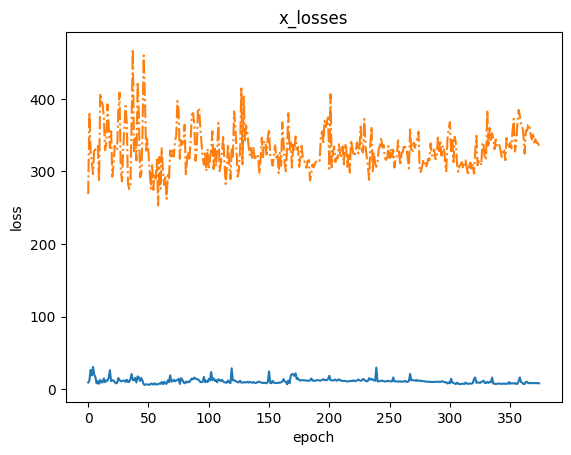

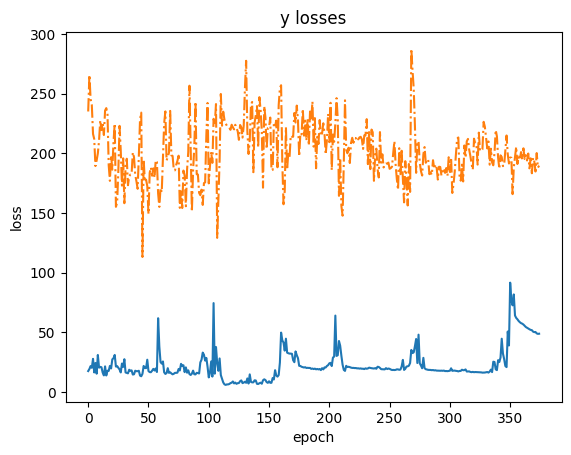

In [16]:
plt.plot(losses_x)
plt.plot( losses_val_x, '-.')

plt.xlabel("epoch")
plt.ylabel("loss")
plt.title('x_losses')
plt.show()

plt.plot(losses_y)
plt.plot(losses_val_y, '-.')

plt.xlabel("epoch")
plt.ylabel("loss")
plt.title('y losses')
plt.show()





# with torch.no_grad():
#     correct = 0
#     total = 0
#     for i, (labels, images) in enumerate(processed_data):
#         images = images.reshape((1, 4, 60, 80))
#         images = images.to(device)
#         labels = torch.tensor(labels, dtype=torch.float32)
#         labels = labels.to(device)
#         outputs = model(images)
#         print([labels[0], labels[1]], [outputs[0], outputs[1]])


